In [2]:
import matplotlib.pyplot as plt
import math
import itertools
import pandas as pd
import numpy as np
import random
from scipy import stats
from scipy.stats import poisson
from scipy.stats import chisquare
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from fractions import Fraction
from PIL import Image


In [3]:
BASE = 2
class PascalModulo:
    def __init__(self,base):
        self.base = base
        self.diags = [[1]]
        
    #Add a diagonal and fill it
    def _add(self):
        self.diags[0].append(1)
        i = 1
        while i <= len(self.diags) - 1:
            self.diags[i].append( (self.diags[i-1][len(self.diags[i])] + self.diags[i][len(self.diags[i]) - 1]) % self.base )
            i+=1
        self.diags.append([1])
            
    #Get element
    def get(self,i,j):
        if (i < 1 or j < 1):
            return 1
        # Compute diagonal if not computed yet
        while (len(self.diags[0]) <= i+j):
            self._add()
        return self.diags[i][j]
    
    
# sierp = PascalModulo(BASE)
# sierp.get(7,7)
# sierp.diags 

In [4]:
class Levin:
    
    def __init__(self,size=1):
        self.size = size
        self.iterator = itertools.product([False, True], repeat=self.size)
        self.block = next(self.iterator)
        self.block_index = 0
        self.sierp = PascalModulo(2)
    
    def get_next_digit(self):
#       print('block: ' + str(self.block) + ' ' + str(self.block_index))
        #check if the whole block was consumed and get a new one
        if len(self.block)  == self.block_index:
            try:
                self.block = next(self.iterator)
            except:
                self.size = self.size * 2
                self.iterator = itertools.product([False, True], repeat=self.size)
                self.block = next(self.iterator)
            self.block_index = 0
        res = 0
        for j in range(self.size):
            res += self.sierp.get(self.block_index,self.size-j-1) * self.block[j]
        self.block_index += 1
        return res%2

class Levin2:
    
    def __init__(self):
        self.file = open('levin_q2.txt')
        
    def get_next_digit(self):
        c = self.file.read(1)
        if not c:
            raise Exception('No more digits')
        return c
    lenc = 0
    
class Champernowne:
    def __init__(self,size=1):
        self.size = size
        self.iterator = itertools.product([False, True], repeat=self.size)
        self.block = next(self.iterator)
        self.block_index = 0
        
    def get_next_digit(self):
        #check if the whole block was consumed and get a new one
        if len(self.block)  == self.block_index:
            try:
                self.block = next(self.iterator)
            except:
                self.size += 1
                self.iterator = itertools.product([False, True], repeat=self.size)
                self.block = next(self.iterator)
            self.block_index = 0
        res = self.block[self.block_index]
        self.block_index += 1
        return res%2
    
class PRNG:
    def get_next_digit(self):
        return random.choice([0,1])
    
class Rule30:
    
    def __init__(self,lencells=100):
        self.lencells = lencells
        self.cells = '1' + '0' * (lencells - 1)
        self.gen = self.eca_wrap()
    
    def eca_wrap(self):
        rulebits = '{0:08b}'.format(30)
        neighbours2next = {tuple('{0:03b}'.format(n)):rulebits[::-1][n] for n in range(8)}
        c = self.cells
        while True:
            yield c
            c = ''.join(neighbours2next[(c[i-1], c[i], c[(i+1) % self.lencells])] for i in range(self.lencells))
        
    
    def get_next_digit(self):
        return next(self.gen)[0]

class Stoneham:
    def __init__(self,b=2,c=3):
        self.b = b
        self.c = c
        self.prev = Fraction(0.0)
        self.n = 0
    
    def get_next_digit(self):
        r = 0
        if self.n > 1 and 1162261467%self.n == 0:
            r = Fraction(1,self.n)
        self.n += 1
        self.prev = self.prev*self.b + r
        self.prev = self.prev - math.floor(self.prev)
        if(math.modf(self.prev)[0] >= 0.5):
            return 1
        return 0
        
        

In [5]:
def get_occurrences(amounts,M):
    #returns frequency of occurencies for each value in the observed range
    occs = {}
    total = 0    
    for k,v in amounts.items():
        total += 1
        if v not in occs:
            occs[v] = 0
        occs[v] = occs[v] + 1
    occs[0] = int(2**M - total)
    max_o = 0
    for k,v in occs.items():
#         occs[k] = v/2**M
        occs[k] = v
        if k > max_o:
            max_o = k
    occs_array = [occs[i] if i in occs  else 0 for i in range(max_o+1)]
    return occs_array

In [6]:
def get_M(N,lamb):
    return int(math.ceil(math.log(N,2) - math.log(lamb,2)))

def normalize_data(occs, N, lamb):
    M = get_M(N,lamb)
    ret = []
    for o in occs:
        ret.append(o/2**M)
    return ret

def get_mean(normalized_occs):
    mean = 0
    for i in range(len(normalized_occs)):
        mean += i*normalized_occs[i]
    return mean

def get_std(normalized_occs,mean):
    if mean == None:
        mean = get_mean(normalized_occs)
        
    std = 0
    for i in range(len(normalized_occs)):
        std += ((i-mean)**2)*normalized_occs[i]
    return std

In [7]:
def get_amounts_for_ns(Ns,lamb=1,use_seq='levin'):
    if use_seq == 'levin':
        sequence = Levin()
    elif use_seq == 'levin2':
        sequence = Levin2()
    elif use_seq == 'champernowne':
        sequence = Champernowne()
    elif use_seq == 'rule30':
        sequence = Rule30()
    elif use_seq == 'stoneham':
        sequence = Stoneham()
    else:
        sequence = PRNG()
        
        
    Ms = [get_M(N,lamb) for N in Ns]
    
    min_M = min(Ms)
    max_M = max(Ms)
    max_N = max(Ns)
    
    #create dictionaries to store frequencies of every N value
    amounts = {}
    occurrences = {}
    for N in Ns:
        amounts[N] = {}    
    counter = 0
    word = ''
    
    #Get digits up to max M
    while len(word) < max_M:
        counter += 1
        word = word + str(sequence.get_next_digit())
    
    #process first big word
    for i in range(len(Ms)):
        M = Ms[i]
        N = Ns[i]
        for j in range(len(word) - M + 1):
            if counter < N :
                sub_word = word[j:M+j]
                if  sub_word not in amounts[N]:
                    amounts[N][sub_word] = 0
                amounts[N][sub_word] = amounts[N][sub_word] + 1
            elif N not in occurrences:
                #Ns[i] is done and not processed, process occurences and store
                occurrences[N] = get_occurrences(amounts[N],M)
    #process up to max
    while counter <= max_N:
        #get new big word
        word = word[1:]
        word = word + str(sequence.get_next_digit())
        
        #process for each M
        for i in range(len(Ms)):
            M = Ms[i]
            N = Ns[i]
            if counter < N:
                sub_word = word[len(word) - M:]
                if  sub_word not in amounts[N]:
                    amounts[N][sub_word] = 0
                amounts[N][sub_word] = amounts[N][sub_word] + 1
            else:
                if N not in occurrences:
                    #N[i] is done and not processed, process occurences and store
                    occurrences[N] = get_occurrences(amounts[N],M)
        counter += 1
    #This is for finding champernowne witness
    if use_seq == 'champernowne':
        return (occurrences,amounts)
    return occurrences

In [8]:
def get_amounts_for_first(N,lamb=1):
    get_amounts_for_ns([N],lamb)

In [9]:
def analize_result(occs,N,l=1,plot=True):
    print("---- Normalized data ----")
    actual = np.array(normalize_data(occs,N,l))
    M = int(math.ceil(math.log(N,2)))    
    x= np.arange(0,len(actual),1)
    p = poisson.pmf(x,l)
    mean = get_mean(actual)
    std = get_std(actual,mean)
    print ("Mean: "+ str(mean) + "; expected: " + str(l) + "; difference: " + str(abs(l-mean)))
    print ("Std: "+ str(std) + "; expected: " + str(l) + "; difference: " + str(abs(l-std)))
    print("difference between std and mean :"+  str(abs(mean-std)))
    print("MWU: " + str(mannwhitneyu(actual,p)))
    print("Levene: " + str(levene(actual,p)))
    if(plot):
        plt.figure(l)
        plt.plot(x, p)
        p2 = plt.bar(x-0.5, p,label="expected",width=0.5)
        p1 = plt.bar(x, actual, color='#d62728',label="actual",width=0.5)
        plt.legend(loc='best')
        plt.show()
#         plt.figure(l+1)
#         stats.probplot(actual, dist='poisson', sparams=(l), plot=plt)
#         plt.show()

def analize_result_2(occs,l=1,plot=True):
    print("---- Sample data ----")
    actual = np.array(occs)
    sample = poisson.rvs(1, size=sum(occs))
    expected = [0 for i in range(max(max(sample)+1,len(actual)))]
    for i in sample:
        expected[i] += 1
    expected = np.array(expected)
    x= np.arange(0,len(actual),l)
#     print("chisquare: " + str(chisquare(f_obs=actual, f_exp=expected)))
    print("MWU: " + str(mannwhitneyu(actual,expected)))
    print("Levene: " + str(levene(actual,expected)))
    
    data_by_index = []
    for i in range(len(occs)):
        for j in range(occs[i]):
            data_by_index.append(i)
    
    if(plot):
#         plt.figure(l)
#         plt.plot(x, expected)
#         p2 = plt.bar(x-0.5, expected,label="expected",width=0.5)
#         p1 = plt.bar(x, actual, color='#d62728',label="actual",width=0.5)
#         plt.legend(loc='best')
#         plt.show()
        plt.figure(l+1)
        stats.probplot(data_by_index, dist='poisson', sparams=(l), plot=plt)
        plt.show()
    

In [10]:
def perform_test(seq,fr=10,to=26,lamb=1):
    Ns = [2**i for i in range(fr,to)]
    occs = get_amounts_for_ns(Ns,lamb=lamb,use_seq=seq)
    for N in Ns:
        print(N)
        analize_result(occs[N],N,plot=True,l=lamb)
        analize_result_2(occs[N],plot=True,l=lamb)

### Levin with lambda = 1 from N=2ˆ10 up to 2ˆ26.

1024
---- Normalized data ----
Mean: 0.9912109375; expected: 1; difference: 0.0087890625
Std: 1.004805564880371; expected: 1; difference: 0.004805564880371094
difference between std and mean :0.013594627380371094
MWU: MannwhitneyuResult(statistic=12.0, pvalue=0.5)
Levene: LeveneResult(statistic=0.0049167291327789865, pvalue=0.9458197429872082)


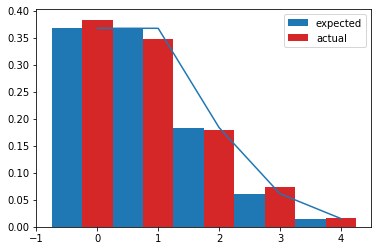

---- Sample data ----
MWU: MannwhitneyuResult(statistic=12.0, pvalue=0.32403843406957306)
Levene: LeveneResult(statistic=0.05779170445220024, pvalue=0.8154073829127333)


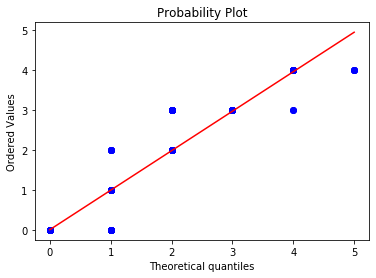

2048
---- Normalized data ----
Mean: 0.9951171875; expected: 1; difference: 0.0048828125
Std: 1.6982183456420898; expected: 1; difference: 0.6982183456420898
difference between std and mean :0.7031011581420898
MWU: MannwhitneyuResult(statistic=28.0, pvalue=0.35649474372537043)
Levene: LeveneResult(statistic=0.024501968715707558, pvalue=0.8778492966813998)


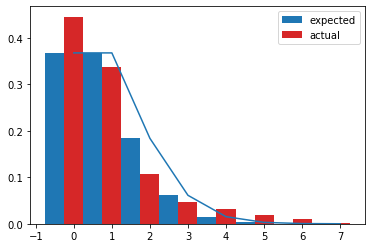

---- Sample data ----
MWU: MannwhitneyuResult(statistic=28.0, pvalue=0.35649474372537043)
Levene: LeveneResult(statistic=0.02127722802893186, pvalue=0.8861056888656839)


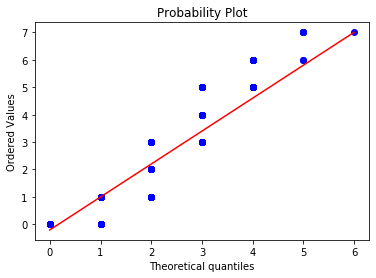

4096
---- Normalized data ----
Mean: 0.997314453125; expected: 1; difference: 0.002685546875
Std: 2.357658803462982; expected: 1; difference: 1.3576588034629822
difference between std and mean :1.3603443503379822
MWU: MannwhitneyuResult(statistic=38.0, pvalue=0.19224714130808945)
Levene: LeveneResult(statistic=0.01952968845554192, pvalue=0.8904104014638252)


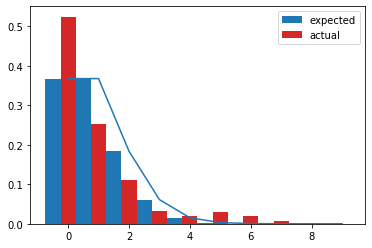

---- Sample data ----
MWU: MannwhitneyuResult(statistic=37.0, pvalue=0.17198879328001915)
Levene: LeveneResult(statistic=0.020555463665818424, pvalue=0.8875894126713759)


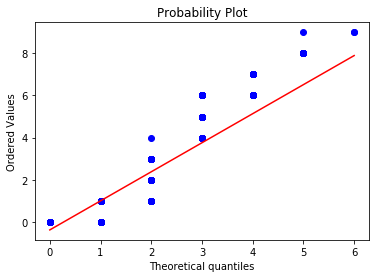

8192
---- Normalized data ----
Mean: 0.99853515625; expected: 1; difference: 0.00146484375
Std: 2.871335744857788; expected: 1; difference: 1.871335744857788
difference between std and mean :1.872800588607788
MWU: MannwhitneyuResult(statistic=57.0, pvalue=0.08304884325307571)
Levene: LeveneResult(statistic=0.007279774594646783, pvalue=0.9327135094599398)


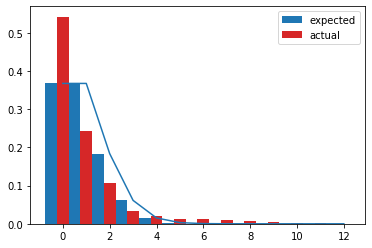

---- Sample data ----
MWU: MannwhitneyuResult(statistic=57.0, pvalue=0.08181375077629105)
Levene: LeveneResult(statistic=0.007285925533829921, pvalue=0.9326851608913617)


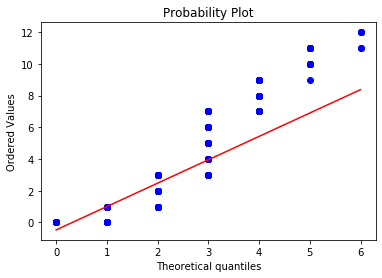

16384
---- Normalized data ----
Mean: 0.99920654296875; expected: 1; difference: 0.00079345703125
Std: 2.6146844290196896; expected: 1; difference: 1.6146844290196896
difference between std and mean :1.6154778860509396
MWU: MannwhitneyuResult(statistic=57.0, pvalue=0.08304884325307571)
Levene: LeveneResult(statistic=0.00594253053482773, pvalue=0.9391927533494306)


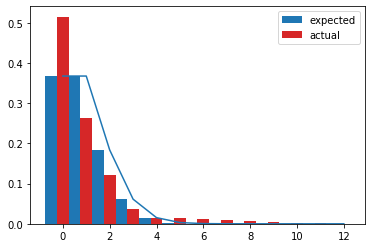

---- Sample data ----
MWU: MannwhitneyuResult(statistic=58.0, pvalue=0.0904620329347059)
Levene: LeveneResult(statistic=0.005926081270710814, pvalue=0.9392767973932147)


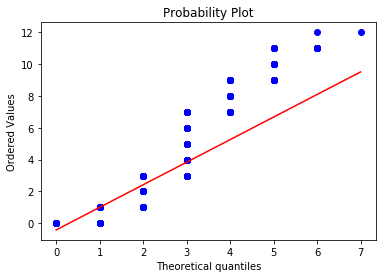

32768
---- Normalized data ----
Mean: 0.99957275390625; expected: 1; difference: 0.00042724609375
Std: 1.6543577276170254; expected: 1; difference: 0.6543577276170254
difference between std and mean :0.6547849737107754
MWU: MannwhitneyuResult(statistic=40.0, pvalue=0.236254534162193)
Levene: LeveneResult(statistic=0.006640871672664533, pvalue=0.9359503537605405)


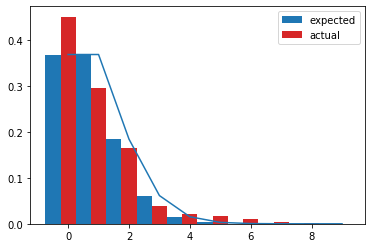

---- Sample data ----
MWU: MannwhitneyuResult(statistic=41.0, pvalue=0.2601830104482655)
Levene: LeveneResult(statistic=0.006401657405544025, pvalue=0.9371118727973585)


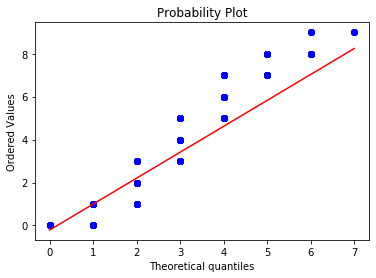

65536
---- Normalized data ----
Mean: 0.9997711181640625; expected: 1; difference: 0.0002288818359375
Std: 1.0801543665584177; expected: 1; difference: 0.08015436655841768
difference between std and mean :0.08038324839435518
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491077413427273)
Levene: LeveneResult(statistic=7.61101538063888e-06, pvalue=0.9978441261273717)


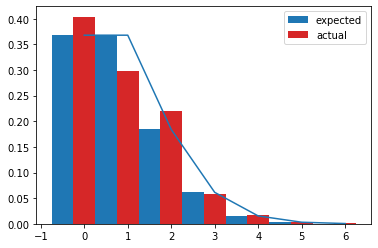

---- Sample data ----
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.1985505729131255)
Levene: LeveneResult(statistic=0.08197174067464887, pvalue=0.7788360264472263)


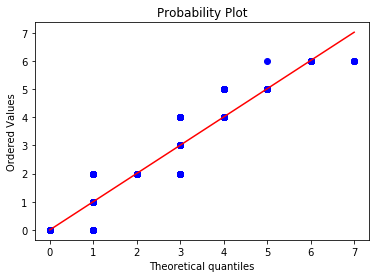

131072
---- Normalized data ----
Mean: 0.9998779296875; expected: 1; difference: 0.0001220703125
Std: 1.4127654880285263; expected: 1; difference: 0.4127654880285263
difference between std and mean :0.4128875583410263
MWU: MannwhitneyuResult(statistic=39.0, pvalue=0.4648001417660872)
Levene: LeveneResult(statistic=0.0019934726139235405, pvalue=0.9649401170989879)


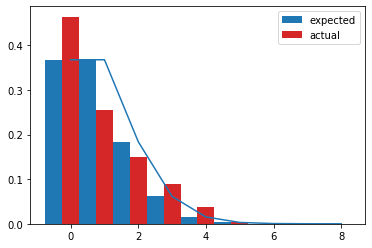

---- Sample data ----
MWU: MannwhitneyuResult(statistic=39.0, pvalue=0.46481826225353534)
Levene: LeveneResult(statistic=0.001960283523929858, pvalue=0.9652329917409268)


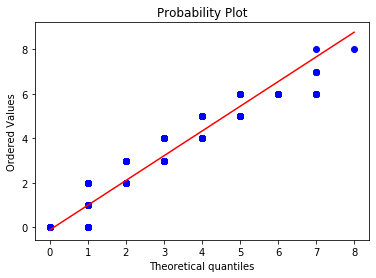

262144
---- Normalized data ----
Mean: 0.9999351501464844; expected: 1; difference: 6.4849853515625e-05
Std: 1.2309455829526996; expected: 1; difference: 0.23094558295269962
difference between std and mean :0.23101043280621525
MWU: MannwhitneyuResult(statistic=18.0, pvalue=0.46803733853330987)
Levene: LeveneResult(statistic=0.06768552277008419, pvalue=0.8000153083160187)


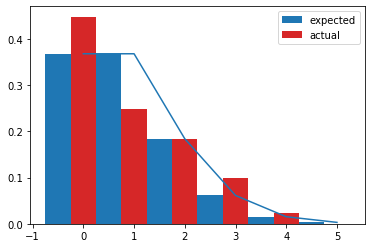

---- Sample data ----
MWU: MannwhitneyuResult(statistic=20.0, pvalue=0.22182852795585656)
Levene: LeveneResult(statistic=0.06576556324319288, pvalue=0.8016185506835591)


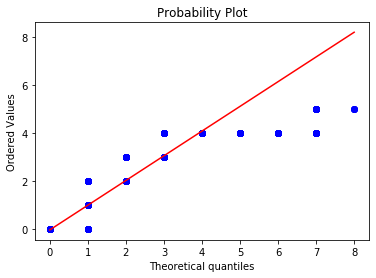

524288
---- Normalized data ----
Mean: 0.9999656677246094; expected: 1; difference: 3.4332275390625e-05
Std: 1.9415435779228574; expected: 1; difference: 0.9415435779228574
difference between std and mean :0.941577910198248
MWU: MannwhitneyuResult(statistic=35.0, pvalue=0.3293391219268744)
Levene: LeveneResult(statistic=0.022797197859353316, pvalue=0.8818728658364281)


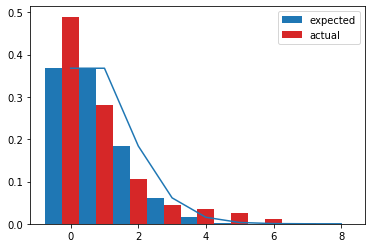

---- Sample data ----
MWU: MannwhitneyuResult(statistic=35.0, pvalue=0.218971411449987)
Levene: LeveneResult(statistic=0.0003992951218324344, pvalue=0.9842900990352508)


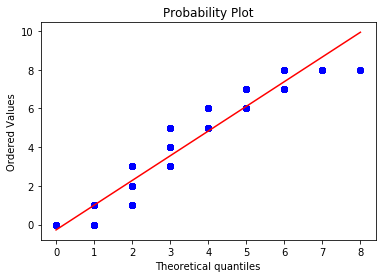

1048576
---- Normalized data ----
Mean: 0.9999818801879883; expected: 1; difference: 1.811981201171875e-05
Std: 3.508711814552043; expected: 1; difference: 2.508711814552043
difference between std and mean :2.508729934364055
MWU: MannwhitneyuResult(statistic=71.0, pvalue=0.04449121604787045)
Levene: LeveneResult(statistic=0.006134905109442705, pvalue=0.9381261006388495)


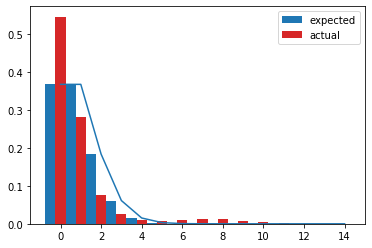

---- Sample data ----
MWU: MannwhitneyuResult(statistic=71.0, pvalue=0.044153493668570666)
Levene: LeveneResult(statistic=0.006132304997537157, pvalue=0.9381391860714884)


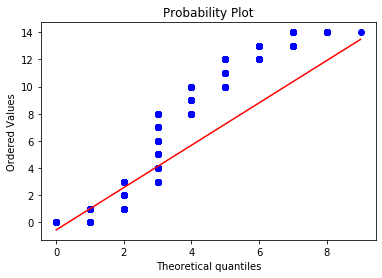

2097152
---- Normalized data ----
Mean: 0.9999904632568359; expected: 1; difference: 9.5367431640625e-06
Std: 5.82415485372985; expected: 1; difference: 4.82415485372985
difference between std and mean :4.8241643904730145
MWU: MannwhitneyuResult(statistic=110.0, pvalue=0.00282662529746181)
Levene: LeveneResult(statistic=0.001785449955241599, pvalue=0.9665059706715847)


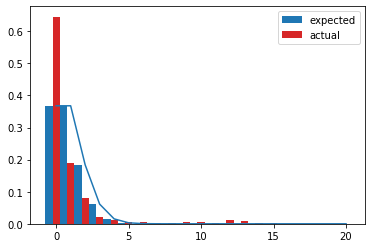

---- Sample data ----
MWU: MannwhitneyuResult(statistic=109.0, pvalue=0.002419852819616101)
Levene: LeveneResult(statistic=0.0017853810725533634, pvalue=0.9665066163839358)


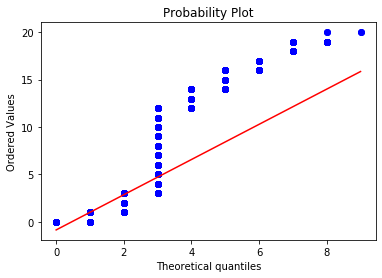

4194304
---- Normalized data ----
Mean: 0.9999949932098389; expected: 1; difference: 5.0067901611328125e-06
Std: 8.672738313649857; expected: 1; difference: 7.672738313649857
difference between std and mean :7.672743320440018
MWU: MannwhitneyuResult(statistic=181.0, pvalue=1.279418896224441e-05)
Levene: LeveneResult(statistic=0.0005073957539012222, pvalue=0.9821035594574348)


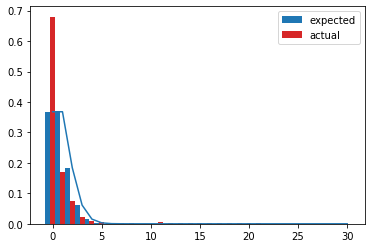

---- Sample data ----
MWU: MannwhitneyuResult(statistic=181.0, pvalue=8.791166592279554e-06)
Levene: LeveneResult(statistic=0.0005074012385608975, pvalue=0.9821034627492836)


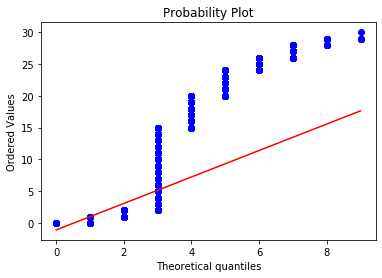

8388608
---- Normalized data ----
Mean: 0.9999973773956299; expected: 1; difference: 2.6226043701171875e-06
Std: 10.543477773659504; expected: 1; difference: 9.543477773659504
difference between std and mean :9.543480396263874
MWU: MannwhitneyuResult(statistic=211.0, pvalue=3.4724807366699203e-06)
Levene: LeveneResult(statistic=0.00011366321111770494, pvalue=0.9915258396343581)


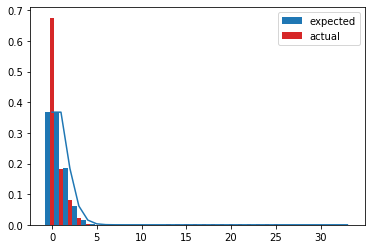

---- Sample data ----
MWU: MannwhitneyuResult(statistic=211.0, pvalue=2.139330097605544e-06)
Levene: LeveneResult(statistic=0.00011366901661024957, pvalue=0.9915256232313712)


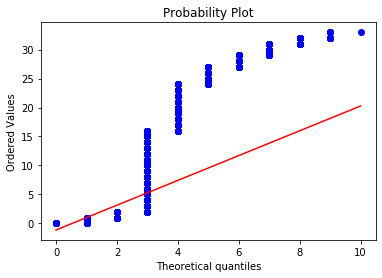

16777216
---- Normalized data ----
Mean: 0.9999986290931702; expected: 1; difference: 1.3709068298339844e-06
Std: 9.73778110742381; expected: 1; difference: 8.73778110742381
difference between std and mean :8.73778247833064
MWU: MannwhitneyuResult(statistic=271.0, pvalue=0.00162730576707812)
Levene: LeveneResult(statistic=1.1793555019668927e-05, pvalue=0.997271323279553)


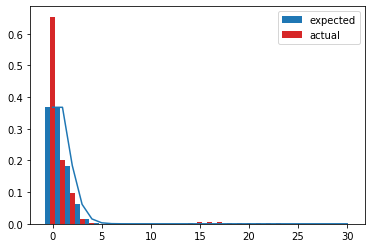

---- Sample data ----
MWU: MannwhitneyuResult(statistic=238.5, pvalue=0.00023008460315132806)
Levene: LeveneResult(statistic=1.1793797132570315e-05, pvalue=0.9972712952709363)


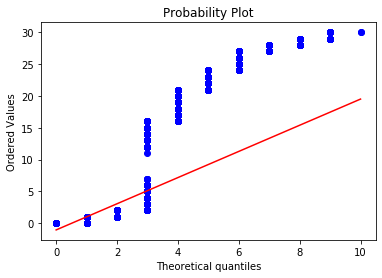

33554432
---- Normalized data ----
Mean: 0.9999992847442627; expected: 1; difference: 7.152557373046875e-07
Std: 8.392646253108467; expected: 1; difference: 7.392646253108467
difference between std and mean :7.392646968364204
MWU: MannwhitneyuResult(statistic=242.0, pvalue=0.007141154116910575)
Levene: LeveneResult(statistic=4.457923484427121e-06, pvalue=0.9983231449233902)


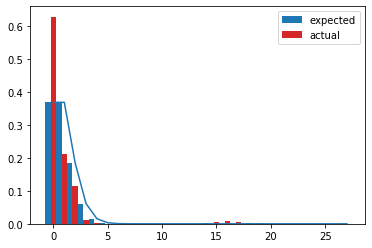

---- Sample data ----
MWU: MannwhitneyuResult(statistic=219.0, pvalue=0.001965389506298993)
Levene: LeveneResult(statistic=4.457900794262494e-06, pvalue=0.9983231491911776)


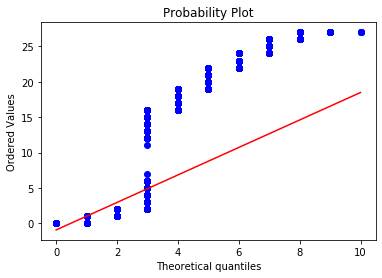

In [39]:
perform_test(seq='levin',lamb=1)

### Levin with lambda = 4 from N=2ˆ10 up to 2ˆ26.

1024
---- Normalized data ----
Mean: 3.97265625; expected: 4; difference: 0.02734375
Std: 1.1437835693359375; expected: 4; difference: 2.8562164306640625
difference between std and mean :2.8288726806640625
MWU: MannwhitneyuResult(statistic=28.0, pvalue=0.35649474372537043)
Levene: LeveneResult(statistic=2.0832568446685484, pvalue=0.17092411742020922)


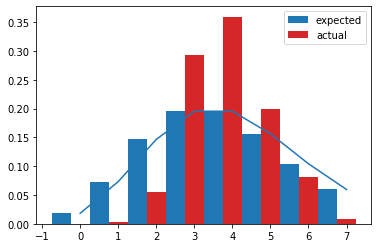

---- Sample data ----
MWU: MannwhitneyuResult(statistic=28.5, pvalue=0.37546795691860774)
Levene: LeveneResult(statistic=0.03518172377985462, pvalue=0.8539066763755849)


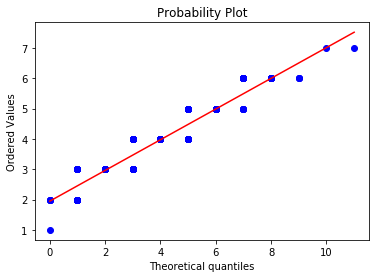

2048
---- Normalized data ----
Mean: 3.984375; expected: 4; difference: 0.015625
Std: 4.003662109375; expected: 4; difference: 0.003662109375
difference between std and mean :0.019287109375
MWU: MannwhitneyuResult(statistic=40.0, pvalue=0.5)
Levene: LeveneResult(statistic=0.026750417256994542, pvalue=0.8721291559041374)


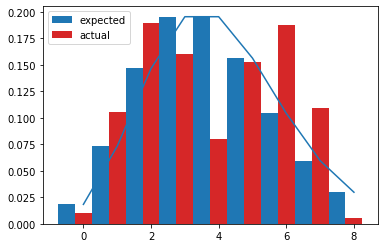

---- Sample data ----
MWU: MannwhitneyuResult(statistic=29.5, pvalue=0.17666981870399046)
Levene: LeveneResult(statistic=1.2009704450850136, pvalue=0.28934965124828155)


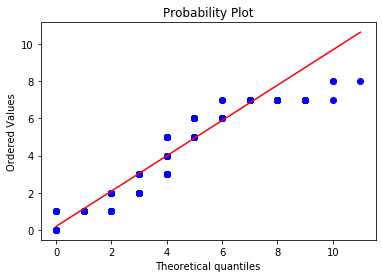

4096
---- Normalized data ----
Mean: 3.9912109375; expected: 4; difference: 0.0087890625
Std: 7.729414939880371; expected: 4; difference: 3.729414939880371
difference between std and mean :3.738204002380371
MWU: MannwhitneyuResult(statistic=68.0, pvalue=0.4199128098550591)
Levene: LeveneResult(statistic=2.9364364434423114, pvalue=0.10065945533192554)


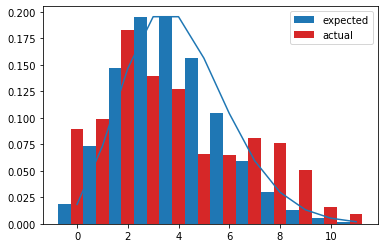

---- Sample data ----
MWU: MannwhitneyuResult(statistic=42.5, pvalue=0.045746422955355255)
Levene: LeveneResult(statistic=1.29774384328942, pvalue=0.2668783111725755)


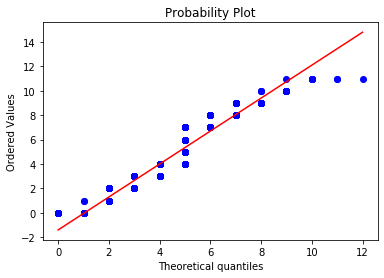

8192
---- Normalized data ----
Mean: 3.9951171875; expected: 4; difference: 0.0048828125
Std: 12.76071834564209; expected: 4; difference: 8.76071834564209
difference between std and mean :8.76560115814209
MWU: MannwhitneyuResult(statistic=117.0, pvalue=0.1761735261773139)
Levene: LeveneResult(statistic=0.6561201060207555, pvalue=0.4239159519492547)


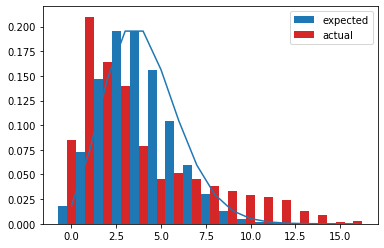

---- Sample data ----
MWU: MannwhitneyuResult(statistic=66.0, pvalue=0.0033461567133824728)
Levene: LeveneResult(statistic=0.33774571701631806, pvalue=0.5652046293448107)


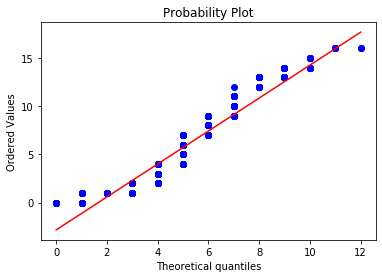

16384
---- Normalized data ----
Mean: 3.997314453125; expected: 4; difference: 0.002685546875
Std: 13.012932240962982; expected: 4; difference: 9.012932240962982
difference between std and mean :9.015617787837982
MWU: MannwhitneyuResult(statistic=131.0, pvalue=0.16726253938624047)
Levene: LeveneResult(statistic=0.2725697079765224, pvalue=0.6049982334881434)


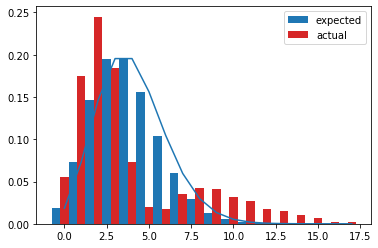

---- Sample data ----
MWU: MannwhitneyuResult(statistic=73.0, pvalue=0.002252015883589089)
Levene: LeveneResult(statistic=0.16487723504320687, pvalue=0.6872496353910784)


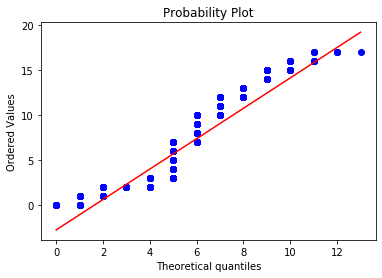

32768
---- Normalized data ----
Mean: 3.99853515625; expected: 4; difference: 0.00146484375
Std: 8.037595510482788; expected: 4; difference: 4.037595510482788
difference between std and mean :4.039060354232788
MWU: MannwhitneyuResult(statistic=115.0, pvalue=0.3187651485735424)
Levene: LeveneResult(statistic=0.1390326730184369, pvalue=0.7118661695102428)


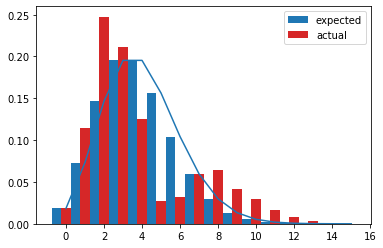

---- Sample data ----
MWU: MannwhitneyuResult(statistic=65.5, pvalue=0.009258102506791712)
Levene: LeveneResult(statistic=0.1327615127589269, pvalue=0.718141574441623)


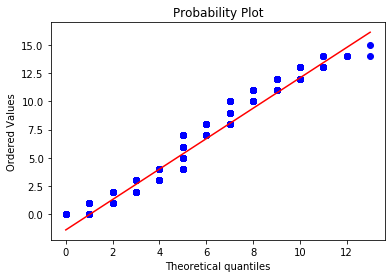

65536
---- Normalized data ----
Mean: 3.99920654296875; expected: 4; difference: 0.00079345703125
Std: 4.86907896026969; expected: 4; difference: 0.8690789602696896
difference between std and mean :0.8698724173009396
MWU: MannwhitneyuResult(statistic=98.0, pvalue=0.4908343159714798)
Levene: LeveneResult(statistic=0.07490649077371138, pvalue=0.7864850086103607)


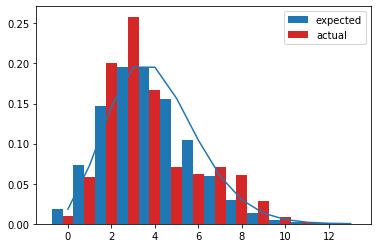

---- Sample data ----
MWU: MannwhitneyuResult(statistic=58.0, pvalue=0.034099587782872455)
Levene: LeveneResult(statistic=0.1537186701739266, pvalue=0.6982021257133872)


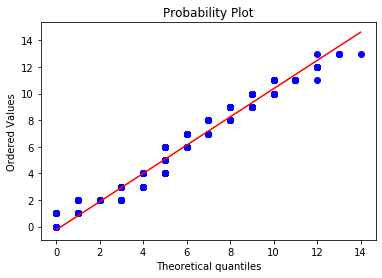

131072
---- Normalized data ----
Mean: 3.99957275390625; expected: 4; difference: 0.00042724609375
Std: 4.970825012773275; expected: 4; difference: 0.9708250127732754
difference between std and mean :0.9712522588670254
MWU: MannwhitneyuResult(statistic=83.0, pvalue=0.47954689165054204)
Levene: LeveneResult(statistic=0.18857793878918594, pvalue=0.6679819964337423)


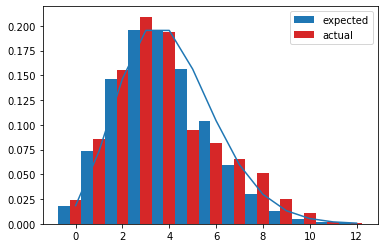

---- Sample data ----
MWU: MannwhitneyuResult(statistic=49.0, pvalue=0.03584830688883369)
Levene: LeveneResult(statistic=0.31333626132005027, pvalue=0.5808274749750509)


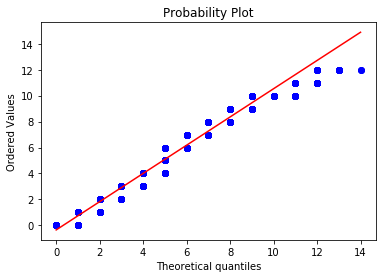

262144
---- Normalized data ----
Mean: 3.9997711181640625; expected: 4; difference: 0.0002288818359375
Std: 2.4051970911677927; expected: 4; difference: 1.5948029088322073
difference between std and mean :1.5945740269962698
MWU: MannwhitneyuResult(statistic=55.0, pvalue=0.3712978976688617)
Levene: LeveneResult(statistic=0.4550511816979555, pvalue=0.5076693899156225)


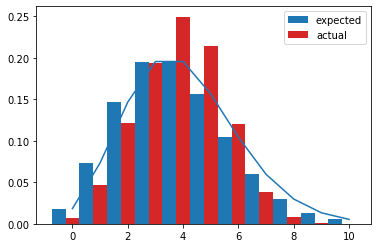

---- Sample data ----
MWU: MannwhitneyuResult(statistic=43.5, pvalue=0.13916356040949124)
Levene: LeveneResult(statistic=0.08222282595816788, pvalue=0.7772569259563556)


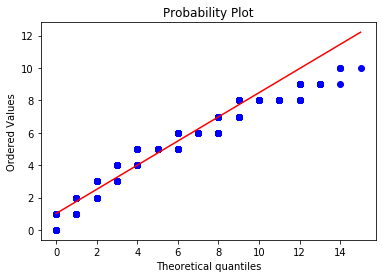

524288
---- Normalized data ----
Mean: 3.9998779296875; expected: 4; difference: 0.0001220703125
Std: 4.432586655020714; expected: 4; difference: 0.4325866550207138
difference between std and mean :0.4327087253332138
MWU: MannwhitneyuResult(statistic=48.0, pvalue=0.4548440381117453)
Levene: LeveneResult(statistic=0.7382148349472399, pvalue=0.40153127253839027)


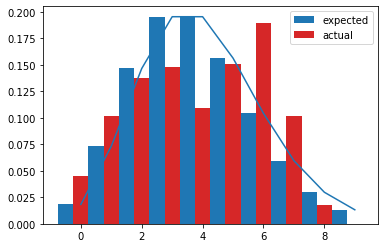

---- Sample data ----
MWU: MannwhitneyuResult(statistic=35.0, pvalue=0.13651816987559418)
Levene: LeveneResult(statistic=1.1909679860213505, pvalue=0.28952745330498286)


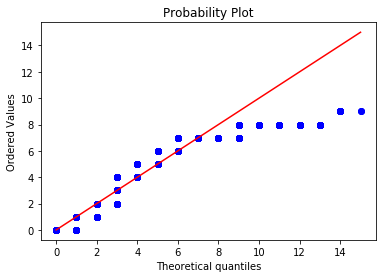

1048576
---- Normalized data ----
Mean: 3.9999351501464844; expected: 4; difference: 6.4849853515625e-05
Std: 9.94719314154645; expected: 4; difference: 5.94719314154645
difference between std and mean :5.947257991399965
MWU: MannwhitneyuResult(statistic=110.0, pvalue=0.254749975810591)
Levene: LeveneResult(statistic=0.5749622989566479, pvalue=0.4542097337998634)


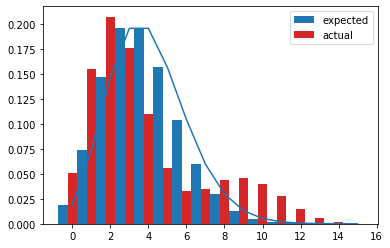

---- Sample data ----
MWU: MannwhitneyuResult(statistic=66.0, pvalue=0.009906880556713526)
Levene: LeveneResult(statistic=0.32594410765243087, pvalue=0.572309399179669)


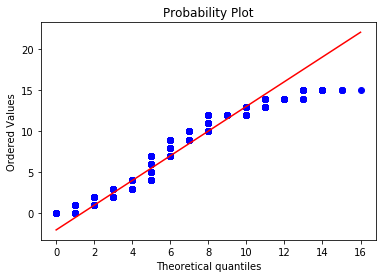

2097152
---- Normalized data ----
Mean: 3.9999656677246094; expected: 4; difference: 3.4332275390625e-05
Std: 21.214447020305666; expected: 4; difference: 17.214447020305666
difference between std and mean :17.214481352581057
MWU: MannwhitneyuResult(statistic=192.0, pvalue=0.056844217669228043)
Levene: LeveneResult(statistic=0.16254068937034302, pvalue=0.6887805020708471)


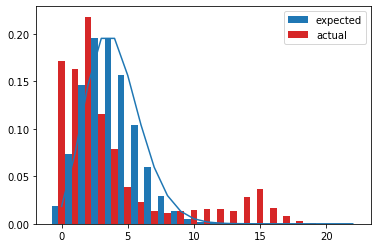

---- Sample data ----
MWU: MannwhitneyuResult(statistic=106.0, pvalue=0.00022341416583052128)
Levene: LeveneResult(statistic=0.08532074259269037, pvalue=0.7715852333281804)


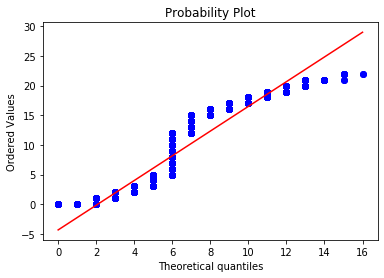

4194304
---- Normalized data ----
Mean: 3.9999818801879883; expected: 4; difference: 1.811981201171875e-05
Std: 37.2131071087415; expected: 4; difference: 33.2131071087415
difference between std and mean :33.21312522855351
MWU: MannwhitneyuResult(statistic=345.0, pvalue=0.0008556628669671924)
Levene: LeveneResult(statistic=0.03320992490294056, pvalue=0.8559397848632087)


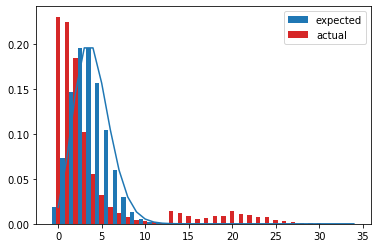

---- Sample data ----
MWU: MannwhitneyuResult(statistic=182.0, pvalue=1.1718761299813051e-07)
Levene: LeveneResult(statistic=0.019401674466660933, pvalue=0.8896327927189932)


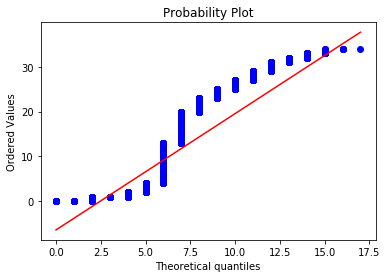

8388608
---- Normalized data ----
Mean: 3.999990463256836; expected: 4; difference: 9.5367431640625e-06
Std: 48.360383033661506; expected: 4; difference: 44.360383033661506
difference between std and mean :44.36039257040467
MWU: MannwhitneyuResult(statistic=441.0, pvalue=0.000280596305027398)
Levene: LeveneResult(statistic=0.0036445730478970938, pvalue=0.9520151276186527)


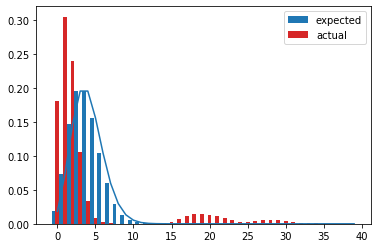

---- Sample data ----
MWU: MannwhitneyuResult(statistic=230.0, pvalue=8.180751292363732e-09)
Levene: LeveneResult(statistic=0.002308151021222952, pvalue=0.9618046004789659)


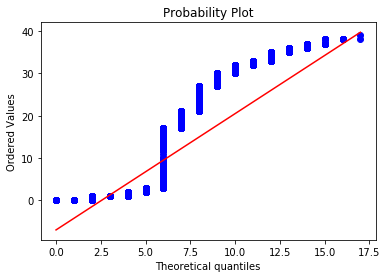

16777216
---- Normalized data ----
Mean: 3.999994993209839; expected: 4; difference: 5.0067901611328125e-06
Std: 45.70682454106686; expected: 4; difference: 41.70682454106686
difference between std and mean :41.70682954785702
MWU: MannwhitneyuResult(statistic=528.0, pvalue=0.04582583279583032)
Levene: LeveneResult(statistic=0.000367925317867079, pvalue=0.98474946850908)


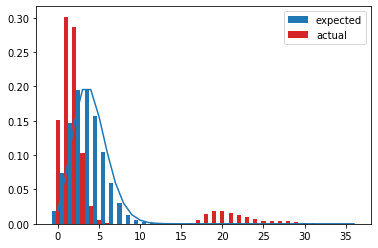

---- Sample data ----
MWU: MannwhitneyuResult(statistic=297.0, pvalue=6.390295548101503e-06)
Levene: LeveneResult(statistic=0.00023574815575526126, pvalue=0.9877921553445519)


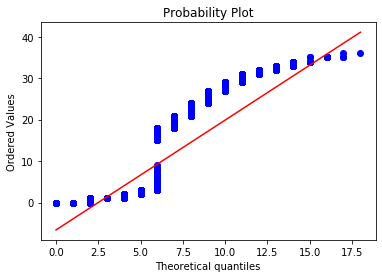

33554432
---- Normalized data ----
Mean: 3.99999737739563; expected: 4; difference: 2.6226043701171875e-06
Std: 40.326763153069294; expected: 4; difference: 36.326763153069294
difference between std and mean :36.326765775673664
MWU: MannwhitneyuResult(statistic=498.0, pvalue=0.09023642098215473)
Levene: LeveneResult(statistic=0.00012193221196300474, pvalue=0.9912220375466301)


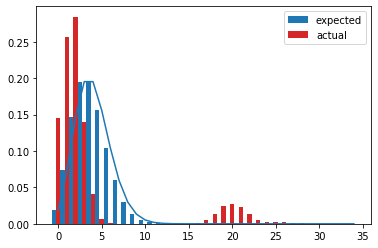

---- Sample data ----
MWU: MannwhitneyuResult(statistic=291.0, pvalue=4.576763936043565e-05)
Levene: LeveneResult(statistic=7.63685354863632e-05, pvalue=0.9930530356488704)


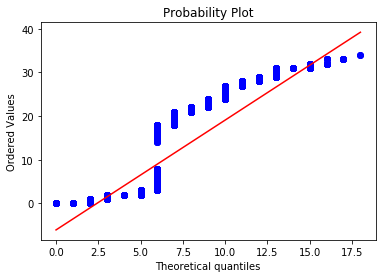

In [40]:
perform_test(seq='levin',lamb=4)

### Levin with lambda = 32 from N=2ˆ10 up to 2ˆ26.

1024
---- Normalized data ----
Mean: 31.875; expected: 32; difference: 0.125
Std: 2.421875; expected: 32; difference: 29.578125
difference between std and mean :29.453125
MWU: MannwhitneyuResult(statistic=235.0, pvalue=7.727578573723386e-07)
Levene: LeveneResult(statistic=0.3333858125216674, pvalue=0.5655247263815502)


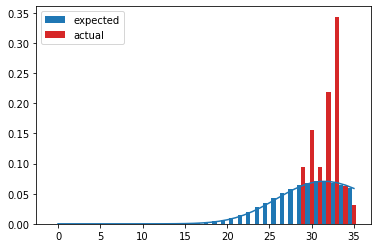

---- Sample data ----
MWU: MannwhitneyuResult(statistic=597.0, pvalue=0.1817862375155243)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


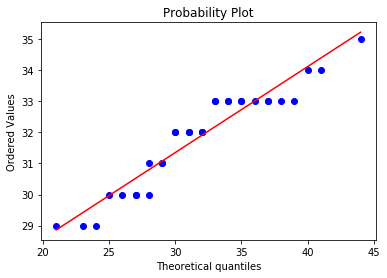

2048
---- Normalized data ----
Mean: 31.921875; expected: 32; difference: 0.078125
Std: 2.509521484375; expected: 32; difference: 29.490478515625
difference between std and mean :29.412353515625
MWU: MannwhitneyuResult(statistic=227.0, pvalue=4.829742536344858e-07)
Levene: LeveneResult(statistic=0.3075037591145999, pvalue=0.5809835115989798)


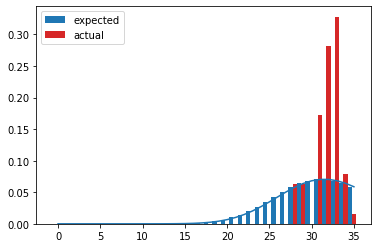

---- Sample data ----
MWU: MannwhitneyuResult(statistic=613.5, pvalue=0.2776138512211944)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


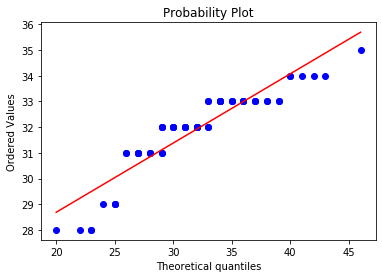

4096
---- Normalized data ----
Mean: 31.953125; expected: 32; difference: 0.046875
Std: 1.372802734375; expected: 32; difference: 30.627197265625
difference between std and mean :30.580322265625
MWU: MannwhitneyuResult(statistic=225.0, pvalue=4.289619986638412e-07)
Levene: LeveneResult(statistic=0.26105854441269183, pvalue=0.6110015942181146)


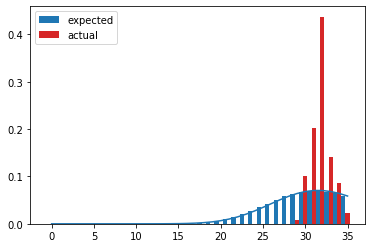

---- Sample data ----
MWU: MannwhitneyuResult(statistic=614.5, pvalue=0.28347110745061765)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


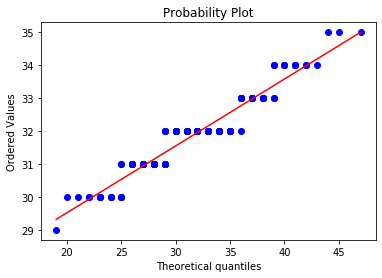

8192
---- Normalized data ----
Mean: 31.97265625; expected: 32; difference: 0.02734375
Std: 7.3078460693359375; expected: 32; difference: 24.692153930664062
difference between std and mean :24.664810180664062
MWU: MannwhitneyuResult(statistic=433.0, pvalue=0.00043409099054936745)
Levene: LeveneResult(statistic=0.18879635126207903, pvalue=0.6651514941784908)


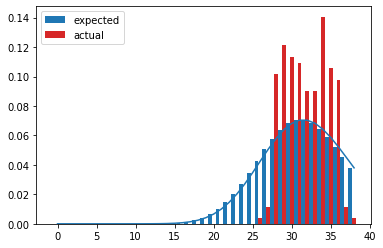

---- Sample data ----
MWU: MannwhitneyuResult(statistic=633.0, pvalue=0.04597334216250312)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


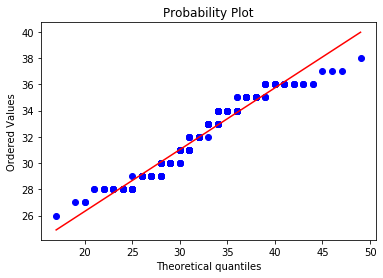

16384
---- Normalized data ----
Mean: 31.984375; expected: 32; difference: 0.015625
Std: 8.421630859375; expected: 32; difference: 23.578369140625
difference between std and mean :23.562744140625
MWU: MannwhitneyuResult(statistic=406.0, pvalue=0.00041107834280415046)
Levene: LeveneResult(statistic=0.2748196167551371, pvalue=0.6016836735915874)


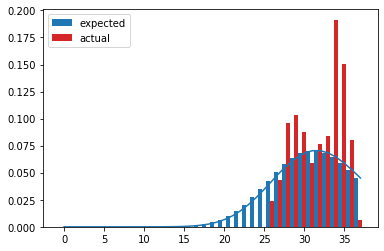

---- Sample data ----
MWU: MannwhitneyuResult(statistic=612.5, pvalue=0.06435452897371924)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


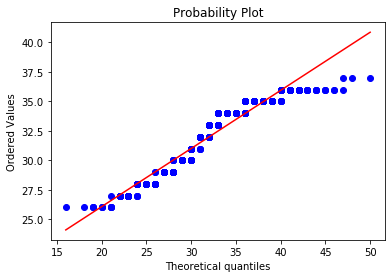

32768
---- Normalized data ----
Mean: 31.9912109375; expected: 32; difference: 0.0087890625
Std: 4.750899314880371; expected: 32; difference: 27.24910068511963
difference between std and mean :27.24031162261963
MWU: MannwhitneyuResult(statistic=372.0, pvalue=3.7414645885677615e-05)
Levene: LeveneResult(statistic=0.13291279998497876, pvalue=0.7164433230349205)


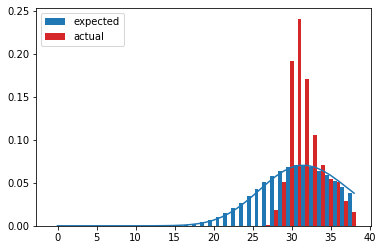

---- Sample data ----
MWU: MannwhitneyuResult(statistic=665.0, pvalue=0.10373744094130433)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


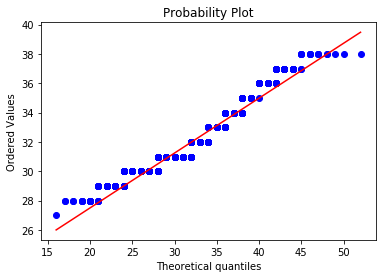

65536
---- Normalized data ----
Mean: 31.9951171875; expected: 32; difference: 0.0048828125
Std: 2.76755428314209; expected: 32; difference: 29.23244571685791
difference between std and mean :29.22756290435791
MWU: MannwhitneyuResult(statistic=335.0, pvalue=6.841796466058768e-06)
Levene: LeveneResult(statistic=0.09858943784222537, pvalue=0.7543892277929263)


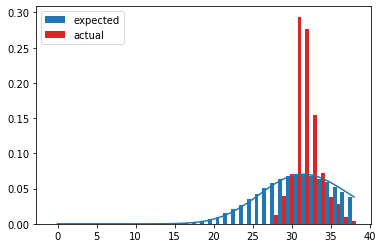

---- Sample data ----
MWU: MannwhitneyuResult(statistic=671.0, pvalue=0.10910012949846698)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


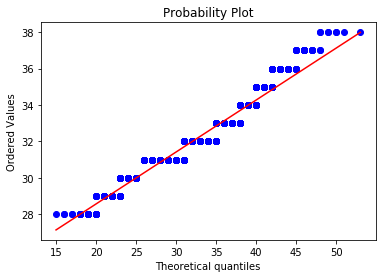

131072
---- Normalized data ----
Mean: 31.997314453125; expected: 32; difference: 0.002685546875
Std: 1.3347095847129822; expected: 32; difference: 30.665290415287018
difference between std and mean :30.662604868412018
MWU: MannwhitneyuResult(statistic=271.0, pvalue=2.620276560544964e-07)
Levene: LeveneResult(statistic=0.06487772757421444, pvalue=0.7996342301189631)


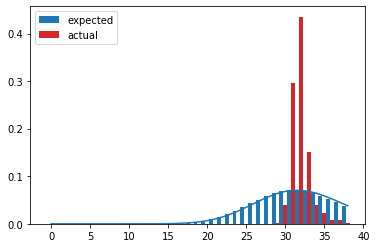

---- Sample data ----
MWU: MannwhitneyuResult(statistic=720.5, pvalue=0.29640875257352556)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


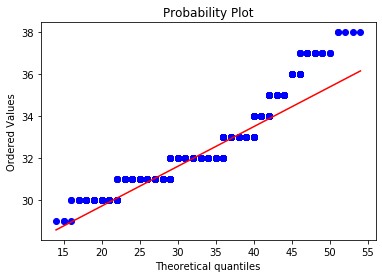

262144
---- Normalized data ----
Mean: 31.99853515625; expected: 32; difference: 0.00146484375
Std: 0.6374490261077881; expected: 32; difference: 31.362550973892212
difference between std and mean :31.361086130142212
MWU: MannwhitneyuResult(statistic=233.0, pvalue=2.9315496162426873e-08)
Levene: LeveneResult(statistic=0.043236824645060165, pvalue=0.8358361921809254)


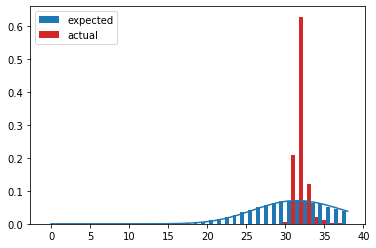

---- Sample data ----
MWU: MannwhitneyuResult(statistic=742.5, pvalue=0.40434437853603944)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


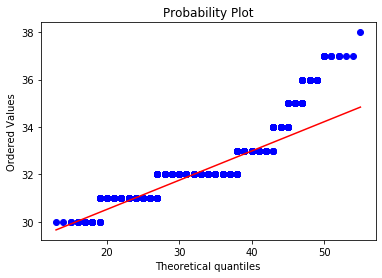

524288
---- Normalized data ----
Mean: 31.99920654296875; expected: 32; difference: 0.00079345703125
Std: 0.28008970245718956; expected: 32; difference: 31.71991029754281
difference between std and mean :31.71911684051156
MWU: MannwhitneyuResult(statistic=202.0, pvalue=1.2674981908457714e-08)
Levene: LeveneResult(statistic=0.045704125561121425, pvalue=0.8313024903186077)


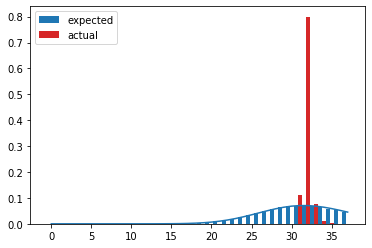

---- Sample data ----
MWU: MannwhitneyuResult(statistic=710.0, pvalue=0.43175512104283775)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


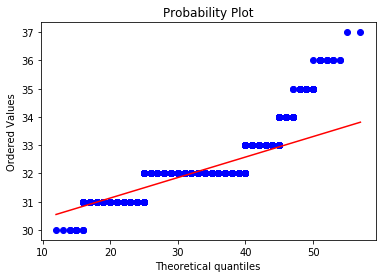

1048576
---- Normalized data ----
Mean: 31.99957275390625; expected: 32; difference: 0.00042724609375
Std: 0.13500958308577538; expected: 32; difference: 31.864990416914225
difference between std and mean :31.864563170820475
MWU: MannwhitneyuResult(statistic=169.0, pvalue=4.652410363106035e-09)
Levene: LeveneResult(statistic=0.05572085059219255, pvalue=0.814062024620932)


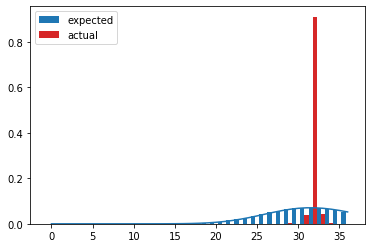

---- Sample data ----
MWU: MannwhitneyuResult(statistic=677.0, pvalue=0.45815218305669775)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


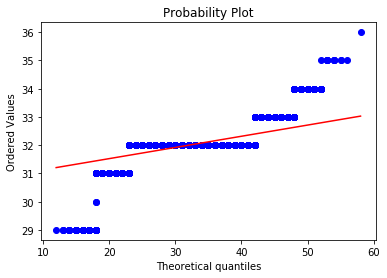

2097152
---- Normalized data ----
Mean: 31.999771118164062; expected: 32; difference: 0.0002288818359375
Std: 53.47270197398029; expected: 32; difference: 21.472701973980293
difference between std and mean :21.47293085581623
MWU: MannwhitneyuResult(statistic=513.0, pvalue=6.0825368835163245e-05)
Levene: LeveneResult(statistic=0.044878869641367954, pvalue=0.832728177254258)


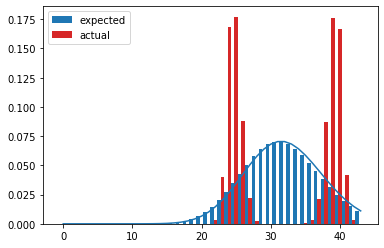

---- Sample data ----
MWU: MannwhitneyuResult(statistic=774.0, pvalue=0.02400449012205555)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


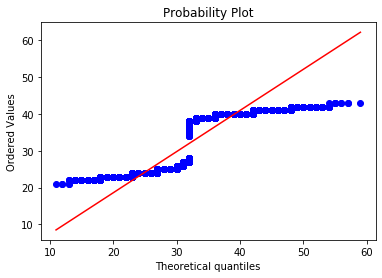

4194304
---- Normalized data ----
Mean: 31.9998779296875; expected: 32; difference: 0.0001220703125
Std: 17.489288315176964; expected: 32; difference: 14.510711684823036
difference between std and mean :14.510589614510536
MWU: MannwhitneyuResult(statistic=656.0, pvalue=0.04337672910193281)
Levene: LeveneResult(statistic=0.10558910312525457, pvalue=0.7460711106126372)


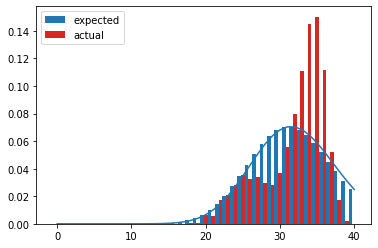

---- Sample data ----
MWU: MannwhitneyuResult(statistic=516.0, pvalue=0.00038895215610944565)
Levene: LeveneResult(statistic=8.71710369592152e-06, pvalue=0.9976516198875575)


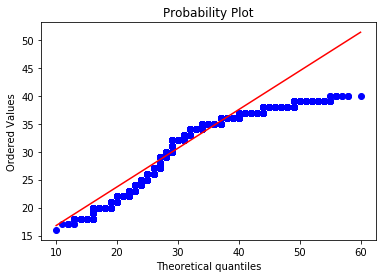

8388608
---- Normalized data ----
Mean: 31.999935150146484; expected: 32; difference: 6.4849853515625e-05
Std: 28.90948104437848; expected: 32; difference: 3.090518955621519
difference between std and mean :3.0904541057680035
MWU: MannwhitneyuResult(statistic=987.0, pvalue=0.06466985233750928)
Levene: LeveneResult(statistic=0.0422270299081159, pvalue=0.8376227362781314)


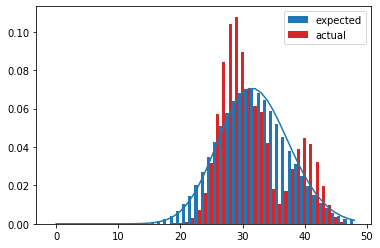

---- Sample data ----
MWU: MannwhitneyuResult(statistic=624.0, pvalue=2.842889969119007e-06)
Levene: LeveneResult(statistic=6.78081803680886e-05, pvalue=0.9934469241836212)


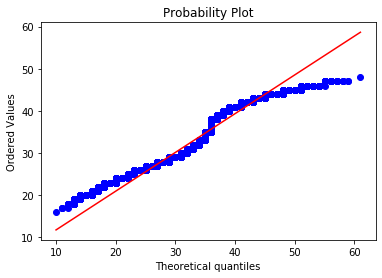

16777216
---- Normalized data ----
Mean: 31.99996566772461; expected: 32; difference: 3.4332275390625e-05
Std: 13.000324248088873; expected: 32; difference: 18.999675751911127
difference between std and mean :18.999641419635736
MWU: MannwhitneyuResult(statistic=721.0, pvalue=0.0007294351170537984)
Levene: LeveneResult(statistic=0.03673430202729513, pvalue=0.8484204222566467)


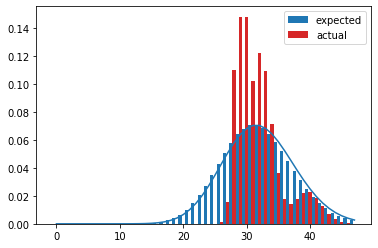

---- Sample data ----
MWU: MannwhitneyuResult(statistic=829.0, pvalue=0.0026352386483886716)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


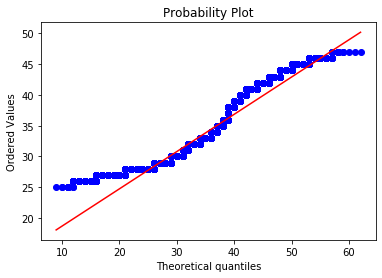

33554432
---- Normalized data ----
Mean: 31.99998188018799; expected: 32; difference: 1.811981201171875e-05
Std: 5.832470893531535; expected: 32; difference: 26.167529106468464
difference between std and mean :26.167510986656453
MWU: MannwhitneyuResult(statistic=593.0, pvalue=4.698954187000397e-05)
Levene: LeveneResult(statistic=0.027157779352153893, pvalue=0.8694659656716026)


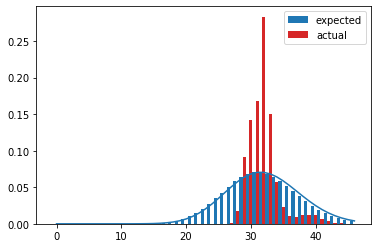

---- Sample data ----
MWU: MannwhitneyuResult(statistic=844.0, pvalue=0.009345791958617584)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


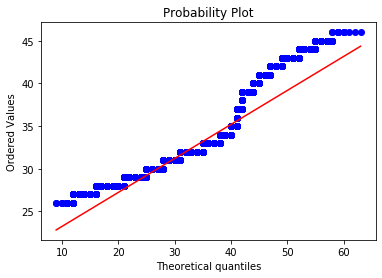

In [41]:
perform_test(seq='levin',lamb=32)

### Champernowne with lambda = 1 from N=2ˆ10 up to 2ˆ26


In [65]:
perform_test(seq='champernowne',lamb=1)

1024


IndexError: tuple index out of range

### Champernowne with lambda = 4 from N=2ˆ10 up to 2ˆ26

In [310]:
perform_test(seq='champernowne',lamb=4)

1024
---- Normalized data ----
Mean: 3.97265625; expected: 4; difference: 0.02734375
Std: 3.8312835693359375; expected: 4; difference: 0.1687164306640625
difference between std and mean :0.1413726806640625
MWU: MannwhitneyuResult(statistic=83.0, pvalue=0.4795364004210436)
Levene: LeveneResult(statistic=0.06057092104351643, pvalue=0.807688527974126)


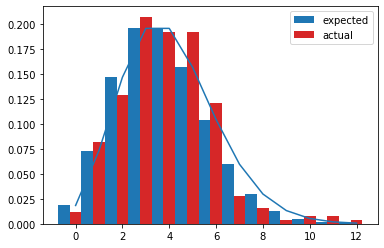

---- Sample data ----
MWU: MannwhitneyuResult(statistic=50.0, pvalue=0.03900358165636666)
Levene: LeveneResult(statistic=0.0531461478396669, pvalue=0.8196302824323345)


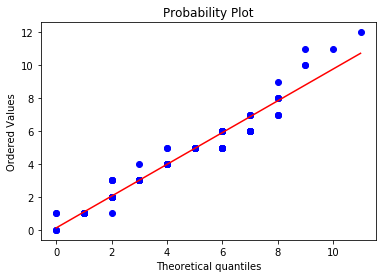

2048
---- Normalized data ----
Mean: 3.984375; expected: 4; difference: 0.015625
Std: 5.706787109375; expected: 4; difference: 1.706787109375
difference between std and mean :1.722412109375
MWU: MannwhitneyuResult(statistic=130.0, pvalue=0.31475003399766704)
Levene: LeveneResult(statistic=0.01946761667567792, pvalue=0.8899086644109994)


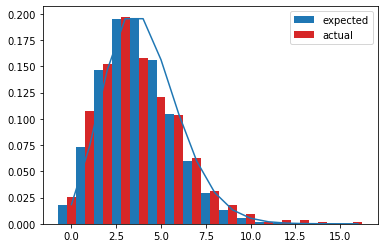

---- Sample data ----
MWU: MannwhitneyuResult(statistic=80.5, pvalue=0.012627807069794987)
Levene: LeveneResult(statistic=0.03766970826211889, pvalue=0.8473347326519634)


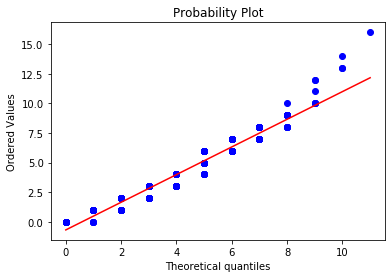

4096
---- Normalized data ----
Mean: 3.9912109375; expected: 4; difference: 0.0087890625
Std: 8.006758689880371; expected: 4; difference: 4.006758689880371
difference between std and mean :4.015547752380371
MWU: MannwhitneyuResult(statistic=191.0, pvalue=0.23279770605455818)
Levene: LeveneResult(statistic=0.017646232628812004, pvalue=0.8949866422193873)


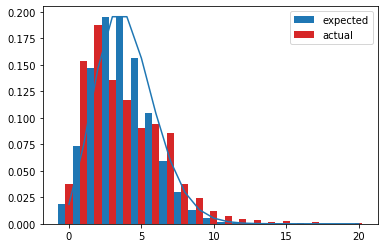

---- Sample data ----
MWU: MannwhitneyuResult(statistic=109.0, pvalue=0.002028743032707537)
Levene: LeveneResult(statistic=0.01178086667602384, pvalue=0.9141102460314071)


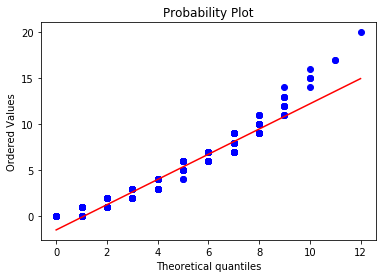

8192
---- Normalized data ----
Mean: 3.9951171875; expected: 4; difference: 0.0048828125
Std: 9.10935115814209; expected: 4; difference: 5.10935115814209
difference between std and mean :5.11423397064209
MWU: MannwhitneyuResult(statistic=122.0, pvalue=0.22428069143091445)
Levene: LeveneResult(statistic=0.19958706442483265, pvalue=0.6580633674272556)


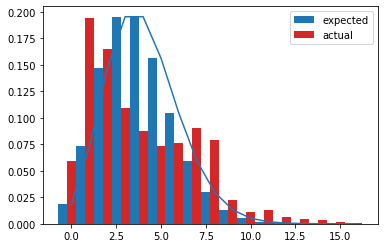

---- Sample data ----
MWU: MannwhitneyuResult(statistic=68.5, pvalue=0.004217964302237853)
Levene: LeveneResult(statistic=0.1259032143711013, pvalue=0.7250460634384241)


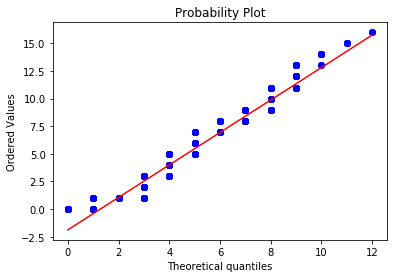

16384
---- Normalized data ----
Mean: 3.997314453125; expected: 4; difference: 0.002685546875
Std: 9.672111928462982; expected: 4; difference: 5.672111928462982
difference between std and mean :5.674797475337982
MWU: MannwhitneyuResult(statistic=171.0, pvalue=0.10882871899210733)
Levene: LeveneResult(statistic=0.03023552937873271, pvalue=0.8628339305273)


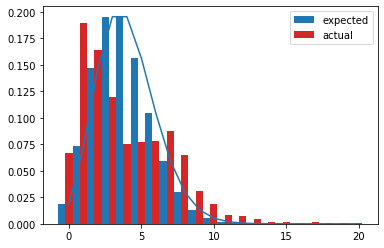

---- Sample data ----
MWU: MannwhitneyuResult(statistic=92.0, pvalue=0.0005398181249765872)
Levene: LeveneResult(statistic=0.017801213960055826, pvalue=0.8945292856049352)


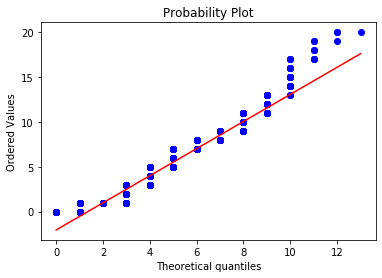

32768
---- Normalized data ----
Mean: 3.99853515625; expected: 4; difference: 0.00146484375
Std: 10.803464651107788; expected: 4; difference: 6.803464651107788
difference between std and mean :6.804929494857788
MWU: MannwhitneyuResult(statistic=234.0, pvalue=0.029082236383509822)
Levene: LeveneResult(statistic=0.007216590878810906, pvalue=0.9326399719414831)


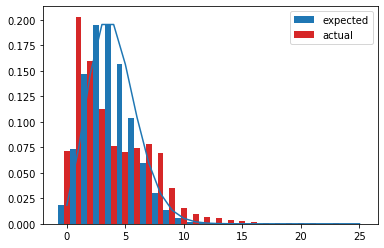

---- Sample data ----
MWU: MannwhitneyuResult(statistic=125.0, pvalue=3.331137878585164e-05)
Levene: LeveneResult(statistic=0.0037851307393466267, pvalue=0.9511876408597415)


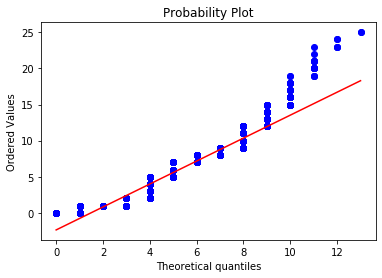

65536
---- Normalized data ----
Mean: 3.99920654296875; expected: 4; difference: 0.00079345703125
Std: 11.84649595245719; expected: 4; difference: 7.84649595245719
difference between std and mean :7.84728940948844
MWU: MannwhitneyuResult(statistic=305.0, pvalue=0.00687042756425226)
Levene: LeveneResult(statistic=0.0019396088615250338, pvalue=0.9650179745518496)


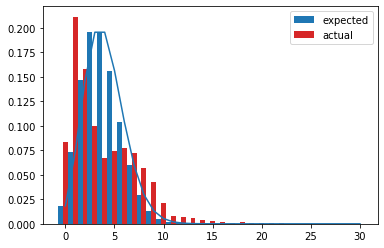

---- Sample data ----
MWU: MannwhitneyuResult(statistic=158.0, pvalue=1.627814640083226e-06)
Levene: LeveneResult(statistic=0.0010265333353761208, pvalue=0.9745468476055728)


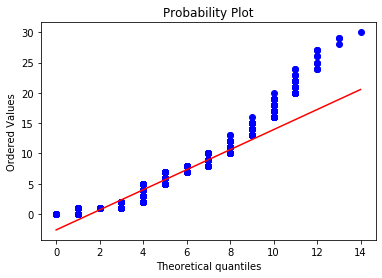

131072
---- Normalized data ----
Mean: 3.99957275390625; expected: 4; difference: 0.00042724609375
Std: 14.135986145585775; expected: 4; difference: 10.135986145585775
difference between std and mean :10.136413391679525
MWU: MannwhitneyuResult(statistic=386.0, pvalue=0.0006366472379299044)
Levene: LeveneResult(statistic=0.0007320914147243734, pvalue=0.9784889764245555)


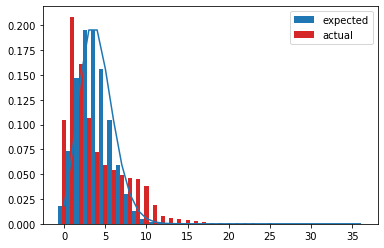

---- Sample data ----
MWU: MannwhitneyuResult(statistic=200.0, pvalue=3.3723742325548526e-08)
Levene: LeveneResult(statistic=0.00040011049180488367, pvalue=0.9840964986342984)


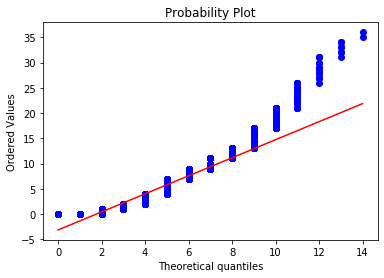

262144
---- Normalized data ----
Mean: 3.9997711181640625; expected: 4; difference: 0.0002288818359375
Std: 16.531997628277168; expected: 4; difference: 12.531997628277168
difference between std and mean :12.532226510113105
MWU: MannwhitneyuResult(statistic=468.0, pvalue=4.097310678168689e-05)
Levene: LeveneResult(statistic=0.00039489928372222685, pvalue=0.9841925506591248)


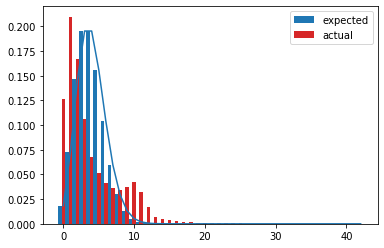

---- Sample data ----
MWU: MannwhitneyuResult(statistic=253.5, pvalue=1.0057994517976455e-09)
Levene: LeveneResult(statistic=0.0002200145758070372, pvalue=0.9882006750639799)


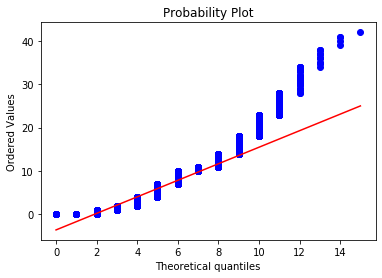

524288
---- Normalized data ----
Mean: 3.9998779296875; expected: 4; difference: 0.0001220703125
Std: 19.141754135489464; expected: 4; difference: 15.141754135489464
difference between std and mean :15.141876205801964
MWU: MannwhitneyuResult(statistic=642.0, pvalue=1.4058992489761387e-05)
Levene: LeveneResult(statistic=0.00016498870890067335, pvalue=0.9897777326624936)


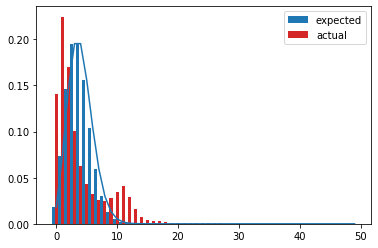

---- Sample data ----
MWU: MannwhitneyuResult(statistic=346.5, pvalue=4.326063517303224e-11)
Levene: LeveneResult(statistic=9.508241420185052e-05, pvalue=0.9922397567584207)


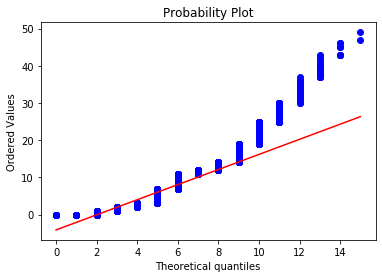

1048576
---- Normalized data ----
Mean: 3.9999351501464844; expected: 4; difference: 6.4849853515625e-05
Std: 22.34499740180036; expected: 4; difference: 18.34499740180036
difference between std and mean :18.345062251653875
MWU: MannwhitneyuResult(statistic=761.0, pvalue=5.018460922675953e-07)
Levene: LeveneResult(statistic=6.731726167969261e-05, pvalue=0.9934682587565052)


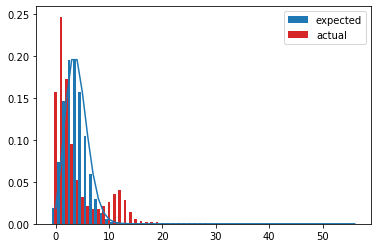

---- Sample data ----
MWU: MannwhitneyuResult(statistic=411.5, pvalue=3.977914995053687e-13)
Levene: LeveneResult(statistic=3.992593480254063e-05, pvalue=0.994969683652696)


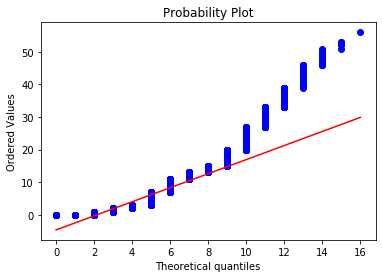

2097152
---- Normalized data ----
Mean: 3.9999656677246094; expected: 4; difference: 3.4332275390625e-05
Std: 26.04090118290333; expected: 4; difference: 22.04090118290333
difference between std and mean :22.04093551517872
MWU: MannwhitneyuResult(statistic=1003.0, pvalue=1.208548977489501e-07)
Levene: LeveneResult(statistic=2.707764279114165e-05, pvalue=0.9958562333502194)


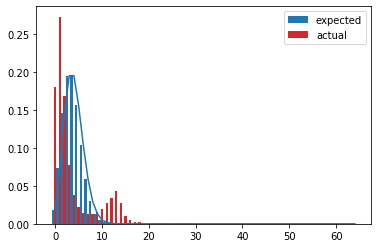

---- Sample data ----
MWU: MannwhitneyuResult(statistic=540.0, pvalue=6.363694896012101e-15)
Levene: LeveneResult(statistic=1.6599129309219912e-05, pvalue=0.9967556082976207)


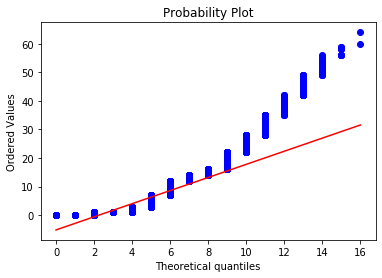

4194304
---- Normalized data ----
Mean: 3.9999818801879883; expected: 4; difference: 1.811981201171875e-05
Std: 29.155703544288375; expected: 4; difference: 25.155703544288375
difference between std and mean :25.155721664100387
MWU: MannwhitneyuResult(statistic=687.0, pvalue=5.473004581549539e-08)
Levene: LeveneResult(statistic=8.388275950358322e-05, pvalue=0.9927087683614584)


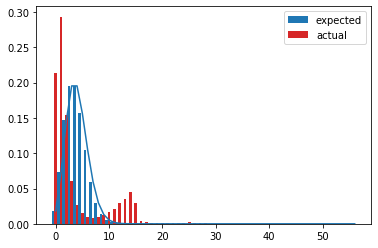

---- Sample data ----
MWU: MannwhitneyuResult(statistic=365.0, pvalue=6.860303598799348e-14)
Levene: LeveneResult(statistic=5.232996152079338e-05, pvalue=0.9942410666389971)


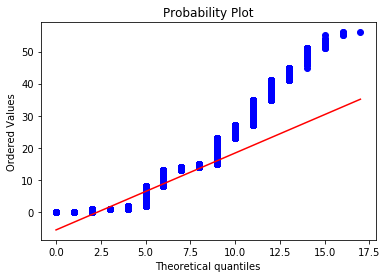

8388608
---- Normalized data ----
Mean: 3.999990463256836; expected: 4; difference: 9.5367431640625e-06
Std: 29.798016548065778; expected: 4; difference: 25.798016548065778
difference between std and mean :25.798026084808942
MWU: MannwhitneyuResult(statistic=818.0, pvalue=8.43538491541779e-10)
Levene: LeveneResult(statistic=2.9123150952092825e-05, pvalue=0.9957025691736073)


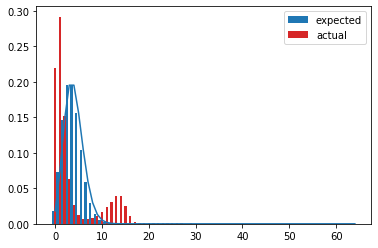

---- Sample data ----
MWU: MannwhitneyuResult(statistic=440.0, pvalue=3.227499650220037e-16)
Levene: LeveneResult(statistic=1.831254560609022e-05, pvalue=0.9965922724734261)


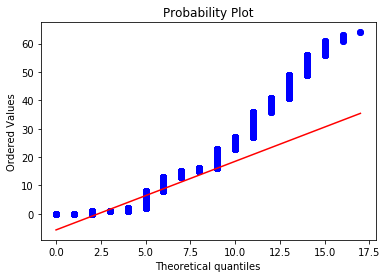

16777216
---- Normalized data ----
Mean: 3.999994993209839; expected: 4; difference: 5.0067901611328125e-06
Std: 30.987214326833445; expected: 4; difference: 26.987214326833445
difference between std and mean :26.987219333623607
MWU: MannwhitneyuResult(statistic=945.0, pvalue=8.5987885506602e-12)
Levene: LeveneResult(statistic=1.9449796614800796e-05, pvalue=0.9964872907967199)


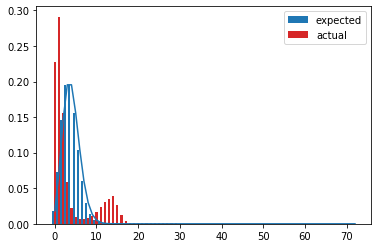

---- Sample data ----
MWU: MannwhitneyuResult(statistic=501.5, pvalue=5.435837718062367e-19)
Levene: LeveneResult(statistic=1.2344201609457596e-05, pvalue=0.997201555568661)


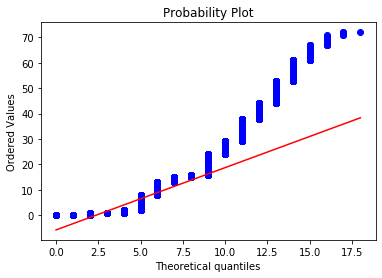

33554432
---- Normalized data ----
Mean: 3.99999737739563; expected: 4; difference: 2.6226043701171875e-06
Std: 32.46257686614302; expected: 4; difference: 28.462576866143017
difference between std and mean :28.462579488747387
MWU: MannwhitneyuResult(statistic=1092.0, pvalue=4.199561603612497e-14)
Levene: LeveneResult(statistic=9.28106868997029e-06, pvalue=0.9975730089444522)


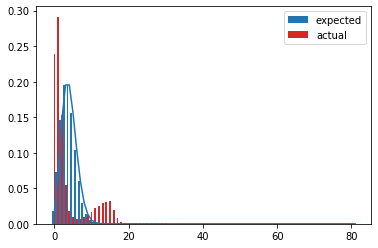

---- Sample data ----
MWU: MannwhitneyuResult(statistic=580.5, pvalue=7.04897855478709e-22)
Levene: LeveneResult(statistic=5.934553751482584e-06, pvalue=0.9980592774159094)


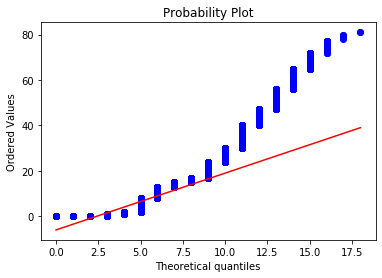

In [314]:
for N in Ns_c4:
    print(N)
    analize_result(occs_c4[N],N,plot=True,l=4)
    analize_result_2(occs_c4[N],plot=True,l=4)

In [315]:
Ns_c1 = [2**i for i in range(10,26)]
occs_c1 = get_amounts_for_ns(Ns2,lamb=1,use_seq='champernowne')

1024
---- Normalized data ----
Mean: 0.9912109375; expected: 1; difference: 0.0087890625
Std: 0.9637899398803711; expected: 1; difference: 0.036210060119628906
difference between std and mean :0.027420997619628906
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=1.0698708591528496e-05, pvalue=0.9974439609377667)


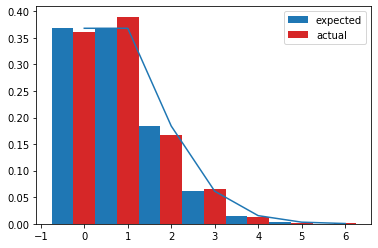

---- Sample data ----
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=0.00011013668697097927, pvalue=0.9917991283627486)


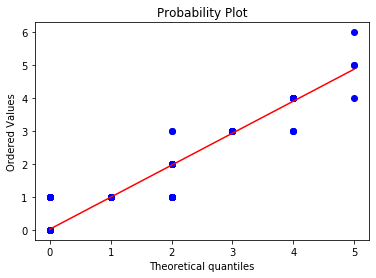

2048
---- Normalized data ----
Mean: 0.9951171875; expected: 1; difference: 0.0048828125
Std: 1.2148199081420898; expected: 1; difference: 0.21481990814208984
difference between std and mean :0.21970272064208984
MWU: MannwhitneyuResult(statistic=47.0, pvalue=0.42499762424381904)
Levene: LeveneResult(statistic=0.0001639674369567115, pvalue=0.9899242458612219)


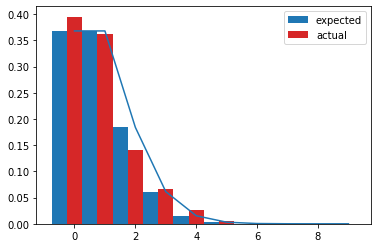

---- Sample data ----
MWU: MannwhitneyuResult(statistic=42.0, pvalue=0.28383840523588394)
Levene: LeveneResult(statistic=0.00014677010221671164, pvalue=0.9904672353771736)


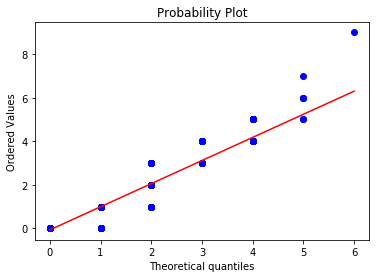

4096
---- Normalized data ----
Mean: 0.997314453125; expected: 1; difference: 0.002685546875
Std: 1.5710377097129822; expected: 1; difference: 0.5710377097129822
difference between std and mean :0.5737232565879822
MWU: MannwhitneyuResult(statistic=75.0, pvalue=0.32212122192374565)
Levene: LeveneResult(statistic=0.0001544030682276763, pvalue=0.9901885365934217)


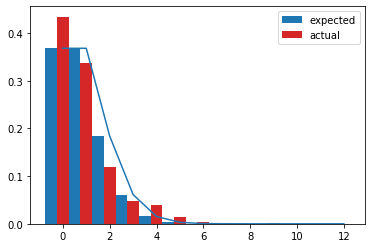

---- Sample data ----
MWU: MannwhitneyuResult(statistic=67.0, pvalue=0.18662387135503128)
Levene: LeveneResult(statistic=0.00017782529138620602, pvalue=0.9894706678968009)


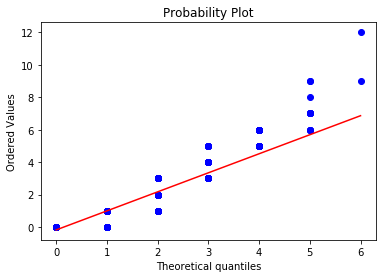

8192
---- Normalized data ----
Mean: 0.99853515625; expected: 1; difference: 0.00146484375
Std: 1.876950979232788; expected: 1; difference: 0.8769509792327881
difference between std and mean :0.8784158229827881
MWU: MannwhitneyuResult(statistic=41.0, pvalue=0.2601830104482655)
Levene: LeveneResult(statistic=0.012594656726337753, pvalue=0.9118863424985811)


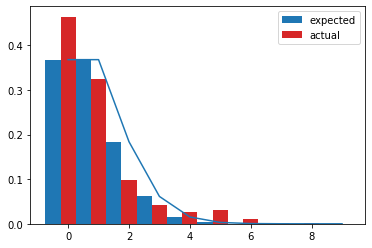

---- Sample data ----
MWU: MannwhitneyuResult(statistic=40.0, pvalue=0.23600427883305353)
Levene: LeveneResult(statistic=0.012694878813457764, pvalue=0.9115380109091266)


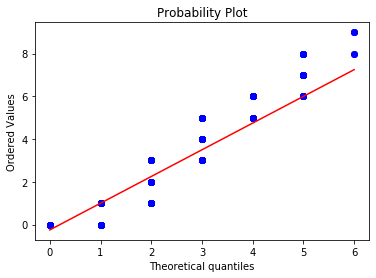

16384
---- Normalized data ----
Mean: 0.99920654296875; expected: 1; difference: 0.00079345703125
Std: 1.9963982962071896; expected: 1; difference: 0.9963982962071896
difference between std and mean :0.9971917532384396
MWU: MannwhitneyuResult(statistic=61.0, pvalue=0.11902185854256181)
Levene: LeveneResult(statistic=0.00117377645873766, pvalue=0.9729528398748535)


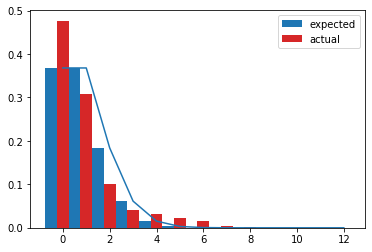

---- Sample data ----
MWU: MannwhitneyuResult(statistic=60.5, pvalue=0.11259866058489898)
Levene: LeveneResult(statistic=0.001197457833199919, pvalue=0.972681471404995)


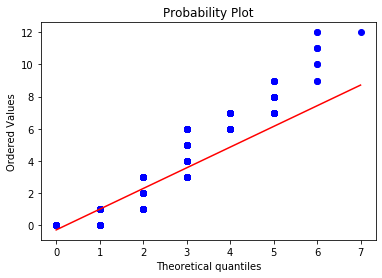

32768
---- Normalized data ----
Mean: 0.99957275390625; expected: 1; difference: 0.00042724609375
Std: 2.1852415166795254; expected: 1; difference: 1.1852415166795254
difference between std and mean :1.1856687627732754
MWU: MannwhitneyuResult(statistic=91.0, pvalue=0.03393072617650289)
Levene: LeveneResult(statistic=3.1247750960218544e-05, pvalue=0.9955745775231563)


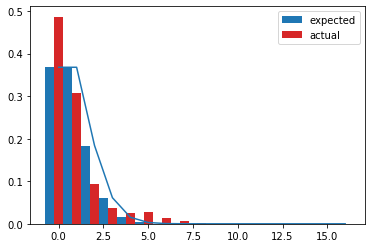

---- Sample data ----
MWU: MannwhitneyuResult(statistic=90.0, pvalue=0.03019260489622316)
Levene: LeveneResult(statistic=3.153568972696508e-05, pvalue=0.9955542350202032)


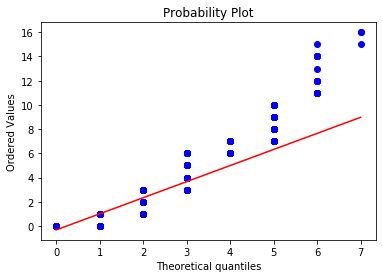

65536
---- Normalized data ----
Mean: 0.9997711181640625; expected: 1; difference: 0.0002288818359375
Std: 2.3702849817927927; expected: 1; difference: 1.3702849817927927
difference between std and mean :1.3705138636287302
MWU: MannwhitneyuResult(statistic=123.0, pvalue=0.00733342544780033)
Levene: LeveneResult(statistic=7.167880912292756e-06, pvalue=0.9978771424034737)


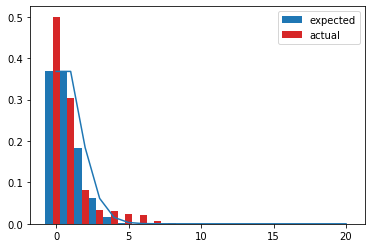

---- Sample data ----
MWU: MannwhitneyuResult(statistic=118.0, pvalue=0.004590536790179613)
Levene: LeveneResult(statistic=7.178364160576772e-06, pvalue=0.9978755906017757)


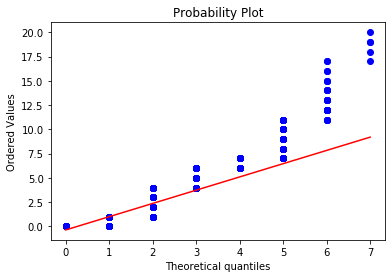

131072
---- Normalized data ----
Mean: 0.9998779296875; expected: 1; difference: 0.0001220703125
Std: 2.782562240958214; expected: 1; difference: 1.7825622409582138
difference between std and mean :1.7826843112707138
MWU: MannwhitneyuResult(statistic=162.0, pvalue=0.0006573522529824548)
Levene: LeveneResult(statistic=2.0574759680260487e-06, pvalue=0.9988612301309084)


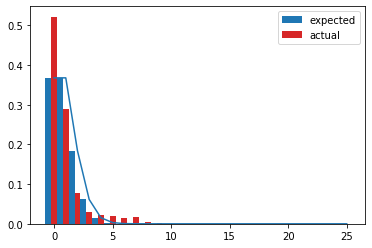

---- Sample data ----
MWU: MannwhitneyuResult(statistic=162.5, pvalue=0.0005538316090574928)
Levene: LeveneResult(statistic=2.0555572793763948e-06, pvalue=0.9988617612310883)


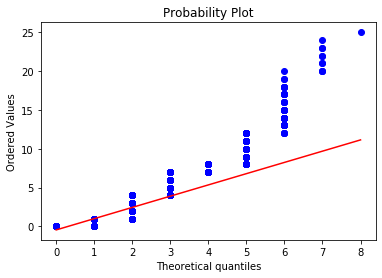

262144
---- Normalized data ----
Mean: 0.9999351501464844; expected: 1; difference: 6.4849853515625e-05
Std: 3.2263755756284818; expected: 1; difference: 2.2263755756284818
difference between std and mean :2.2264404254819974
MWU: MannwhitneyuResult(statistic=203.0, pvalue=4.806501554569991e-05)
Levene: LeveneResult(statistic=1.095010218297123e-06, pvalue=0.9991685433884085)


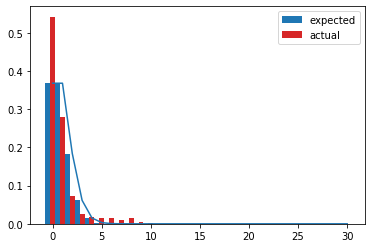

---- Sample data ----
MWU: MannwhitneyuResult(statistic=204.5, pvalue=3.795730643150767e-05)
Levene: LeveneResult(statistic=1.0935727319092753e-06, pvalue=0.9991690893206571)


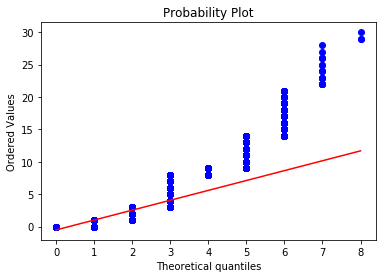

524288
---- Normalized data ----
Mean: 0.9999656677246094; expected: 1; difference: 3.4332275390625e-05
Std: 3.7450866687431694; expected: 1; difference: 2.7450866687431694
difference between std and mean :2.74512100101856
MWU: MannwhitneyuResult(statistic=310.0, pvalue=2.6297885140884486e-05)
Levene: LeveneResult(statistic=4.5570802034371344e-07, pvalue=0.9994632458083925)


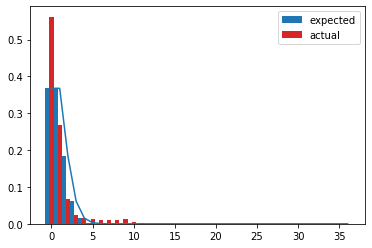

---- Sample data ----
MWU: MannwhitneyuResult(statistic=280.0, pvalue=3.3009813381174734e-06)
Levene: LeveneResult(statistic=4.561194325391503e-07, pvalue=0.9994630035665368)


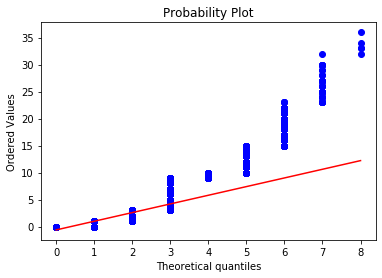

1048576
---- Normalized data ----
Mean: 0.9999818801879883; expected: 1; difference: 1.811981201171875e-05
Std: 4.38926982846806; expected: 1; difference: 3.38926982846806
difference between std and mean :3.3892879482800717
MWU: MannwhitneyuResult(statistic=376.0, pvalue=1.1041547957272305e-06)
Levene: LeveneResult(statistic=2.6215551264870583e-07, pvalue=0.9995926881722259)


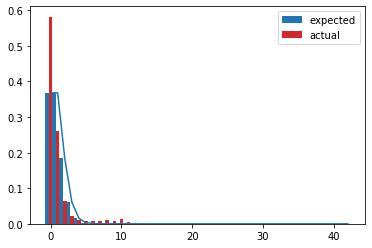

---- Sample data ----
MWU: MannwhitneyuResult(statistic=340.0, pvalue=8.780505196083263e-08)
Levene: LeveneResult(statistic=2.6225978454003663e-07, pvalue=0.9995926071687178)


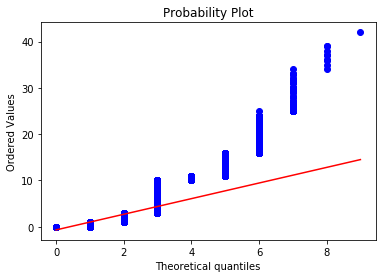

2097152
---- Normalized data ----
Mean: 0.9999904632568359; expected: 1; difference: 9.5367431640625e-06
Std: 5.1826639174505535; expected: 1; difference: 4.1826639174505535
difference between std and mean :4.182673454193718
MWU: MannwhitneyuResult(statistic=533.0, pvalue=3.910287901172046e-07)
Levene: LeveneResult(statistic=1.0011267521635185e-07, pvalue=0.9997481878404344)


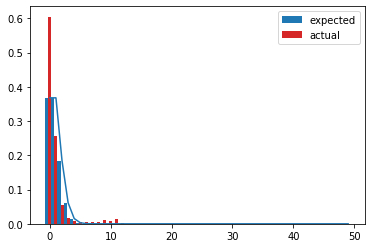

---- Sample data ----
MWU: MannwhitneyuResult(statistic=453.0, pvalue=4.7033538047599904e-09)
Levene: LeveneResult(statistic=1.0011536633777113e-07, pvalue=0.9997481844332914)


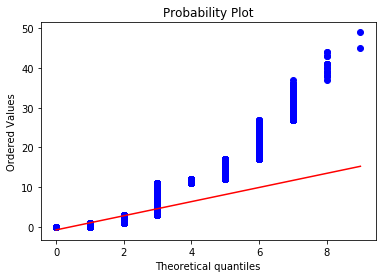

4194304
---- Normalized data ----
Mean: 0.9999949932098389; expected: 1; difference: 5.0067901611328125e-06
Std: 5.982516050313675; expected: 1; difference: 4.982516050313675
difference between std and mean :4.9825210571038365
MWU: MannwhitneyuResult(statistic=306.0, pvalue=4.700470884890722e-08)
Levene: LeveneResult(statistic=4.482743174850384e-07, pvalue=0.9994673775749704)


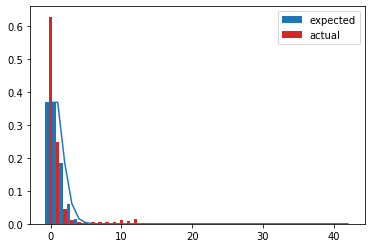

---- Sample data ----
MWU: MannwhitneyuResult(statistic=307.0, pvalue=2.0509265503535895e-08)
Levene: LeveneResult(statistic=4.4828215799892827e-07, pvalue=0.9994673729266601)


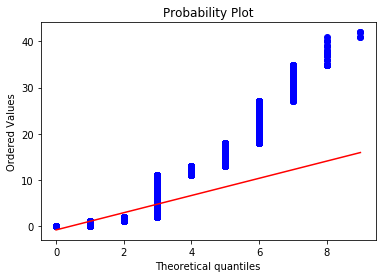

8388608
---- Normalized data ----
Mean: 0.9999973773956299; expected: 1; difference: 2.6226043701171875e-06
Std: 6.208072900765218; expected: 1; difference: 5.208072900765218
difference between std and mean :5.208075523369588
MWU: MannwhitneyuResult(statistic=372.0, pvalue=7.261149324117785e-10)
Levene: LeveneResult(statistic=9.324229774497105e-08, pvalue=0.9997569818890457)


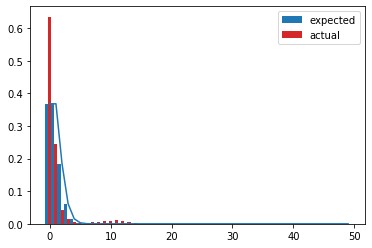

---- Sample data ----
MWU: MannwhitneyuResult(statistic=367.5, pvalue=1.8133677067310473e-10)
Levene: LeveneResult(statistic=9.322573243107595e-08, pvalue=0.999757003455587)


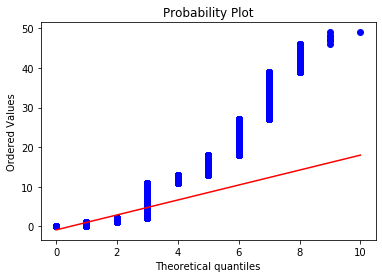

16777216
---- Normalized data ----
Mean: 0.9999986290931702; expected: 1; difference: 1.3709068298339844e-06
Std: 6.497563064096477; expected: 1; difference: 5.497563064096477
difference between std and mean :5.497564435003307
MWU: MannwhitneyuResult(statistic=436.0, pvalue=8.327000745722046e-12)
Levene: LeveneResult(statistic=5.485746811798489e-08, pvalue=0.9998135387832634)


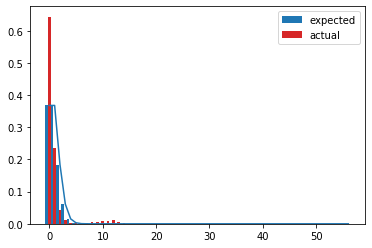

---- Sample data ----
MWU: MannwhitneyuResult(statistic=438.0, pvalue=1.9877215994225375e-12)
Levene: LeveneResult(statistic=5.485559158967322e-08, pvalue=0.9998135419531667)


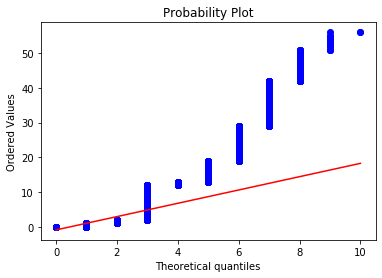

33554432
---- Normalized data ----
Mean: 0.9999992847442627; expected: 1; difference: 7.152557373046875e-07
Std: 6.846365749835456; expected: 1; difference: 5.846365749835456
difference between std and mean :5.846366465091194
MWU: MannwhitneyuResult(statistic=515.0, pvalue=5.182194125894168e-14)
Levene: LeveneResult(statistic=3.034923181833937e-08, pvalue=0.9998612714790263)


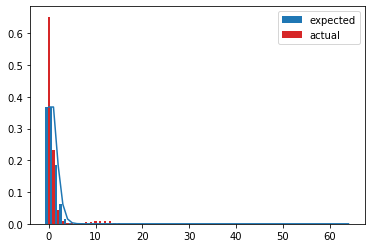

---- Sample data ----
MWU: MannwhitneyuResult(statistic=512.0, pvalue=5.279585438459663e-15)
Levene: LeveneResult(statistic=3.0349979750372056e-08, pvalue=0.9998612697901073)


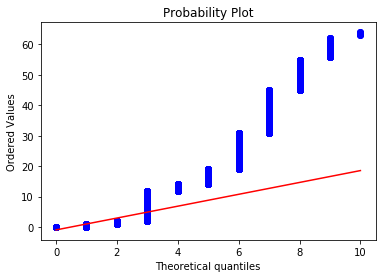

In [316]:
for N in Ns_c1:
    print(N)
    analize_result(occs_c1[N],N,plot=True,l=1)
    analize_result_2(occs_c1[N],plot=True,l=1)

### PRNG with lambda = 1 from N=2ˆ10 up to 2ˆ26

In [324]:
perform_test(seq='prng',lamb=1)

1024
---- Normalized data ----
Mean: 0.9912109375; expected: 1; difference: 0.0087890625
Std: 1.022383689880371; expected: 1; difference: 0.022383689880371094
difference between std and mean :0.031172752380371094
MWU: MannwhitneyuResult(statistic=18.0, pvalue=0.46803733853330987)
Levene: LeveneResult(statistic=0.0026170777112080375, pvalue=0.9602075594239242)


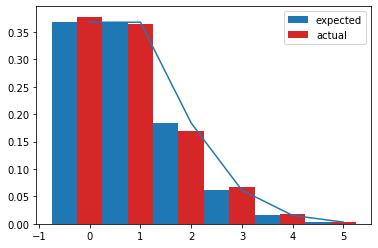

---- Sample data ----
MWU: MannwhitneyuResult(statistic=17.0, pvalue=0.30805209802298494)
Levene: LeveneResult(statistic=0.01811298492453336, pvalue=0.8953713681742128)


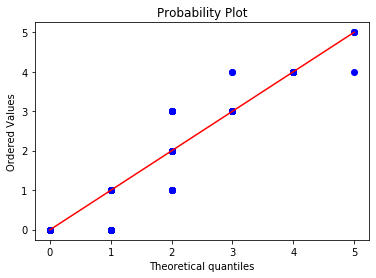

2048
---- Normalized data ----
Mean: 0.9951171875; expected: 1; difference: 0.0048828125
Std: 0.9521245956420898; expected: 1; difference: 0.047875404357910156
difference between std and mean :0.042992591857910156
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491077413427273)
Levene: LeveneResult(statistic=0.00021377047256378718, pvalue=0.9885749070338817)


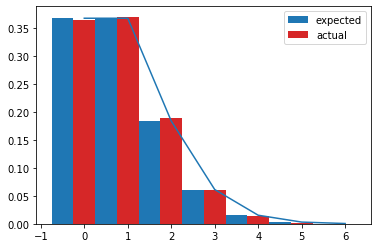

---- Sample data ----
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.449051905879462)
Levene: LeveneResult(statistic=4.341213600732551e-06, pvalue=0.9983717995016883)


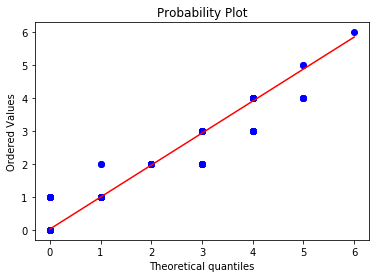

4096
---- Normalized data ----
Mean: 0.997314453125; expected: 1; difference: 0.002685546875
Std: 0.9811939597129822; expected: 1; difference: 0.018806040287017822
difference between std and mean :0.016120493412017822
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=8.64119729123354e-05, pvalue=0.9927358829957941)


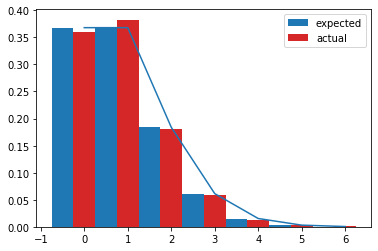

---- Sample data ----
MWU: MannwhitneyuResult(statistic=24.5, pvalue=0.47450184322152916)
Levene: LeveneResult(statistic=0.000636735979808318, pvalue=0.9802833822979098)


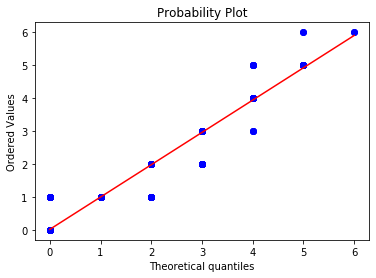

8192
---- Normalized data ----
Mean: 0.99853515625; expected: 1; difference: 0.00146484375
Std: 0.9843728542327881; expected: 1; difference: 0.015627145767211914
difference between std and mean :0.014162302017211914
MWU: MannwhitneyuResult(statistic=40.0, pvalue=0.5)
Levene: LeveneResult(statistic=2.3167888964496023e-07, pvalue=0.9996219042280201)


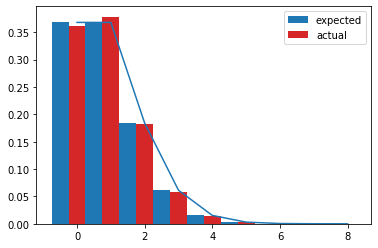

---- Sample data ----
MWU: MannwhitneyuResult(statistic=37.0, pvalue=0.3952764999744447)
Levene: LeveneResult(statistic=8.594989155701791e-06, pvalue=0.9976970706586771)


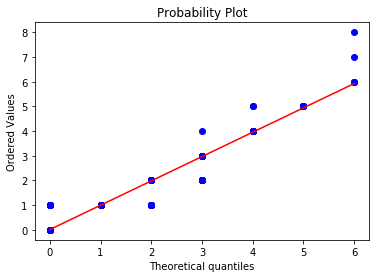

16384
---- Normalized data ----
Mean: 0.99920654296875; expected: 1; difference: 0.00079345703125
Std: 1.0028680227696896; expected: 1; difference: 0.00286802276968956
difference between std and mean :0.00366147980093956
MWU: MannwhitneyuResult(statistic=22.0, pvalue=0.3990403147291498)
Levene: LeveneResult(statistic=1.5356545482604595e-06, pvalue=0.999031612241479)


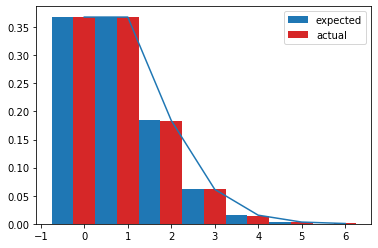

---- Sample data ----
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491633936346191)
Levene: LeveneResult(statistic=2.6985096502247498e-05, pvalue=0.9959405937315557)


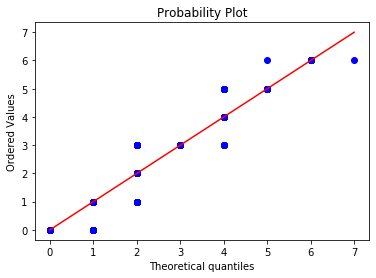

32768
---- Normalized data ----
Mean: 0.99957275390625; expected: 1; difference: 0.00042724609375
Std: 0.9979246221482754; expected: 1; difference: 0.0020753778517246246
difference between std and mean :0.0016481317579746246
MWU: MannwhitneyuResult(statistic=22.0, pvalue=0.3990403147291498)
Levene: LeveneResult(statistic=6.046152490761679e-09, pvalue=0.9999392365867553)


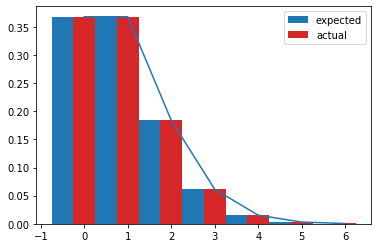

---- Sample data ----
MWU: MannwhitneyuResult(statistic=25.0, pvalue=0.38616872064639024)
Levene: LeveneResult(statistic=0.015781542450962385, pvalue=0.9019510807365768)


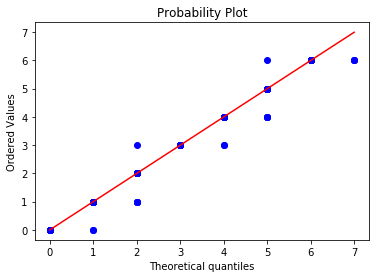

65536
---- Normalized data ----
Mean: 0.9997711181640625; expected: 1; difference: 0.0002288818359375
Std: 0.9970244837459177; expected: 1; difference: 0.002975516254082322
difference between std and mean :0.002746634418144822
MWU: MannwhitneyuResult(statistic=31.0, pvalue=0.4790455641133508)
Levene: LeveneResult(statistic=2.1699862682593853e-06, pvalue=0.998845431558954)


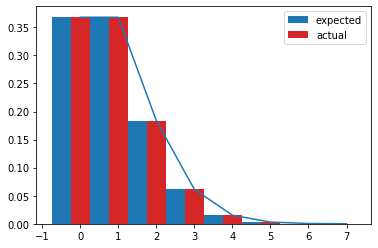

---- Sample data ----
MWU: MannwhitneyuResult(statistic=30.5, pvalue=0.45814889899892497)
Levene: LeveneResult(statistic=1.0054568532485083e-05, pvalue=0.9975147373257887)


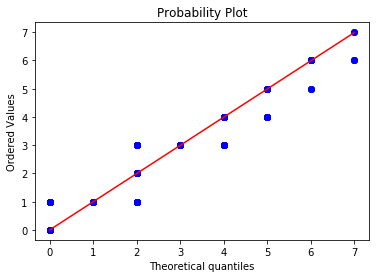

131072
---- Normalized data ----
Mean: 0.9998779296875; expected: 1; difference: 0.0001220703125
Std: 0.9997100681066513; expected: 1; difference: 0.00028993189334869385
difference between std and mean :0.00016786158084869385
MWU: MannwhitneyuResult(statistic=40.0, pvalue=0.5)
Levene: LeveneResult(statistic=7.205281415455876e-07, pvalue=0.9993332177560078)


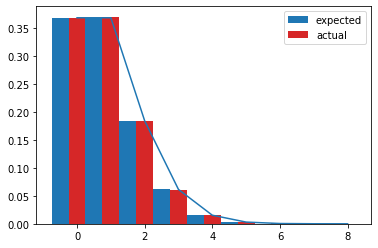

---- Sample data ----
MWU: MannwhitneyuResult(statistic=38.0, pvalue=0.429909602527079)
Levene: LeveneResult(statistic=1.4840302146081324e-06, pvalue=0.9990430706717879)


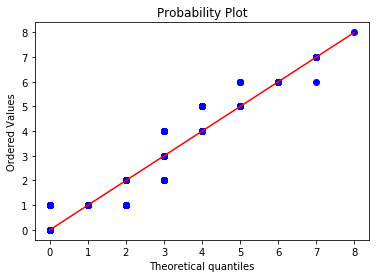

262144
---- Normalized data ----
Mean: 0.9999351501464844; expected: 1; difference: 6.4849853515625e-05
Std: 0.9958152728941059; expected: 1; difference: 0.004184727105894126
difference between std and mean :0.004119877252378501
MWU: MannwhitneyuResult(statistic=47.0, pvalue=0.42502551244863873)
Levene: LeveneResult(statistic=2.817461267648492e-08, pvalue=0.9998679190314844)


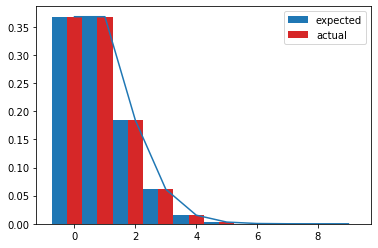

---- Sample data ----
MWU: MannwhitneyuResult(statistic=50.0, pvalue=0.48491364651063584)
Levene: LeveneResult(statistic=2.175656678335918e-09, pvalue=0.9999632965773781)


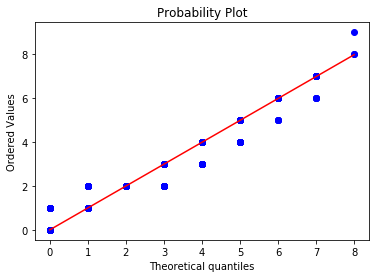

524288
---- Normalized data ----
Mean: 0.9999656677246094; expected: 1; difference: 3.4332275390625e-05
Std: 1.0002288806572324; expected: 1; difference: 0.0002288806572323665
difference between std and mean :0.0002632129326229915
MWU: MannwhitneyuResult(statistic=40.0, pvalue=0.5)
Levene: LeveneResult(statistic=8.845318563554477e-08, pvalue=0.9997663771389917)


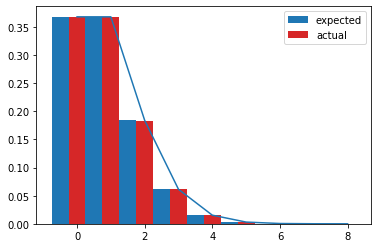

---- Sample data ----
MWU: MannwhitneyuResult(statistic=39.5, pvalue=0.4823829020325924)
Levene: LeveneResult(statistic=1.5755720604420935e-09, pvalue=0.9999688198866565)


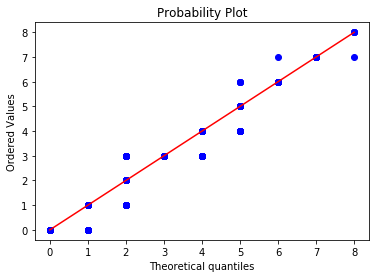

1048576
---- Normalized data ----
Mean: 0.9999818801879883; expected: 1; difference: 1.811981201171875e-05
Std: 1.0010480877454029; expected: 1; difference: 0.0010480877454028814
difference between std and mean :0.0010662075574146002
MWU: MannwhitneyuResult(statistic=49.0, pvalue=0.4849193207024165)
Levene: LeveneResult(statistic=3.959420669815077e-09, pvalue=0.9999504861023633)


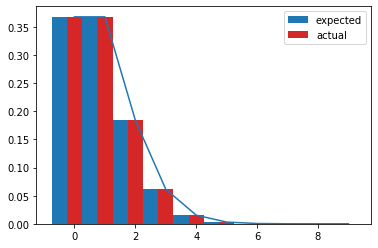

---- Sample data ----
MWU: MannwhitneyuResult(statistic=49.0, pvalue=0.4849249884965778)
Levene: LeveneResult(statistic=1.7229249141334907e-08, pvalue=0.9998967132836541)


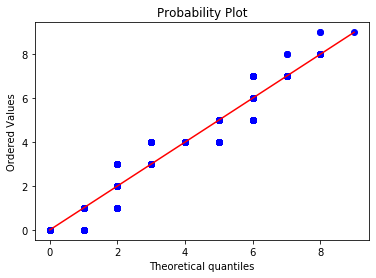

2097152
---- Normalized data ----
Mean: 0.9999904632568359; expected: 1; difference: 9.5367431640625e-06
Std: 1.0031042098089524; expected: 1; difference: 0.0031042098089524295
difference between std and mean :0.003113746552116492
MWU: MannwhitneyuResult(statistic=59.0, pvalue=0.47381488164049806)
Levene: LeveneResult(statistic=1.1348662497788992e-08, pvalue=0.9999160567057859)


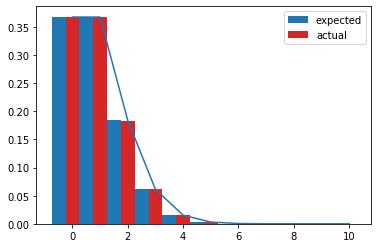

---- Sample data ----
MWU: MannwhitneyuResult(statistic=59.5, pvalue=0.48689297622562533)
Levene: LeveneResult(statistic=9.54173747115495e-11, pvalue=0.9999923028210215)


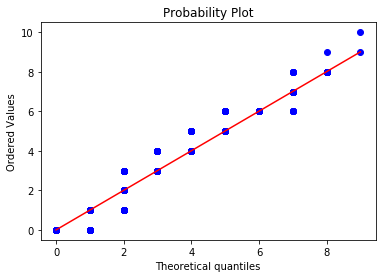

4194304
---- Normalized data ----
Mean: 0.9999949932098389; expected: 1; difference: 5.0067901611328125e-06
Std: 1.0020730495202201; expected: 1; difference: 0.0020730495202201382
difference between std and mean :0.002078056310381271
MWU: MannwhitneyuResult(statistic=50.0, pvalue=0.4849193207024165)
Levene: LeveneResult(statistic=6.06645987803252e-08, pvalue=0.9998061887654127)


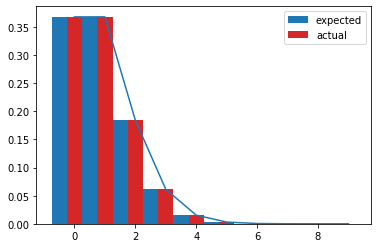

---- Sample data ----
MWU: MannwhitneyuResult(statistic=49.5, pvalue=0.3623427265788608)
Levene: LeveneResult(statistic=0.018754030037484975, pvalue=0.8925147212846375)


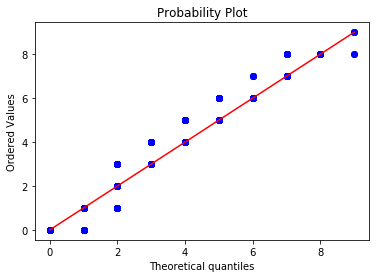

8388608
---- Normalized data ----
Mean: 0.9999973773956299; expected: 1; difference: 2.6226043701171875e-06
Std: 0.9999969005515937; expected: 1; difference: 3.0994484062629724e-06
difference between std and mean :4.768440361457849e-07
MWU: MannwhitneyuResult(statistic=59.0, pvalue=0.47381488164049806)
Levene: LeveneResult(statistic=6.825001722074463e-09, pvalue=0.9999349023994546)


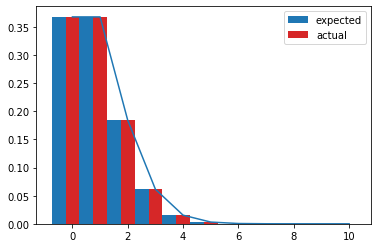

---- Sample data ----
MWU: MannwhitneyuResult(statistic=58.5, pvalue=0.46075757715113363)
Levene: LeveneResult(statistic=3.0962368310171474e-09, pvalue=0.9999561539267031)


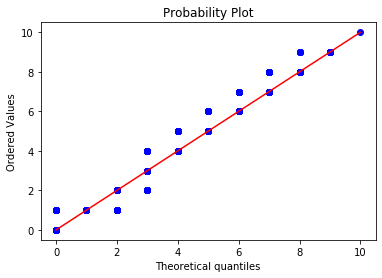

16777216
---- Normalized data ----
Mean: 0.9999986290931702; expected: 1; difference: 1.3709068298339844e-06
Std: 1.0002638697605413; expected: 1; difference: 0.00026386976054126876
difference between std and mean :0.00026524066737110275
MWU: MannwhitneyuResult(statistic=59.0, pvalue=0.47381488164049806)
Levene: LeveneResult(statistic=1.415051907729911e-09, pvalue=0.9999703585178918)


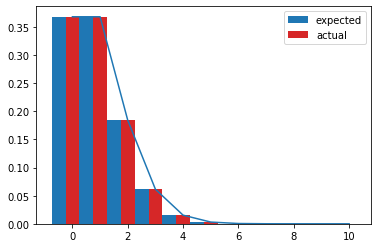

---- Sample data ----
MWU: MannwhitneyuResult(statistic=59.0, pvalue=0.47382226481129724)
Levene: LeveneResult(statistic=2.8206139460102948e-09, pvalue=0.9999581509735976)


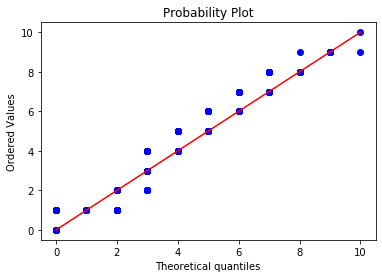

33554432
---- Normalized data ----
Mean: 0.9999992847442627; expected: 1; difference: 7.152557373046875e-07
Std: 0.9999827742571481; expected: 1; difference: 1.7225742851900705e-05
difference between std and mean :1.6510487114596017e-05
MWU: MannwhitneyuResult(statistic=60.0, pvalue=0.5)
Levene: LeveneResult(statistic=6.657249554756807e-10, pvalue=0.9999796688871376)


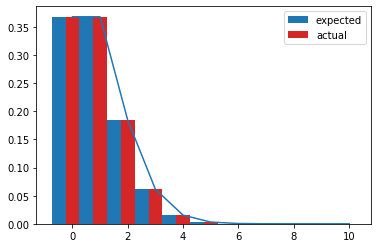

---- Sample data ----
MWU: MannwhitneyuResult(statistic=60.0, pvalue=0.5)
Levene: LeveneResult(statistic=5.494633956428045e-11, pvalue=0.9999941590128245)


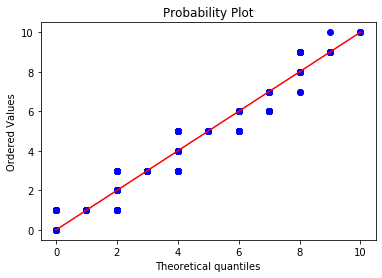

In [325]:
for N in Ns_p1:
    print(N)
    analize_result(occs_p1[N],N,plot=True,l=1)
    analize_result_2(occs_p1[N],plot=True,l=1)

### PRNG with lambda = 4 from N=2ˆ10 up to 2ˆ26

1024
---- Normalized data ----
Mean: 3.97265625; expected: 4; difference: 0.02734375
Std: 3.9640960693359375; expected: 4; difference: 0.0359039306640625
difference between std and mean :0.0085601806640625
MWU: MannwhitneyuResult(statistic=59.0, pvalue=0.47379269458935785)
Levene: LeveneResult(statistic=2.0586821689308867e-06, pvalue=0.9988694022136186)


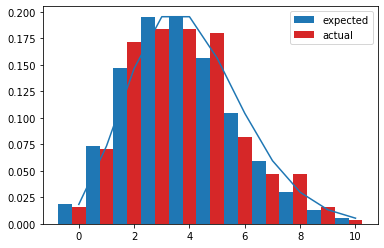

---- Sample data ----
MWU: MannwhitneyuResult(statistic=38.0, pvalue=0.07295883112207359)
Levene: LeveneResult(statistic=0.3989652062467366, pvalue=0.5347778183741716)


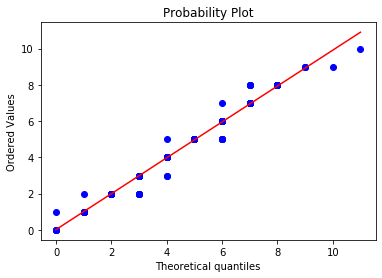

2048
---- Normalized data ----
Mean: 3.984375; expected: 4; difference: 0.015625
Std: 3.421630859375; expected: 4; difference: 0.578369140625
difference between std and mean :0.562744140625
MWU: MannwhitneyuResult(statistic=58.0, pvalue=0.4477424507327276)
Levene: LeveneResult(statistic=0.019681888414735643, pvalue=0.8898324569821794)


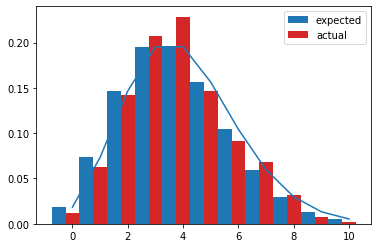

---- Sample data ----
MWU: MannwhitneyuResult(statistic=39.5, pvalue=0.08691074364749757)
Levene: LeveneResult(statistic=0.34402132700028826, pvalue=0.5640794387268236)


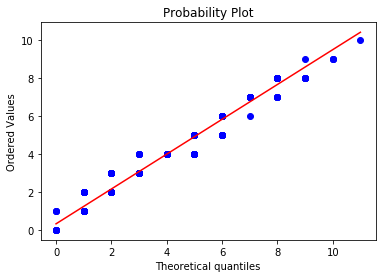

4096
---- Normalized data ----
Mean: 3.9912109375; expected: 4; difference: 0.0087890625
Std: 3.795821189880371; expected: 4; difference: 0.2041788101196289
difference between std and mean :0.1953897476196289
MWU: MannwhitneyuResult(statistic=98.0, pvalue=0.4908330613926762)
Levene: LeveneResult(statistic=0.010546515400581316, pvalue=0.9189920563200986)


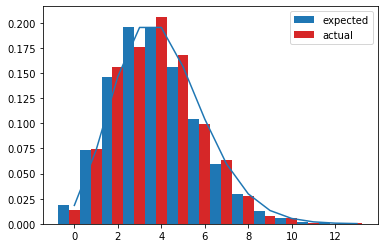

---- Sample data ----
MWU: MannwhitneyuResult(statistic=61.0, pvalue=0.044044319631627124)
Levene: LeveneResult(statistic=0.045883512304596676, pvalue=0.8320587586926391)


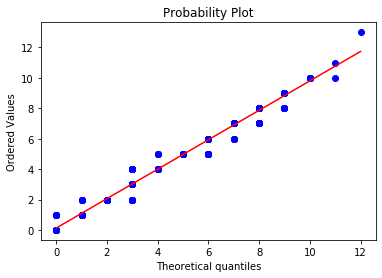

8192
---- Normalized data ----
Mean: 3.9951171875; expected: 4; difference: 0.0048828125
Std: 3.78024959564209; expected: 4; difference: 0.21975040435791016
difference between std and mean :0.21486759185791016
MWU: MannwhitneyuResult(statistic=81.0, pvalue=0.43884477389518206)
Levene: LeveneResult(statistic=0.0001829173185443645, pvalue=0.9893209876541839)


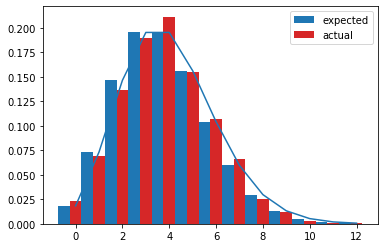

---- Sample data ----
MWU: MannwhitneyuResult(statistic=52.0, pvalue=0.049346989061694865)
Levene: LeveneResult(statistic=0.13859741326360075, pvalue=0.7129466017758725)


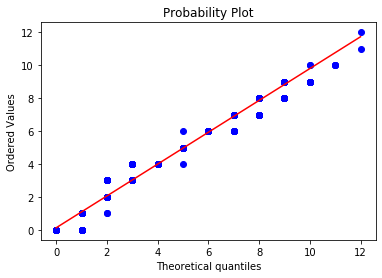

16384
---- Normalized data ----
Mean: 3.997314453125; expected: 4; difference: 0.002685546875
Std: 4.180412709712982; expected: 4; difference: 0.18041270971298218
difference between std and mean :0.18309825658798218
MWU: MannwhitneyuResult(statistic=98.0, pvalue=0.4908330613926762)
Levene: LeveneResult(statistic=0.0005360088199901441, pvalue=0.9817059079205402)


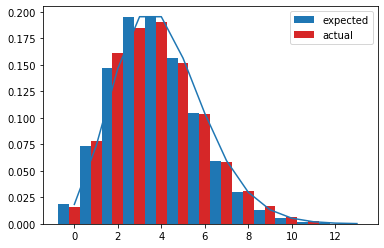

---- Sample data ----
MWU: MannwhitneyuResult(statistic=58.0, pvalue=0.033623447957292885)
Levene: LeveneResult(statistic=0.07375481388024115, pvalue=0.7880910166705082)


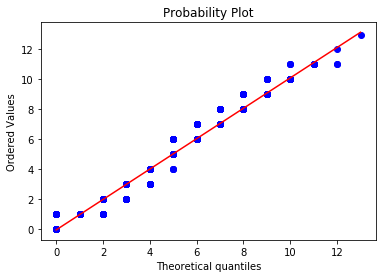

32768
---- Normalized data ----
Mean: 3.99853515625; expected: 4; difference: 0.00146484375
Std: 4.023923635482788; expected: 4; difference: 0.023923635482788086
difference between std and mean :0.025388479232788086
MWU: MannwhitneyuResult(statistic=97.0, pvalue=0.4908343159714798)
Levene: LeveneResult(statistic=2.8340822759460706e-05, pvalue=0.9957930313324879)


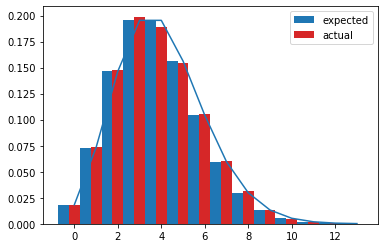

---- Sample data ----
MWU: MannwhitneyuResult(statistic=56.0, pvalue=0.027327389303882357)
Levene: LeveneResult(statistic=0.06895180264828649, pvalue=0.7949386159180313)


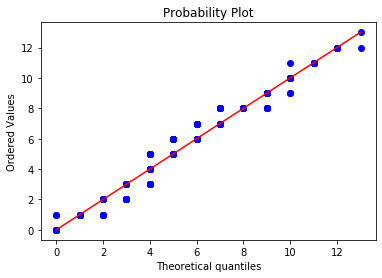

65536
---- Normalized data ----
Mean: 3.99920654296875; expected: 4; difference: 0.00079345703125
Std: 3.9374383352696896; expected: 4; difference: 0.06256166473031044
difference between std and mean :0.06176820769906044
MWU: MannwhitneyuResult(statistic=111.0, pvalue=0.4834555492223808)
Levene: LeveneResult(statistic=0.00022598482963857148, pvalue=0.9881126251697799)


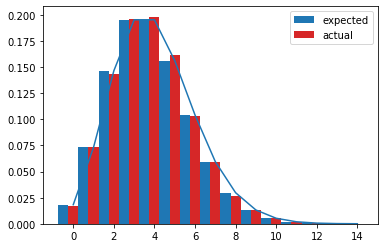

---- Sample data ----
MWU: MannwhitneyuResult(statistic=65.0, pvalue=0.024897116994230337)
Levene: LeveneResult(statistic=0.03537413736884763, pvalue=0.8521702845833533)


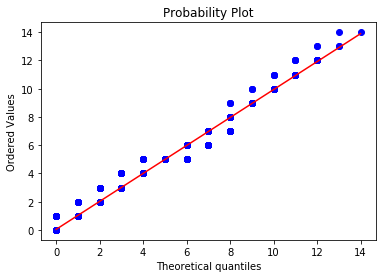

131072
---- Normalized data ----
Mean: 3.99957275390625; expected: 4; difference: 0.00042724609375
Std: 3.9620969854295254; expected: 4; difference: 0.037903014570474625
difference between std and mean :0.037475768476724625
MWU: MannwhitneyuResult(statistic=128.0, pvalue=0.4924819045390597)
Levene: LeveneResult(statistic=1.4804038475025975e-05, pvalue=0.9969555376653605)


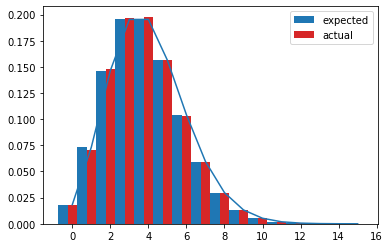

---- Sample data ----
MWU: MannwhitneyuResult(statistic=72.0, pvalue=0.01751439769803)
Levene: LeveneResult(statistic=0.019090971650791932, pvalue=0.8910292694546889)


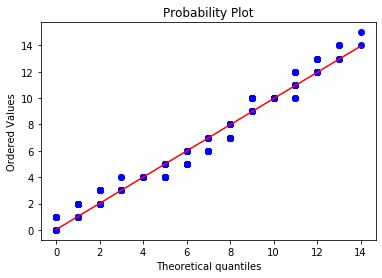

262144
---- Normalized data ----
Mean: 3.9997711181640625; expected: 4; difference: 0.0002288818359375
Std: 3.9815215540584177; expected: 4; difference: 0.018478445941582322
difference between std and mean :0.018249564105644822
MWU: MannwhitneyuResult(statistic=98.0, pvalue=0.4908343159714798)
Levene: LeveneResult(statistic=2.356999613779492e-05, pvalue=0.9961634296621039)


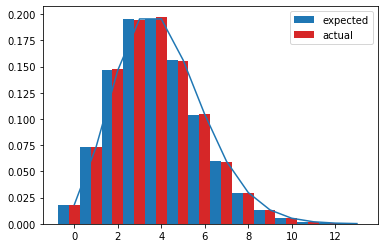

---- Sample data ----
MWU: MannwhitneyuResult(statistic=57.0, pvalue=0.03075178029688904)
Levene: LeveneResult(statistic=0.06621445932599689, pvalue=0.7989560474928434)


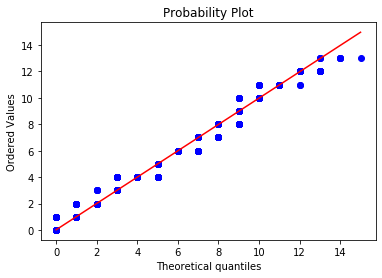

524288
---- Normalized data ----
Mean: 3.9998779296875; expected: 4; difference: 0.0001220703125
Std: 3.9804839938879013; expected: 4; difference: 0.019516006112098694
difference between std and mean :0.019393935799598694
MWU: MannwhitneyuResult(statistic=128.0, pvalue=0.4924819045390597)
Levene: LeveneResult(statistic=4.159393363817982e-06, pvalue=0.9983862498475858)


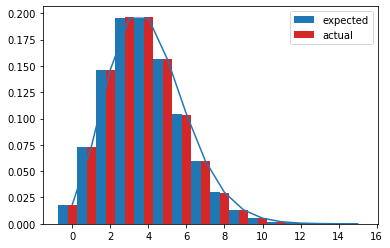

---- Sample data ----
MWU: MannwhitneyuResult(statistic=72.0, pvalue=0.017752430528769868)
Levene: LeveneResult(statistic=0.019497779411555248, pvalue=0.889882057645897)


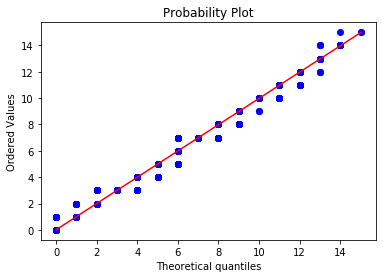

1048576
---- Normalized data ----
Mean: 3.9999351501464844; expected: 4; difference: 6.4849853515625e-05
Std: 3.992198939886294; expected: 4; difference: 0.007801060113706182
difference between std and mean :0.007736210260190557
MWU: MannwhitneyuResult(statistic=144.0, pvalue=0.5)
Levene: LeveneResult(statistic=1.1065958371336695e-07, pvalue=0.9997366446182434)


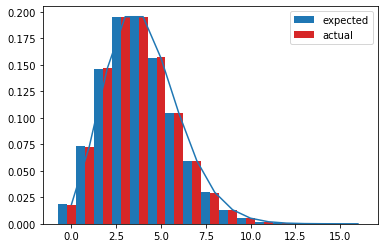

---- Sample data ----
MWU: MannwhitneyuResult(statistic=80.0, pvalue=0.013254609571501208)
Levene: LeveneResult(statistic=0.011324515023256248, pvalue=0.9159160839865518)


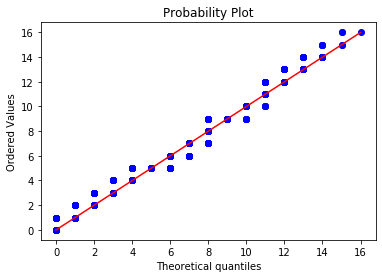

2097152
---- Normalized data ----
Mean: 3.9999656677246094; expected: 4; difference: 3.4332275390625e-05
Std: 4.0061264026298895; expected: 4; difference: 0.006126402629889505
difference between std and mean :0.00616073490528013
MWU: MannwhitneyuResult(statistic=161.0, pvalue=0.4936884633429517)
Levene: LeveneResult(statistic=4.6496177649298216e-07, pvalue=0.9994599228877445)


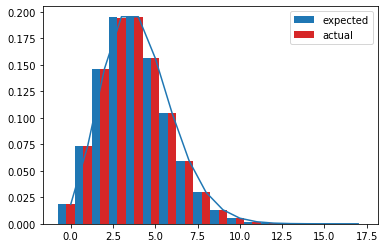

---- Sample data ----
MWU: MannwhitneyuResult(statistic=92.0, pvalue=0.01350264584460041)
Levene: LeveneResult(statistic=0.005491991126516215, pvalue=0.9413587726223671)


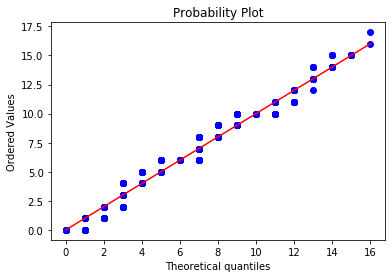

4194304
---- Normalized data ----
Mean: 3.9999818801879883; expected: 4; difference: 1.811981201171875e-05
Std: 4.0000333782727475; expected: 4; difference: 3.337827274751959e-05
difference between std and mean :5.149808475923834e-05
MWU: MannwhitneyuResult(statistic=179.0, pvalue=0.4883539983045295)
Levene: LeveneResult(statistic=1.8376941353037484e-07, pvalue=0.9996603269274287)


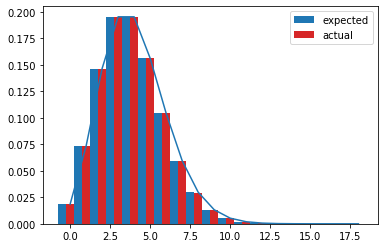

---- Sample data ----
MWU: MannwhitneyuResult(statistic=106.0, pvalue=0.01461748755393779)
Levene: LeveneResult(statistic=0.00255175028715002, pvalue=0.9599913584156883)


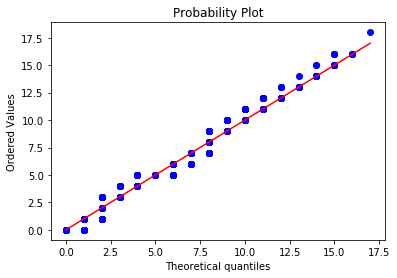

8388608
---- Normalized data ----
Mean: 3.999990463256836; expected: 4; difference: 9.5367431640625e-06
Std: 3.999888420014031; expected: 4; difference: 0.00011157998596900143
difference between std and mean :0.00010204324280493893
MWU: MannwhitneyuResult(statistic=160.0, pvalue=0.4810729247197727)
Levene: LeveneResult(statistic=1.233117892312595e-07, pvalue=0.9997218689501043)


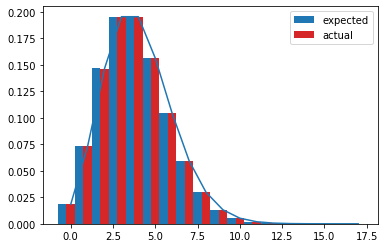

---- Sample data ----
MWU: MannwhitneyuResult(statistic=91.0, pvalue=0.012458831573657786)
Levene: LeveneResult(statistic=0.005381410360139988, pvalue=0.9419510423170994)


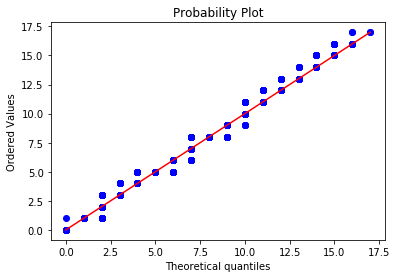

16777216
---- Normalized data ----
Mean: 3.999994993209839; expected: 4; difference: 5.0067901611328125e-06
Std: 4.002249479268754; expected: 4; difference: 0.0022494792687544063
difference between std and mean :0.002254486058915539
MWU: MannwhitneyuResult(statistic=180.0, pvalue=0.5)
Levene: LeveneResult(statistic=4.0866500124211705e-09, pvalue=0.9999493466362438)


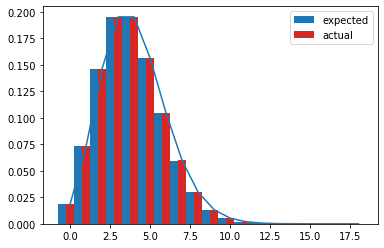

---- Sample data ----
MWU: MannwhitneyuResult(statistic=102.5, pvalue=0.011507401360997255)
Levene: LeveneResult(statistic=0.002519229095940068, pvalue=0.960246902850807)


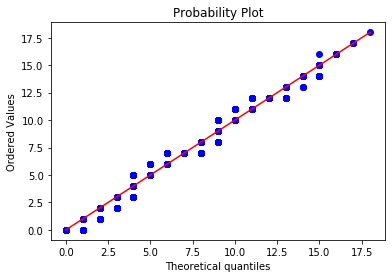

33554432
---- Normalized data ----
Mean: 3.99999737739563; expected: 4; difference: 2.6226043701171875e-06
Std: 3.9998207092216385; expected: 4; difference: 0.0001792907783615405
difference between std and mean :0.00017666817399142332
MWU: MannwhitneyuResult(statistic=177.0, pvalue=0.46510165926432856)
Levene: LeveneResult(statistic=4.829228329466412e-08, pvalue=0.9998258740918354)


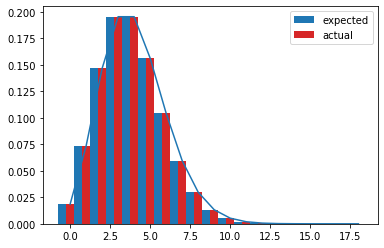

---- Sample data ----
MWU: MannwhitneyuResult(statistic=102.5, pvalue=0.011507401360997255)
Levene: LeveneResult(statistic=0.0025094192329356405, pvalue=0.9603243108619228)


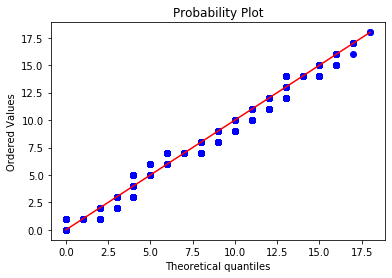

In [328]:
perform_test(seq='prng',lamb=4)

### PRNG with lambda = 32 from N=2ˆ10 up to 2ˆ26

1024
---- Normalized data ----
Mean: 31.875; expected: 32; difference: 0.125
Std: 31.734375; expected: 32; difference: 0.265625
difference between std and mean :0.140625
MWU: MannwhitneyuResult(statistic=510.0, pvalue=0.00013259633904846936)
Levene: LeveneResult(statistic=0.06422326079433467, pvalue=0.8005605110646501)


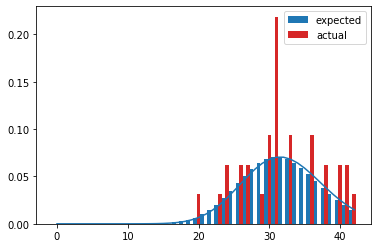

---- Sample data ----
MWU: MannwhitneyuResult(statistic=723.0, pvalue=0.0072879939410245564)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


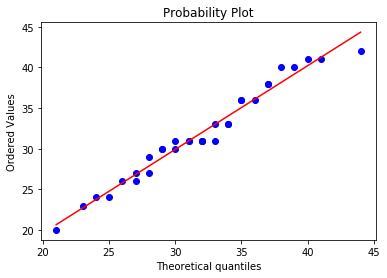

2048
---- Normalized data ----
Mean: 31.921875; expected: 32; difference: 0.078125
Std: 32.572021484375; expected: 32; difference: 0.572021484375
difference between std and mean :0.650146484375
MWU: MannwhitneyuResult(statistic=712.0, pvalue=0.03250119677338793)
Levene: LeveneResult(statistic=0.1107800755216335, pvalue=0.740087030763098)


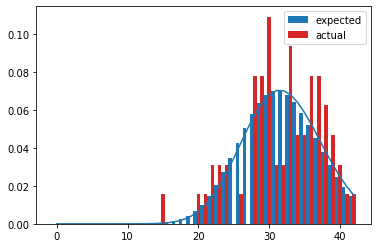

---- Sample data ----
MWU: MannwhitneyuResult(statistic=575.0, pvalue=0.00010308524800040646)
Levene: LeveneResult(statistic=0.0007855165706590882, pvalue=0.9777070422384843)


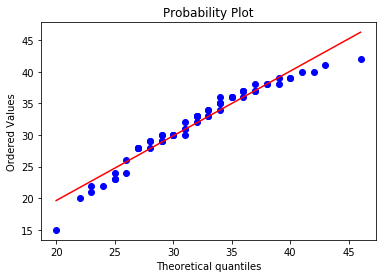

4096
---- Normalized data ----
Mean: 31.953125; expected: 32; difference: 0.046875
Std: 28.497802734375; expected: 32; difference: 3.502197265625
difference between std and mean :3.455322265625
MWU: MannwhitneyuResult(statistic=834.0, pvalue=0.03954148346328714)
Levene: LeveneResult(statistic=0.03642206173224807, pvalue=0.8490763761122346)


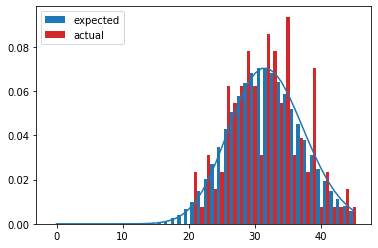

---- Sample data ----
MWU: MannwhitneyuResult(statistic=647.5, pvalue=7.092599516026412e-05)
Levene: LeveneResult(statistic=0.003131959910913135, pvalue=0.9554946067259003)


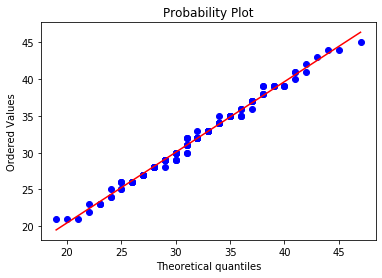

8192
---- Normalized data ----
Mean: 31.97265625; expected: 32; difference: 0.02734375
Std: 38.01878356933594; expected: 32; difference: 6.0187835693359375
difference between std and mean :6.0461273193359375
MWU: MannwhitneyuResult(statistic=1256.0, pvalue=0.06205054769117199)
Levene: LeveneResult(statistic=0.0019619751397162025, pvalue=0.9647516975040007)


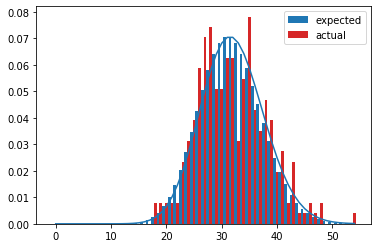

---- Sample data ----
MWU: MannwhitneyuResult(statistic=837.5, pvalue=9.921192848148267e-07)
Levene: LeveneResult(statistic=0.004764223854998189, pvalue=0.9450986629403484)


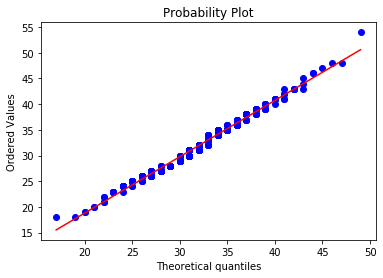

16384
---- Normalized data ----
Mean: 31.984375; expected: 32; difference: 0.015625
Std: 31.499755859375; expected: 32; difference: 0.500244140625
difference between std and mean :0.484619140625
MWU: MannwhitneyuResult(statistic=1097.0, pvalue=0.08631341891079125)
Levene: LeveneResult(statistic=0.0038191833033273423, pvalue=0.9508458190674051)


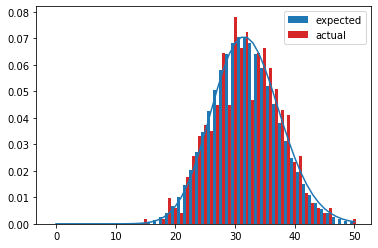

---- Sample data ----
MWU: MannwhitneyuResult(statistic=704.5, pvalue=1.8327518907334753e-06)
Levene: LeveneResult(statistic=0.0034610032358584016, pvalue=0.9532046837448624)


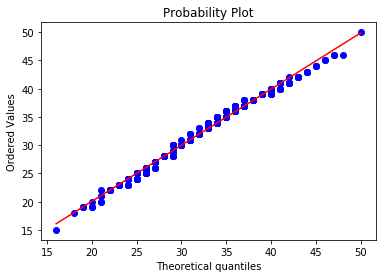

32768
---- Normalized data ----
Mean: 31.9912109375; expected: 32; difference: 0.0087890625
Std: 33.55753993988037; expected: 32; difference: 1.557539939880371
difference between std and mean :1.566329002380371
MWU: MannwhitneyuResult(statistic=1091.0, pvalue=0.13656254869563506)
Levene: LeveneResult(statistic=4.759318088099746e-05, pvalue=0.9945096368320536)


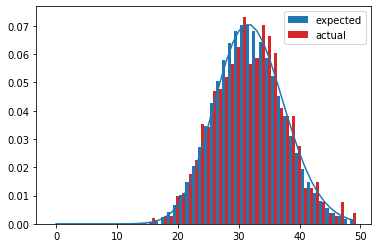

---- Sample data ----
MWU: MannwhitneyuResult(statistic=640.5, pvalue=7.523808280673665e-07)
Levene: LeveneResult(statistic=0.00889083913283396, pvalue=0.9250703226540151)


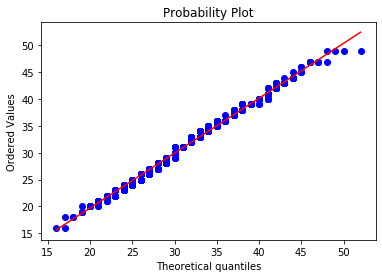

65536
---- Normalized data ----
Mean: 31.9951171875; expected: 32; difference: 0.0048828125
Std: 32.03708553314209; expected: 32; difference: 0.037085533142089844
difference between std and mean :0.041968345642089844
MWU: MannwhitneyuResult(statistic=1232.0, pvalue=0.13796613349713183)
Levene: LeveneResult(statistic=0.0007688635877899414, pvalue=0.9779319193176369)


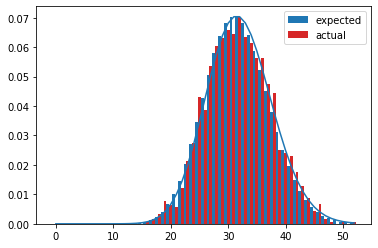

---- Sample data ----
MWU: MannwhitneyuResult(statistic=704.0, pvalue=2.7425614996723214e-07)
Levene: LeveneResult(statistic=0.003168207777501468, pvalue=0.9552213029768419)


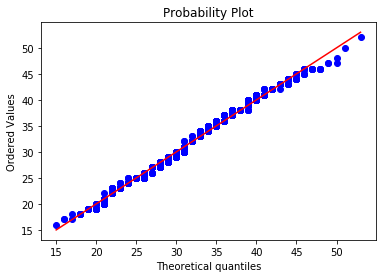

131072
---- Normalized data ----
Mean: 31.997314453125; expected: 32; difference: 0.002685546875
Std: 33.12230724096298; expected: 32; difference: 1.1223072409629822
difference between std and mean :1.1249927878379822
MWU: MannwhitneyuResult(statistic=1325.0, pvalue=0.20740046359767145)
Levene: LeveneResult(statistic=5.348022812971822e-05, pvalue=0.9941788536872002)


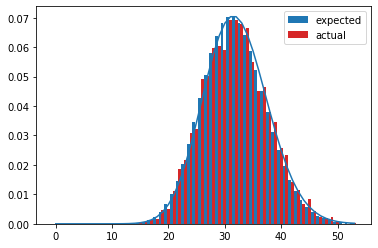

---- Sample data ----
MWU: MannwhitneyuResult(statistic=663.5, pvalue=2.5267848907211236e-08)
Levene: LeveneResult(statistic=0.0031076976991972496, pvalue=0.955648515061951)


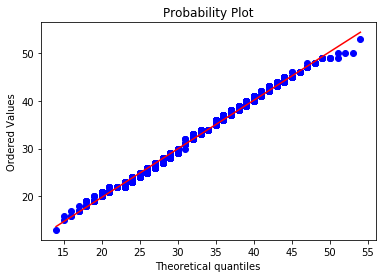

262144
---- Normalized data ----
Mean: 31.99853515625; expected: 32; difference: 0.00146484375
Std: 31.929441213607788; expected: 32; difference: 0.07055878639221191
difference between std and mean :0.06909394264221191
MWU: MannwhitneyuResult(statistic=1565.0, pvalue=0.2597875646154668)
Levene: LeveneResult(statistic=0.00011931325355129198, pvalue=0.991303924414002)


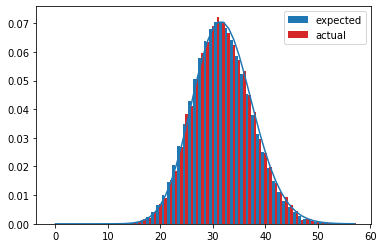

---- Sample data ----
MWU: MannwhitneyuResult(statistic=700.5, pvalue=1.0025731602704064e-09)
Levene: LeveneResult(statistic=0.0009522861419272041, pvalue=0.9754358422972502)


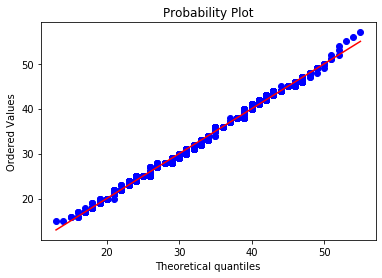

524288
---- Normalized data ----
Mean: 31.99920654296875; expected: 32; difference: 0.00079345703125
Std: 31.92352231964469; expected: 32; difference: 0.07647768035531044
difference between std and mean :0.07568422332406044
MWU: MannwhitneyuResult(statistic=1564.0, pvalue=0.36684146010635854)
Levene: LeveneResult(statistic=1.3573351170987946e-05, pvalue=0.9970669921965145)


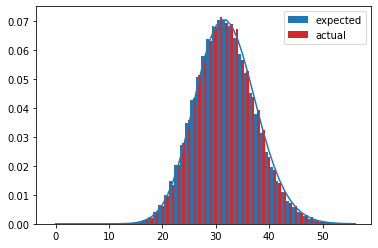

---- Sample data ----
MWU: MannwhitneyuResult(statistic=616.5, pvalue=2.73959714949884e-10)
Levene: LeveneResult(statistic=0.0017456398584573653, pvalue=0.9667477891513546)


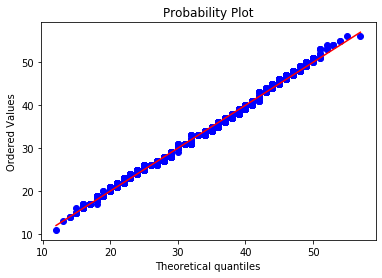

1048576
---- Normalized data ----
Mean: 31.99957275390625; expected: 32; difference: 0.00042724609375
Std: 31.720458801835775; expected: 32; difference: 0.2795411981642246
difference between std and mean :0.2791139520704746
MWU: MannwhitneyuResult(statistic=1578.0, pvalue=0.28366246914045934)
Levene: LeveneResult(statistic=2.7135419705020023e-05, pvalue=0.9958528097027608)


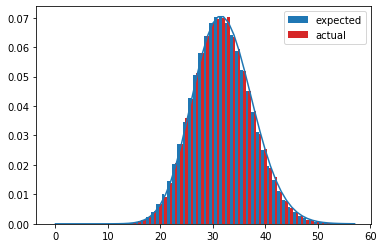

---- Sample data ----
MWU: MannwhitneyuResult(statistic=674.0, pvalue=4.4450975236274347e-10)
Levene: LeveneResult(statistic=0.001101896021129418, pvalue=0.9735772795728036)


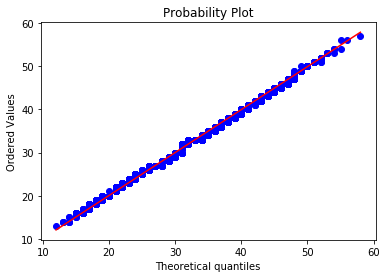

2097152
---- Normalized data ----
Mean: 31.999771118164062; expected: 32; difference: 0.0002288818359375
Std: 31.922561593120918; expected: 32; difference: 0.07743840687908232
difference between std and mean :0.07720952504314482
MWU: MannwhitneyuResult(statistic=1845.0, pvalue=0.35103624784252163)
Levene: LeveneResult(statistic=1.6192841180604394e-07, pvalue=0.9996795858846095)


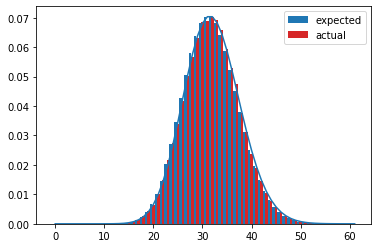

---- Sample data ----
MWU: MannwhitneyuResult(statistic=728.0, pvalue=4.824702750839323e-11)
Levene: LeveneResult(statistic=0.000412206095811644, pvalue=0.9838349426939609)


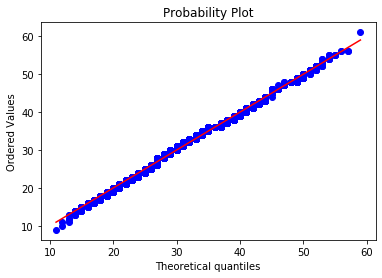

4194304
---- Normalized data ----
Mean: 31.9998779296875; expected: 32; difference: 0.0001220703125
Std: 31.971527084708214; expected: 32; difference: 0.028472915291786194
difference between std and mean :0.028350844979286194
MWU: MannwhitneyuResult(statistic=1689.0, pvalue=0.3918183889401977)
Levene: LeveneResult(statistic=1.1148650401219125e-07, pvalue=0.9997341631197263)


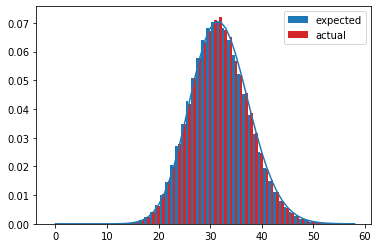

---- Sample data ----
MWU: MannwhitneyuResult(statistic=605.5, pvalue=2.837617809106698e-11)
Levene: LeveneResult(statistic=0.000977234052816367, pvalue=0.9751153205871468)


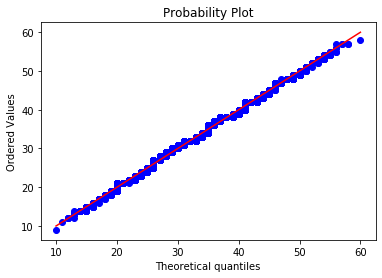

8388608
---- Normalized data ----
Mean: 31.999935150146484; expected: 32; difference: 6.4849853515625e-05
Std: 32.0262107807066; expected: 32; difference: 0.02621078070659877
difference between std and mean :0.026275630560114394
MWU: MannwhitneyuResult(statistic=1880.0, pvalue=0.41783376046457543)
Levene: LeveneResult(statistic=4.726776995751363e-06, pvalue=0.9982688594271789)


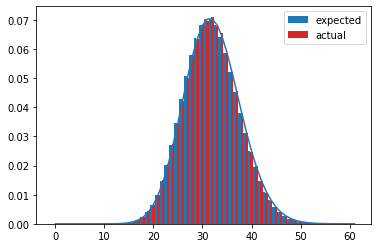

---- Sample data ----
MWU: MannwhitneyuResult(statistic=620.5, pvalue=1.8171132023197238e-12)
Levene: LeveneResult(statistic=0.0004603195586864954, pvalue=0.9829177038519599)


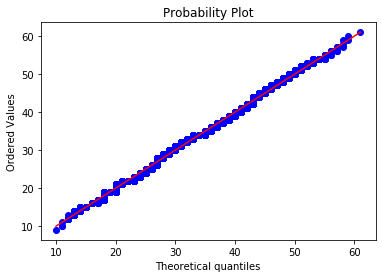

16777216
---- Normalized data ----
Mean: 31.99996566772461; expected: 32; difference: 3.4332275390625e-05
Std: 31.897613524211916; expected: 32; difference: 0.10238647578808369
difference between std and mean :0.10235214351269306
MWU: MannwhitneyuResult(statistic=1979.0, pvalue=0.37199345330823713)
Levene: LeveneResult(statistic=2.1430982787578846e-06, pvalue=0.9988342665389521)


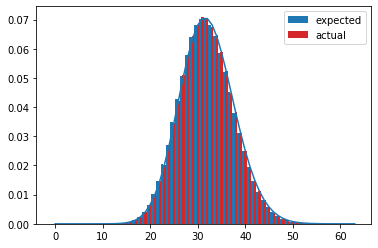

---- Sample data ----
MWU: MannwhitneyuResult(statistic=727.0, pvalue=5.255419535400224e-12)
Levene: LeveneResult(statistic=0.0002662290955388962, pvalue=0.9870076799417347)


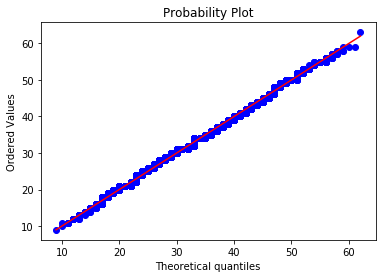

33554432
---- Normalized data ----
Mean: 31.99998188018799; expected: 32; difference: 1.811981201171875e-05
Std: 31.924351691871383; expected: 32; difference: 0.075648308128617
difference between std and mean :0.07563018831660528
MWU: MannwhitneyuResult(statistic=2052.0, pvalue=0.3899444092413268)
Levene: LeveneResult(statistic=1.9216123388713423e-07, pvalue=0.9996509202124395)


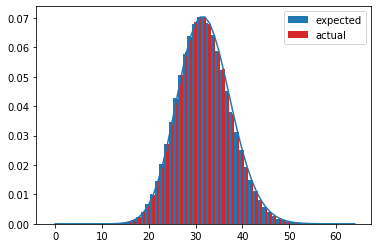

---- Sample data ----
MWU: MannwhitneyuResult(statistic=716.0, pvalue=1.3104689741267034e-12)
Levene: LeveneResult(statistic=0.0001906750341761691, pvalue=0.98900425028158)


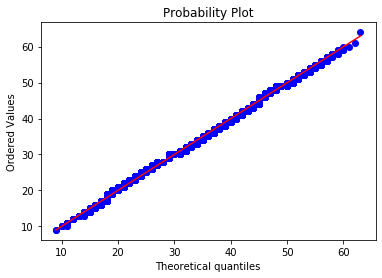

In [329]:
perform_test(seq='prng',lamb=32)

### Rule 30 with lambda = 1 from N=2ˆ10 up to 2ˆ26


1024
---- Normalized data ----
Mean: 0.9912109375; expected: 1; difference: 0.0087890625
Std: 1.004805564880371; expected: 1; difference: 0.004805564880371094
difference between std and mean :0.013594627380371094
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=2.7998015293992698e-05, pvalue=0.9958651089193592)


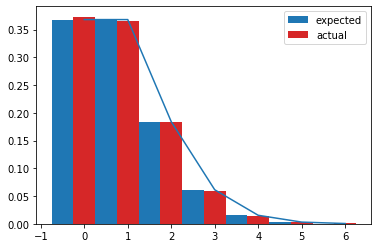

---- Sample data ----
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=3.8824118117344417e-05, pvalue=0.9951308808542243)


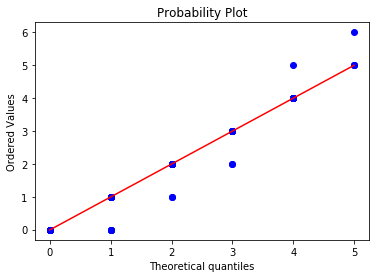

2048
---- Normalized data ----
Mean: 0.9951171875; expected: 1; difference: 0.0048828125
Std: 0.9687261581420898; expected: 1; difference: 0.031273841857910156
difference between std and mean :0.026391029357910156
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=0.00027471879094409225, pvalue=0.9870483443786512)


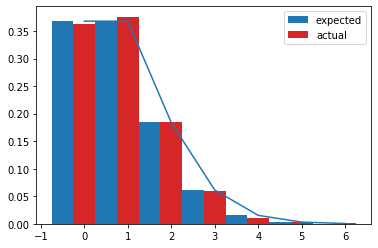

---- Sample data ----
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=0.002127612809635795, pvalue=0.9639685164715118)


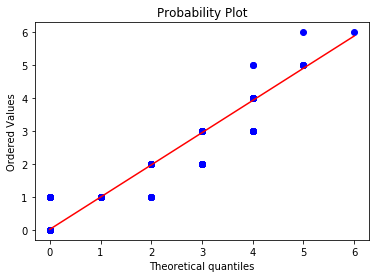

4096
---- Normalized data ----
Mean: 0.997314453125; expected: 1; difference: 0.002685546875
Std: 0.9460377097129822; expected: 1; difference: 0.05396229028701782
difference between std and mean :0.05127674341201782
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491077413427273)
Levene: LeveneResult(statistic=0.00010927512047640175, pvalue=0.9918312665577753)


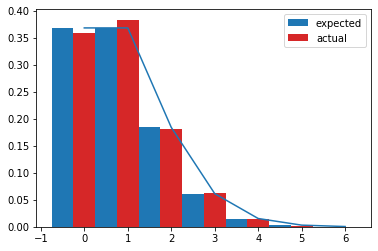

---- Sample data ----
MWU: MannwhitneyuResult(statistic=24.5, pvalue=0.47450184322152916)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


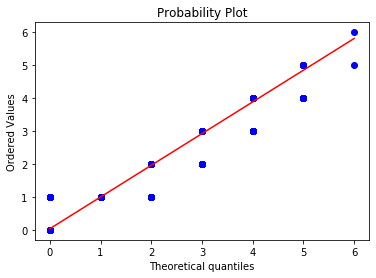

8192
---- Normalized data ----
Mean: 0.99853515625; expected: 1; difference: 0.00146484375
Std: 0.9877908229827881; expected: 1; difference: 0.012209177017211914
difference between std and mean :0.010744333267211914
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=3.5312006382472246e-07, pvalue=0.9995356303628636)


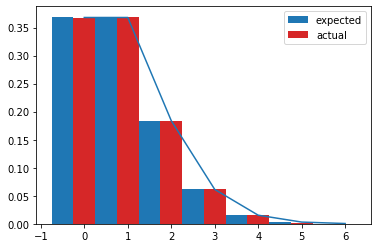

---- Sample data ----
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.30126217618064843)
Levene: LeveneResult(statistic=0.01493736450818918, pvalue=0.9045950981425295)


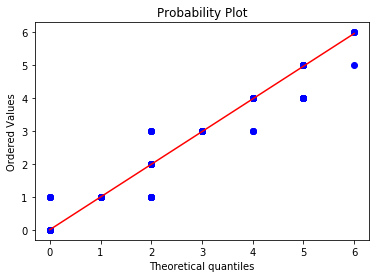

16384
---- Normalized data ----
Mean: 0.99920654296875; expected: 1; difference: 0.00079345703125
Std: 0.9771111868321896; expected: 1; difference: 0.02288881316781044
difference between std and mean :0.02209535613656044
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491077413427273)
Levene: LeveneResult(statistic=5.851755066022897e-05, pvalue=0.9940222034839529)


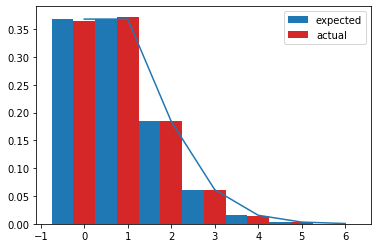

---- Sample data ----
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.34272174133876104)
Levene: LeveneResult(statistic=0.01766750205882931, pvalue=0.8962927503357397)


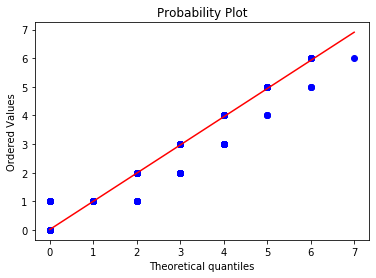

32768
---- Normalized data ----
Mean: 0.99957275390625; expected: 1; difference: 0.00042724609375
Std: 0.9954221807420254; expected: 1; difference: 0.004577819257974625
difference between std and mean :0.004150573164224625
MWU: MannwhitneyuResult(statistic=49.0, pvalue=0.4849193207024165)
Levene: LeveneResult(statistic=1.0654789100971002e-06, pvalue=0.9991877613857885)


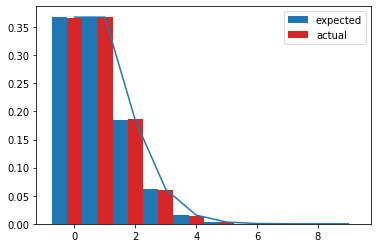

---- Sample data ----
MWU: MannwhitneyuResult(statistic=47.5, pvalue=0.43980218078345007)
Levene: LeveneResult(statistic=1.4716001756171405e-06, pvalue=0.9990454337220397)


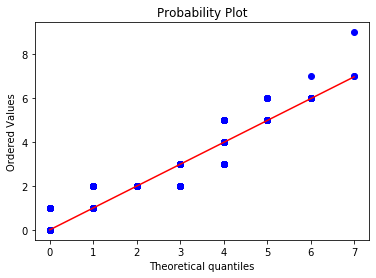

65536
---- Normalized data ----
Mean: 0.9997711181640625; expected: 1; difference: 0.0002288818359375
Std: 1.0062713099177927; expected: 1; difference: 0.006271309917792678
difference between std and mean :0.006500191753730178
MWU: MannwhitneyuResult(statistic=32.0, pvalue=0.4790455641133508)
Levene: LeveneResult(statistic=4.9260160424781634e-08, pvalue=0.9998260440594071)


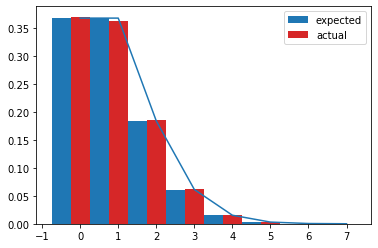

---- Sample data ----
MWU: MannwhitneyuResult(statistic=30.5, pvalue=0.45814889899892497)
Levene: LeveneResult(statistic=1.8506373133165708e-06, pvalue=0.9989337676100912)


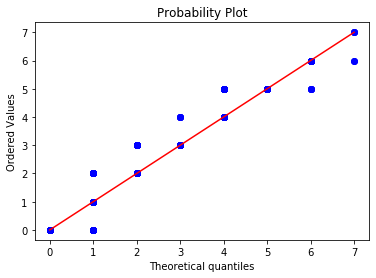

131072
---- Normalized data ----
Mean: 0.9998779296875; expected: 1; difference: 0.0001220703125
Std: 1.0018462985754013; expected: 1; difference: 0.0018462985754013062
difference between std and mean :0.001968368887901306
MWU: MannwhitneyuResult(statistic=32.0, pvalue=0.4790455641133508)
Levene: LeveneResult(statistic=1.6044579710201316e-06, pvalue=0.9990072145449502)


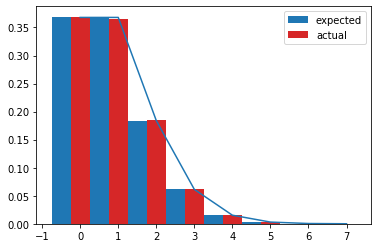

---- Sample data ----
MWU: MannwhitneyuResult(statistic=32.0, pvalue=0.3681384891705356)
Levene: LeveneResult(statistic=0.028105713390139148, pvalue=0.8690998870059614)


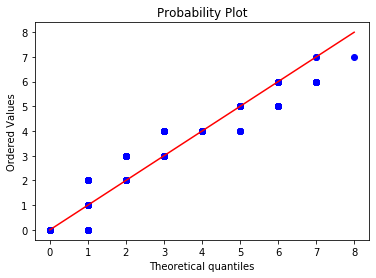

262144
---- Normalized data ----
Mean: 0.9999351501464844; expected: 1; difference: 6.4849853515625e-05
Std: 0.9992637592222309; expected: 1; difference: 0.000736240777769126
difference between std and mean :0.000671390924253501
MWU: MannwhitneyuResult(statistic=40.0, pvalue=0.5)
Levene: LeveneResult(statistic=3.9119206302020335e-09, pvalue=0.9999508692187141)


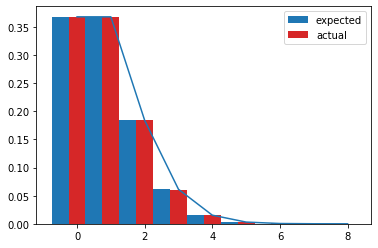

---- Sample data ----
MWU: MannwhitneyuResult(statistic=40.0, pvalue=0.3566515869392288)
Levene: LeveneResult(statistic=0.019117213269995912, pvalue=0.8916555524473524)


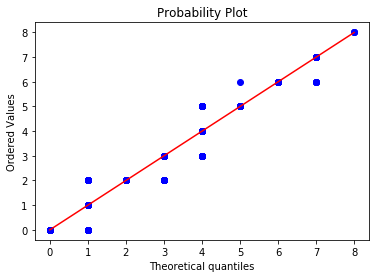

524288
---- Normalized data ----
Mean: 0.9999656677246094; expected: 1; difference: 3.4332275390625e-05
Std: 0.997058867229498; expected: 1; difference: 0.0029411327705020085
difference between std and mean :0.0029068004951113835
MWU: MannwhitneyuResult(statistic=49.0, pvalue=0.4849193207024165)
Levene: LeveneResult(statistic=1.5172129686359332e-07, pvalue=0.9996934971272167)


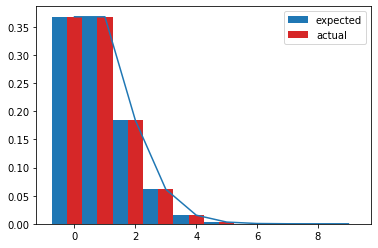

---- Sample data ----
MWU: MannwhitneyuResult(statistic=47.5, pvalue=0.4398921505284963)
Levene: LeveneResult(statistic=4.338596189924593e-07, pvalue=0.9994816944406926)


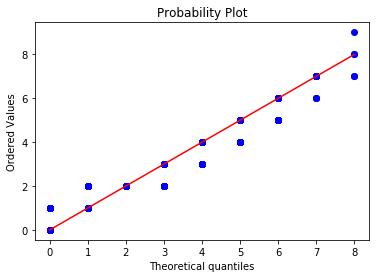

1048576
---- Normalized data ----
Mean: 0.9999818801879883; expected: 1; difference: 1.811981201171875e-05
Std: 0.9971818920666919; expected: 1; difference: 0.002818107933308056
difference between std and mean :0.0027999881212963373
MWU: MannwhitneyuResult(statistic=49.0, pvalue=0.4849193207024165)
Levene: LeveneResult(statistic=9.119855350198218e-08, pvalue=0.9997623678172864)


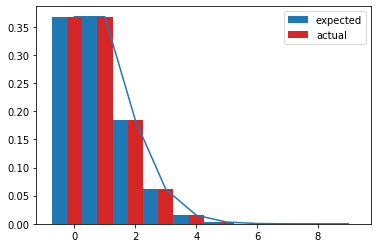

---- Sample data ----
MWU: MannwhitneyuResult(statistic=50.0, pvalue=0.4849249884965778)
Levene: LeveneResult(statistic=1.2049915361712608e-07, pvalue=0.9997268487009645)


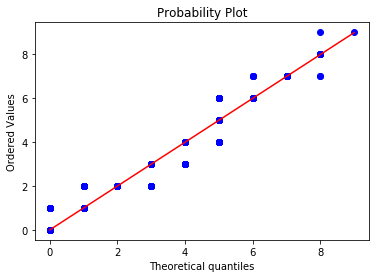

2097152
---- Normalized data ----
Mean: 0.9999904632568359; expected: 1; difference: 9.5367431640625e-06
Std: 0.9982204436346365; expected: 1; difference: 0.0017795563653635327
difference between std and mean :0.0017700196221994702
MWU: MannwhitneyuResult(statistic=47.0, pvalue=0.42502551244863873)
Levene: LeveneResult(statistic=9.212515056234535e-08, pvalue=0.9997611636713128)


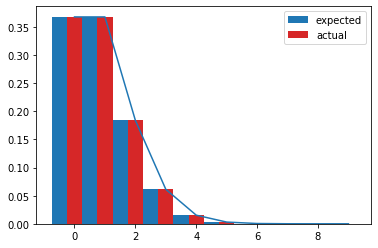

---- Sample data ----
MWU: MannwhitneyuResult(statistic=54.0, pvalue=0.4859565669766532)
Levene: LeveneResult(statistic=0.018913361281385564, pvalue=0.892062105545688)


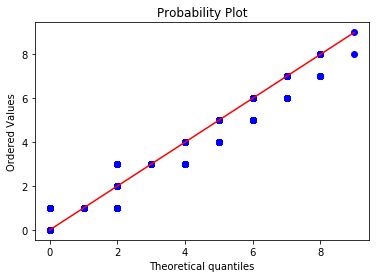

4194304
---- Normalized data ----
Mean: 0.9999949932098389; expected: 1; difference: 5.0067901611328125e-06
Std: 0.9986646175133842; expected: 1; difference: 0.0013353824866157993
difference between std and mean :0.0013303756964546665
MWU: MannwhitneyuResult(statistic=49.0, pvalue=0.4849193207024165)
Levene: LeveneResult(statistic=2.5511360518491895e-09, pvalue=0.9999602554090811)


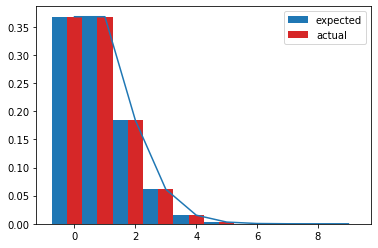

---- Sample data ----
MWU: MannwhitneyuResult(statistic=51.0, pvalue=0.4026620853091242)
Levene: LeveneResult(statistic=0.018809598559089626, pvalue=0.892356644703737)


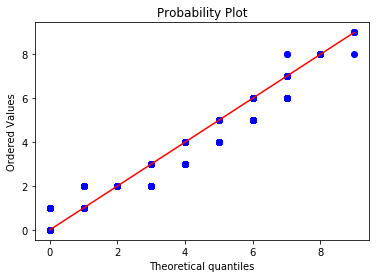

8388608
---- Normalized data ----
Mean: 0.9999973773956299; expected: 1; difference: 2.6226043701171875e-06
Std: 0.9992947578361395; expected: 1; difference: 0.0007052421638604756
difference between std and mean :0.0007026195594903584
MWU: MannwhitneyuResult(statistic=60.0, pvalue=0.5)
Levene: LeveneResult(statistic=3.797865953249695e-09, pvalue=0.9999514394771827)


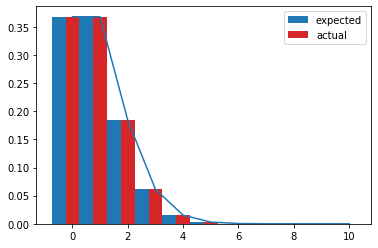

---- Sample data ----
MWU: MannwhitneyuResult(statistic=63.0, pvalue=0.4388283487879106)
Levene: LeveneResult(statistic=0.014765494171709309, pvalue=0.9044396866989178)


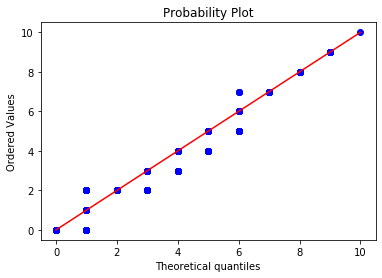

16777216
---- Normalized data ----
Mean: 0.9999986290931702; expected: 1; difference: 1.3709068298339844e-06
Std: 1.000257313249616; expected: 1; difference: 0.0002573132496159758
difference between std and mean :0.0002586841564458098
MWU: MannwhitneyuResult(statistic=59.0, pvalue=0.47381488164049806)
Levene: LeveneResult(statistic=3.3526759660069675e-13, pvalue=0.9999995452430156)


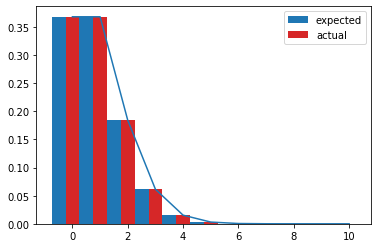

---- Sample data ----
MWU: MannwhitneyuResult(statistic=59.5, pvalue=0.48689297622562533)
Levene: LeveneResult(statistic=2.4641491461536676e-12, pvalue=0.9999987629272575)


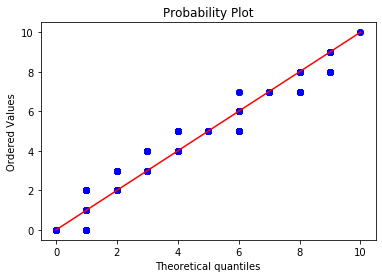

33554432
---- Normalized data ----
Mean: 0.9999992847442627; expected: 1; difference: 7.152557373046875e-07
Std: 0.9998430609697946; expected: 1; difference: 0.00015693903020541633
difference between std and mean :0.00015622377446811164
MWU: MannwhitneyuResult(statistic=71.0, pvalue=0.48848262430702205)
Levene: LeveneResult(statistic=1.9139926732484021e-10, pvalue=0.9999890862047126)


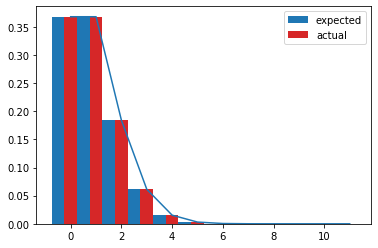

---- Sample data ----
MWU: MannwhitneyuResult(statistic=72.0, pvalue=0.48848512766098784)
Levene: LeveneResult(statistic=2.821271314976245e-11, pvalue=0.9999958098184583)


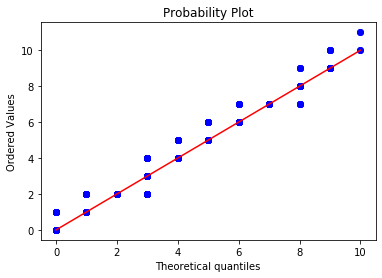

In [359]:
perform_test(seq='rule30',lamb=1)

### Rule 30 with lambda = 4 from N=2ˆ10 up to 2ˆ26

1024
---- Normalized data ----
Mean: 3.97265625; expected: 4; difference: 0.02734375
Std: 4.0812835693359375; expected: 4; difference: 0.0812835693359375
difference between std and mean :0.1086273193359375
MWU: MannwhitneyuResult(statistic=81.0, pvalue=0.4388343925435724)
Levene: LeveneResult(statistic=0.0019399121383166698, pvalue=0.9652333973329016)


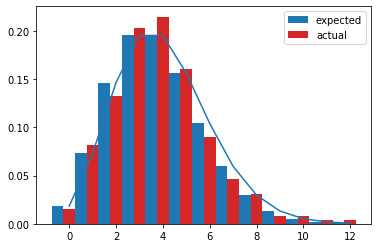

---- Sample data ----
MWU: MannwhitneyuResult(statistic=51.0, pvalue=0.04361122505059242)
Levene: LeveneResult(statistic=0.12981744421906705, pvalue=0.7217730013377158)


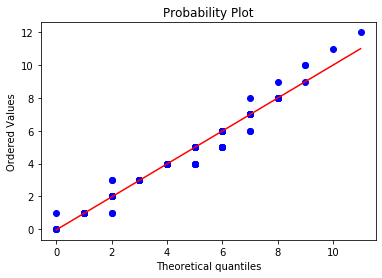

2048
---- Normalized data ----
Mean: 3.984375; expected: 4; difference: 0.015625
Std: 3.745849609375; expected: 4; difference: 0.254150390625
difference between std and mean :0.238525390625
MWU: MannwhitneyuResult(statistic=69.0, pvalue=0.4426045650376629)
Levene: LeveneResult(statistic=0.0010429250388190674, pvalue=0.9745285173404622)


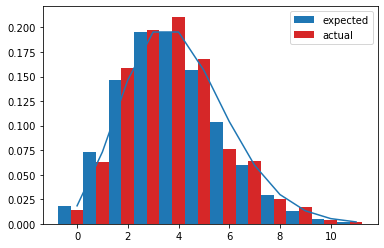

---- Sample data ----
MWU: MannwhitneyuResult(statistic=44.0, pvalue=0.05531570297130263)
Levene: LeveneResult(statistic=0.21825462289476447, pvalue=0.6449670424258414)


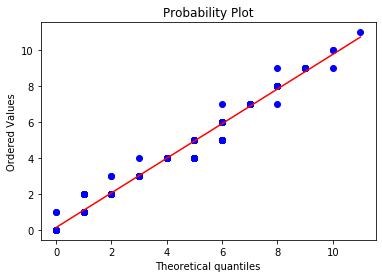

4096
---- Normalized data ----
Mean: 3.9912109375; expected: 4; difference: 0.0087890625
Std: 3.811446189880371; expected: 4; difference: 0.1885538101196289
difference between std and mean :0.1797647476196289
MWU: MannwhitneyuResult(statistic=60.0, pvalue=0.5)
Levene: LeveneResult(statistic=0.0007191635559072293, pvalue=0.978871298039212)


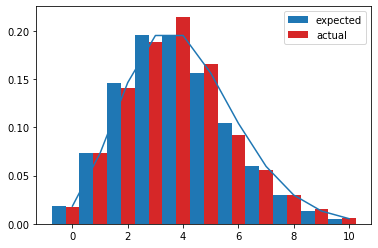

---- Sample data ----
MWU: MannwhitneyuResult(statistic=39.0, pvalue=0.08335160255127394)
Levene: LeveneResult(statistic=0.40179265907087464, pvalue=0.5333480759746675)


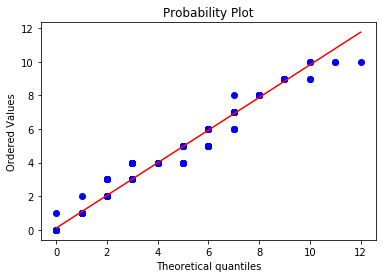

8192
---- Normalized data ----
Mean: 3.9951171875; expected: 4; difference: 0.0048828125
Std: 4.01755428314209; expected: 4; difference: 0.017554283142089844
difference between std and mean :0.022437095642089844
MWU: MannwhitneyuResult(statistic=95.0, pvalue=0.45426816835964046)
Levene: LeveneResult(statistic=0.0008623187714375638, pvalue=0.9767975263577363)


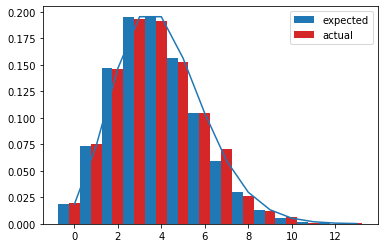

---- Sample data ----
MWU: MannwhitneyuResult(statistic=62.0, pvalue=0.05006286449125914)
Levene: LeveneResult(statistic=0.060748904588425405, pvalue=0.8072517438788804)


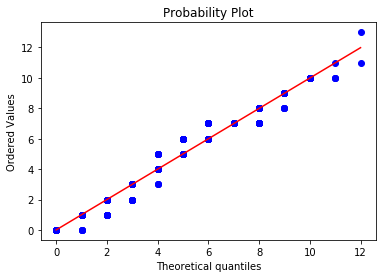

16384
---- Normalized data ----
Mean: 3.997314453125; expected: 4; difference: 0.002685546875
Std: 3.909416615962982; expected: 4; difference: 0.09058338403701782
difference between std and mean :0.08789783716201782
MWU: MannwhitneyuResult(statistic=84.0, pvalue=0.5)
Levene: LeveneResult(statistic=9.269467034839949e-06, pvalue=0.9975959463786612)


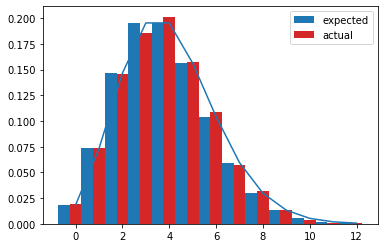

---- Sample data ----
MWU: MannwhitneyuResult(statistic=50.0, pvalue=0.03970531299947112)
Levene: LeveneResult(statistic=0.13976992175535644, pvalue=0.7117923018312131)


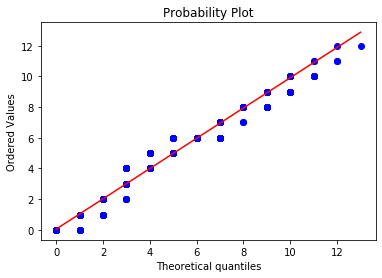

32768
---- Normalized data ----
Mean: 3.99853515625; expected: 4; difference: 0.00146484375
Std: 3.942380666732788; expected: 4; difference: 0.057619333267211914
difference between std and mean :0.056154489517211914
MWU: MannwhitneyuResult(statistic=185.0, pvalue=0.34729577804003875)
Levene: LeveneResult(statistic=9.894092191372185e-05, pvalue=0.9921156877301393)


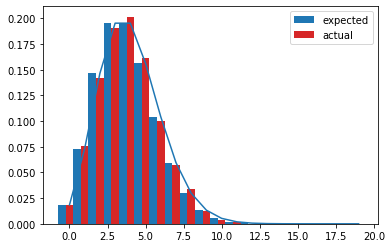

---- Sample data ----
MWU: MannwhitneyuResult(statistic=137.5, pvalue=0.04045681531641841)
Levene: LeveneResult(statistic=0.00042015298557438775, pvalue=0.9837536536922299)


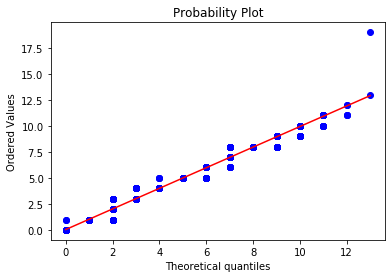

65536
---- Normalized data ----
Mean: 3.99920654296875; expected: 4; difference: 0.00079345703125
Std: 4.02496274933219; expected: 4; difference: 0.02496274933218956
difference between std and mean :0.02575620636343956
MWU: MannwhitneyuResult(statistic=110.0, pvalue=0.46693586932443376)
Levene: LeveneResult(statistic=5.295771392282578e-05, pvalue=0.9942452839461057)


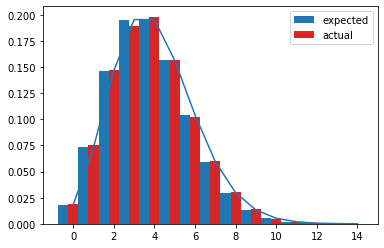

---- Sample data ----
MWU: MannwhitneyuResult(statistic=65.0, pvalue=0.024845647893835546)
Levene: LeveneResult(statistic=0.040879431913087926, pvalue=0.8412327137401532)


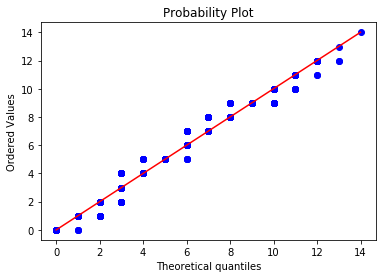

131072
---- Normalized data ----
Mean: 3.99957275390625; expected: 4; difference: 0.00042724609375
Std: 3.9902341924607754; expected: 4; difference: 0.009765807539224625
difference between std and mean :0.009338561445474625
MWU: MannwhitneyuResult(statistic=96.0, pvalue=0.4725222900881238)
Levene: LeveneResult(statistic=4.775948223552433e-05, pvalue=0.9945387583233309)


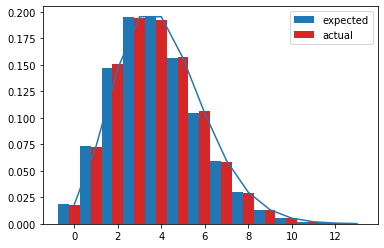

---- Sample data ----
MWU: MannwhitneyuResult(statistic=57.0, pvalue=0.030375271565295053)
Levene: LeveneResult(statistic=0.06551677044348414, pvalue=0.799994138321926)


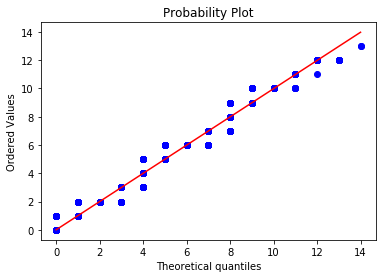

262144
---- Normalized data ----
Mean: 3.9997711181640625; expected: 4; difference: 0.0002288818359375
Std: 4.009292550152168; expected: 4; difference: 0.009292550152167678
difference between std and mean :0.009521431988105178
MWU: MannwhitneyuResult(statistic=112.0, pvalue=0.5)
Levene: LeveneResult(statistic=4.4398914993838564e-07, pvalue=0.9994730742760355)


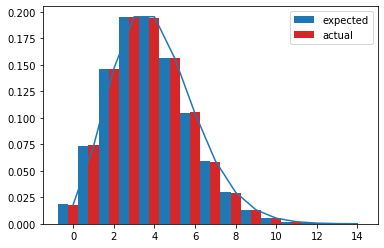

---- Sample data ----
MWU: MannwhitneyuResult(statistic=64.5, pvalue=0.02369376068042575)
Levene: LeveneResult(statistic=0.038898203350769926, pvalue=0.8450751969438017)


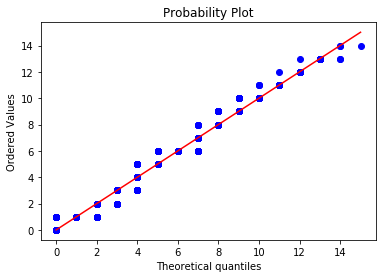

524288
---- Normalized data ----
Mean: 3.9998779296875; expected: 4; difference: 0.0001220703125
Std: 3.9839629977941513; expected: 4; difference: 0.016037002205848694
difference between std and mean :0.015914931893348694
MWU: MannwhitneyuResult(statistic=144.0, pvalue=0.5)
Levene: LeveneResult(statistic=2.7321058849957463e-06, pvalue=0.9986914321478646)


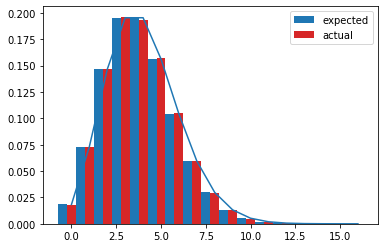

---- Sample data ----
MWU: MannwhitneyuResult(statistic=81.5, pvalue=0.015123638654162714)
Levene: LeveneResult(statistic=0.011067703659150096, pvalue=0.9168712938958181)


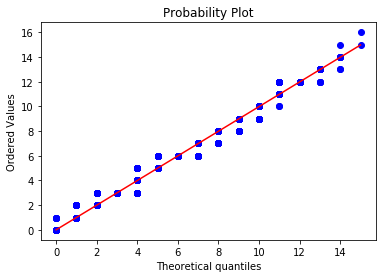

1048576
---- Normalized data ----
Mean: 3.9999351501464844; expected: 4; difference: 6.4849853515625e-05
Std: 3.983211513128481; expected: 4; difference: 0.016788486871519126
difference between std and mean :0.0167236370180035
MWU: MannwhitneyuResult(statistic=144.0, pvalue=0.5)
Levene: LeveneResult(statistic=2.06790862883045e-06, pvalue=0.9988615519803791)


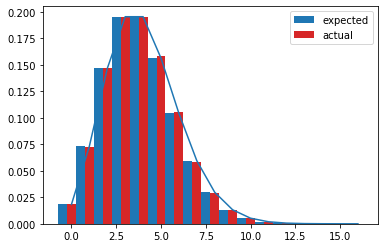

---- Sample data ----
MWU: MannwhitneyuResult(statistic=83.0, pvalue=0.017229069469353236)
Levene: LeveneResult(statistic=0.011475998559390714, pvalue=0.9153577735010205)


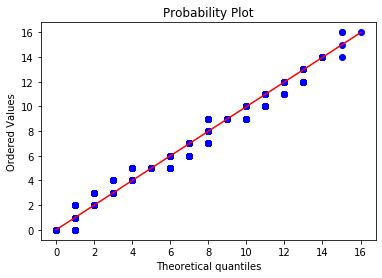

2097152
---- Normalized data ----
Mean: 3.9999656677246094; expected: 4; difference: 3.4332275390625e-05
Std: 3.986362456096686; expected: 4; difference: 0.013637543903314064
difference between std and mean :0.01360321162792344
MWU: MannwhitneyuResult(statistic=144.0, pvalue=0.5)
Levene: LeveneResult(statistic=4.572874921008759e-06, pvalue=0.9983070582810695)


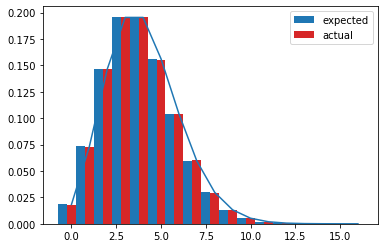

---- Sample data ----
MWU: MannwhitneyuResult(statistic=82.5, pvalue=0.01668671287519965)
Levene: LeveneResult(statistic=0.011000584622199772, pvalue=0.9171227858547042)


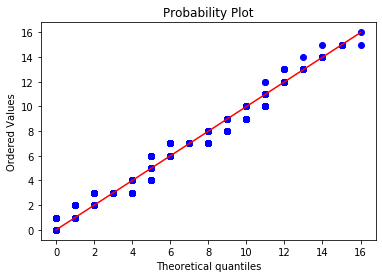

4194304
---- Normalized data ----
Mean: 3.9999818801879883; expected: 4; difference: 1.811981201171875e-05
Std: 3.993395805030559; expected: 4; difference: 0.006604194969440869
difference between std and mean :0.00658607515742915
MWU: MannwhitneyuResult(statistic=141.0, pvalue=0.4588471639749423)
Levene: LeveneResult(statistic=5.310516745564465e-07, pvalue=0.9994230794083784)


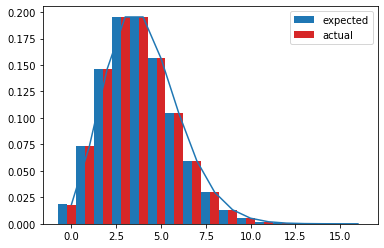

---- Sample data ----
MWU: MannwhitneyuResult(statistic=82.0, pvalue=0.01580388521715741)
Levene: LeveneResult(statistic=0.01119340618012905, pvalue=0.9164023585712804)


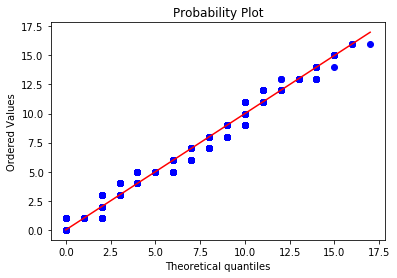

8388608
---- Normalized data ----
Mean: 3.999990463256836; expected: 4; difference: 9.5367431640625e-06
Std: 3.993089675812371; expected: 4; difference: 0.006910324187629158
difference between std and mean :0.006900787444465095
MWU: MannwhitneyuResult(statistic=180.0, pvalue=0.5)
Levene: LeveneResult(statistic=2.335445992992895e-07, pvalue=0.9996170788010148)


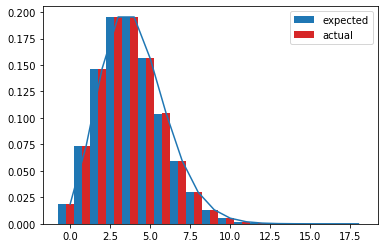

---- Sample data ----
MWU: MannwhitneyuResult(statistic=101.0, pvalue=0.010111276988944767)
Levene: LeveneResult(statistic=0.0024901172092874012, pvalue=0.9604770641000676)


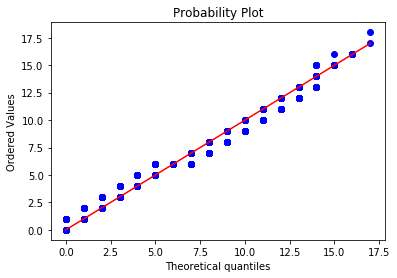

16777216
---- Normalized data ----
Mean: 3.999994993209839; expected: 4; difference: 5.0067901611328125e-06
Std: 3.998709917043414; expected: 4; difference: 0.0012900829565860583
difference between std and mean :0.0012850761664249255
MWU: MannwhitneyuResult(statistic=162.0, pvalue=0.4936888695222025)
Levene: LeveneResult(statistic=1.9589354111633584e-08, pvalue=0.9998891445146243)


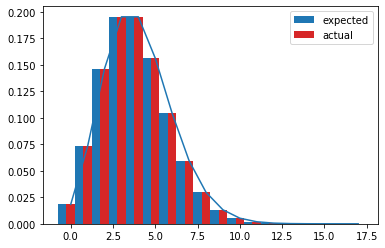

---- Sample data ----
MWU: MannwhitneyuResult(statistic=91.5, pvalue=0.012976438363224466)
Levene: LeveneResult(statistic=0.0054030034896098665, pvalue=0.9418349123051503)


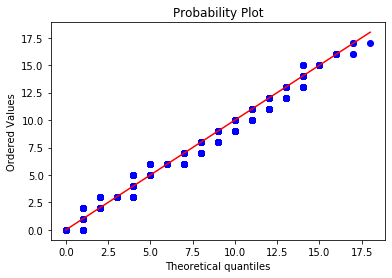

33554432
---- Normalized data ----
Mean: 3.99999737739563; expected: 4; difference: 2.6226043701171875e-06
Std: 3.9978449344566234; expected: 4; difference: 0.002155065543376633
difference between std and mean :0.002152442939006516
MWU: MannwhitneyuResult(statistic=180.0, pvalue=0.5)
Levene: LeveneResult(statistic=1.3157984770414013e-11, pvalue=0.999997125840975)


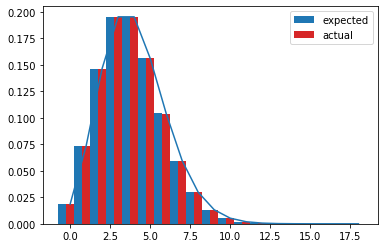

---- Sample data ----
MWU: MannwhitneyuResult(statistic=102.5, pvalue=0.011507401360997255)
Levene: LeveneResult(statistic=0.0025246042136124257, pvalue=0.9602045527573481)


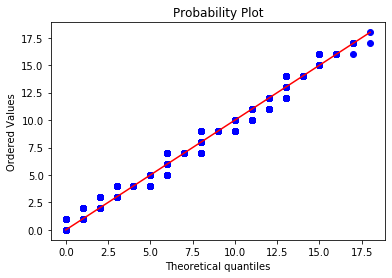

In [360]:
perform_test(seq='rule30',lamb=4)

### Rule 30 with lambda = 32 from N=2ˆ10 up to 2ˆ26

1024
---- Normalized data ----
Mean: 31.875; expected: 32; difference: 0.125
Std: 21.609375; expected: 32; difference: 10.390625
difference between std and mean :10.265625
MWU: MannwhitneyuResult(statistic=553.0, pvalue=0.0005533038940756862)
Levene: LeveneResult(statistic=0.08578826211489415, pvalue=0.7703237146545907)


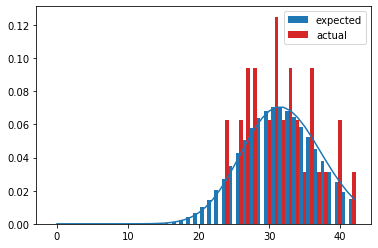

---- Sample data ----
MWU: MannwhitneyuResult(statistic=730.5, pvalue=0.011922955214343455)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


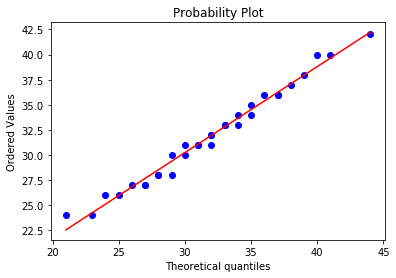

2048
---- Normalized data ----
Mean: 31.921875; expected: 32; difference: 0.078125
Std: 28.634521484375; expected: 32; difference: 3.365478515625
difference between std and mean :3.287353515625
MWU: MannwhitneyuResult(statistic=693.0, pvalue=0.022053222803427187)
Levene: LeveneResult(statistic=0.12148026513650989, pvalue=0.7283065927739139)


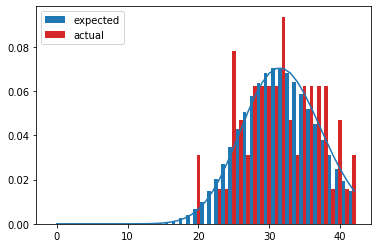

---- Sample data ----
MWU: MannwhitneyuResult(statistic=612.5, pvalue=0.0004609166920790726)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


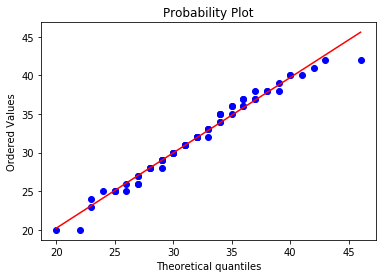

4096
---- Normalized data ----
Mean: 31.953125; expected: 32; difference: 0.046875
Std: 35.154052734375; expected: 32; difference: 3.154052734375
difference between std and mean :3.200927734375
MWU: MannwhitneyuResult(statistic=963.0, pvalue=0.045140087544489525)
Levene: LeveneResult(statistic=0.007409743558570606, pvalue=0.9315822076408832)


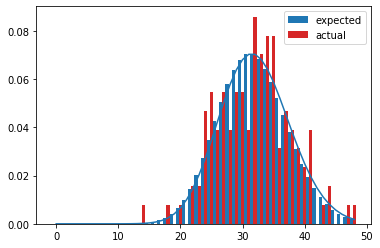

---- Sample data ----
MWU: MannwhitneyuResult(statistic=714.5, pvalue=2.0584188424427145e-05)
Levene: LeveneResult(statistic=0.004903964037597048, pvalue=0.9443167967406659)


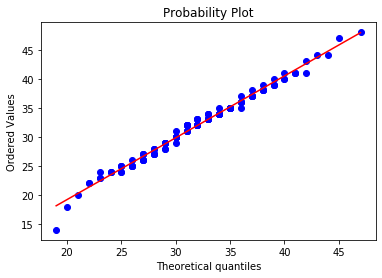

8192
---- Normalized data ----
Mean: 31.97265625; expected: 32; difference: 0.02734375
Std: 34.83128356933594; expected: 32; difference: 2.8312835693359375
difference between std and mean :2.8586273193359375
MWU: MannwhitneyuResult(statistic=1101.0, pvalue=0.05087465482129451)
Levene: LeveneResult(statistic=0.001931950284863303, pvalue=0.9650270382033688)


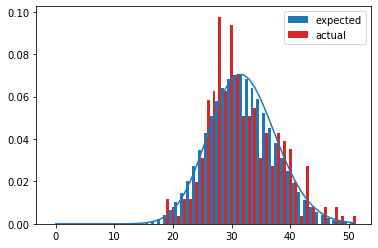

---- Sample data ----
MWU: MannwhitneyuResult(statistic=766.5, pvalue=3.7101120070079023e-06)
Levene: LeveneResult(statistic=0.0029184236220641535, pvalue=0.9570229573466993)


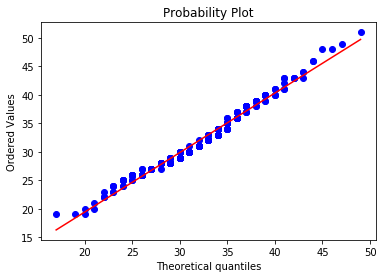

16384
---- Normalized data ----
Mean: 31.984375; expected: 32; difference: 0.015625
Std: 31.761474609375; expected: 32; difference: 0.238525390625
difference between std and mean :0.222900390625
MWU: MannwhitneyuResult(statistic=1024.0, pvalue=0.17450089054115442)
Levene: LeveneResult(statistic=0.00020573598880034853, pvalue=0.9885863348036444)


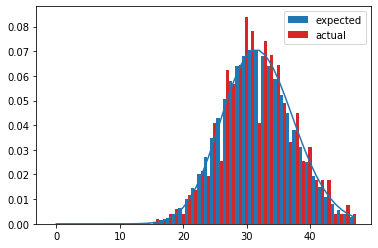

---- Sample data ----
MWU: MannwhitneyuResult(statistic=563.0, pvalue=5.172374448960698e-07)
Levene: LeveneResult(statistic=0.010430403318791586, pvalue=0.9188715557938564)


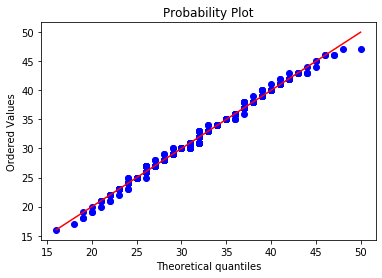

32768
---- Normalized data ----
Mean: 31.9912109375; expected: 32; difference: 0.0087890625
Std: 29.80363368988037; expected: 32; difference: 2.196366310119629
difference between std and mean :2.187577247619629
MWU: MannwhitneyuResult(statistic=1566.0, pvalue=0.06535350404816631)
Levene: LeveneResult(statistic=1.0914024346858238e-05, pvalue=0.9973695687565693)


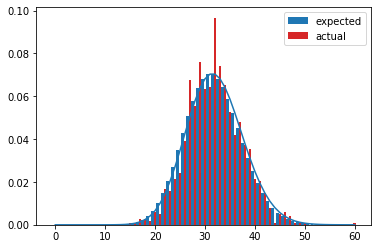

---- Sample data ----
MWU: MannwhitneyuResult(statistic=987.5, pvalue=1.0009036326052543e-07)
Levene: LeveneResult(statistic=0.00047847513090116584, pvalue=0.9825847362503926)


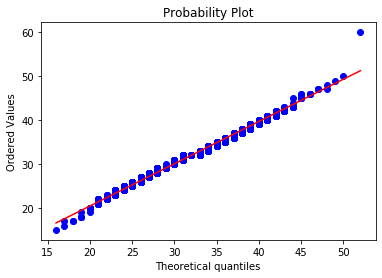

65536
---- Normalized data ----
Mean: 31.9951171875; expected: 32; difference: 0.0048828125
Std: 32.19626522064209; expected: 32; difference: 0.19626522064208984
difference between std and mean :0.20114803314208984
MWU: MannwhitneyuResult(statistic=1430.0, pvalue=0.21139169999614366)
Levene: LeveneResult(statistic=0.00017481673807293442, pvalue=0.9894747655188023)


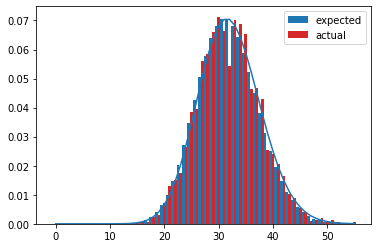

---- Sample data ----
MWU: MannwhitneyuResult(statistic=721.0, pvalue=1.655347922111854e-08)
Levene: LeveneResult(statistic=0.0015494235766191876, pvalue=0.9686725558862761)


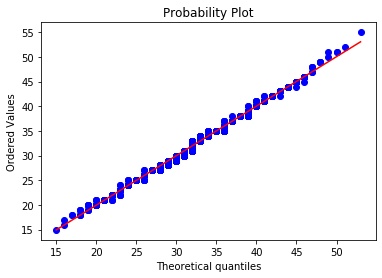

131072
---- Normalized data ----
Mean: 31.997314453125; expected: 32; difference: 0.002685546875
Std: 30.987053334712982; expected: 32; difference: 1.0129466652870178
difference between std and mean :1.0102611184120178
MWU: MannwhitneyuResult(statistic=1367.0, pvalue=0.19264025832121245)
Levene: LeveneResult(statistic=0.0017781939998697698, pvalue=0.9664421252141534)


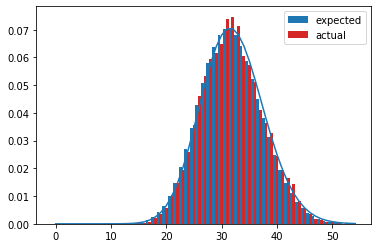

---- Sample data ----
MWU: MannwhitneyuResult(statistic=692.0, pvalue=2.6587072096783707e-08)
Levene: LeveneResult(statistic=0.0012236104493805618, pvalue=0.9721601447541299)


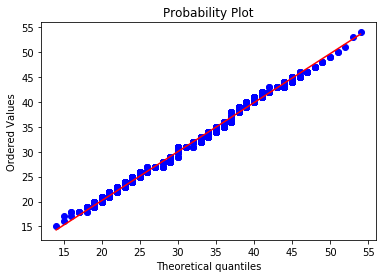

262144
---- Normalized data ----
Mean: 31.99853515625; expected: 32; difference: 0.00146484375
Std: 31.907468557357788; expected: 32; difference: 0.09253144264221191
difference between std and mean :0.09106659889221191
MWU: MannwhitneyuResult(statistic=1426.0, pvalue=0.3034305786198833)
Levene: LeveneResult(statistic=9.779303760746389e-05, pvalue=0.9921280633815416)


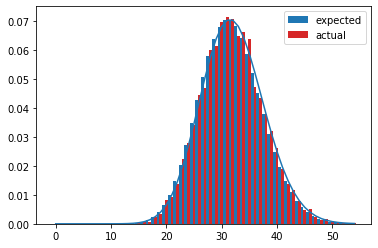

---- Sample data ----
MWU: MannwhitneyuResult(statistic=616.0, pvalue=2.4203154265569214e-09)
Levene: LeveneResult(statistic=0.002309213005445217, pvalue=0.9617617423496214)


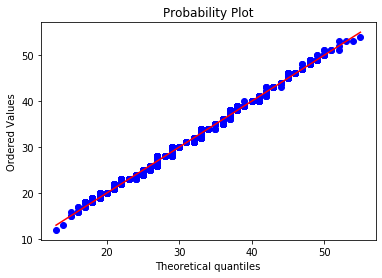

524288
---- Normalized data ----
Mean: 31.99920654296875; expected: 32; difference: 0.00079345703125
Std: 31.85272153839469; expected: 32; difference: 0.14727846160531044
difference between std and mean :0.14648500457406044
MWU: MannwhitneyuResult(statistic=1512.0, pvalue=0.2625678666326824)
Levene: LeveneResult(statistic=3.559408472515538e-05, pvalue=0.9952504005838402)


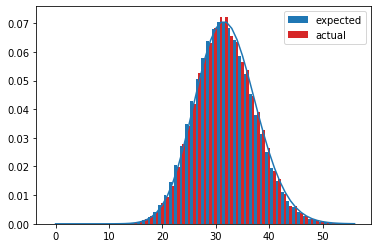

---- Sample data ----
MWU: MannwhitneyuResult(statistic=692.5, pvalue=2.9640563574044505e-09)
Levene: LeveneResult(statistic=0.0018258676854814374, pvalue=0.9659927123744088)


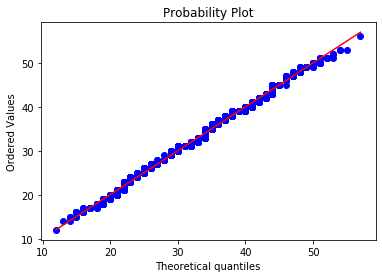

1048576
---- Normalized data ----
Mean: 31.99957275390625; expected: 32; difference: 0.00042724609375
Std: 31.315002258867025; expected: 32; difference: 0.6849977411329746
difference between std and mean :0.6845704950392246
MWU: MannwhitneyuResult(statistic=1640.0, pvalue=0.29505410314866065)
Levene: LeveneResult(statistic=9.289764978166695e-05, pvalue=0.992326390849747)


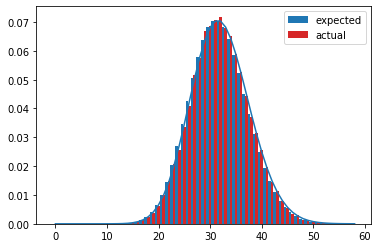

---- Sample data ----
MWU: MannwhitneyuResult(statistic=697.5, pvalue=3.9145455438256634e-10)
Levene: LeveneResult(statistic=0.0007290012030082236, pvalue=0.9785061112321963)


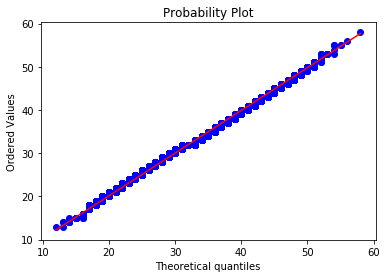

2097152
---- Normalized data ----
Mean: 31.999771118164062; expected: 32; difference: 0.0002288818359375
Std: 31.793533272808418; expected: 32; difference: 0.20646672719158232
difference between std and mean :0.20623784535564482
MWU: MannwhitneyuResult(statistic=1690.0, pvalue=0.2825825808813537)
Levene: LeveneResult(statistic=1.3985175383930265e-05, pvalue=0.9970224922897492)


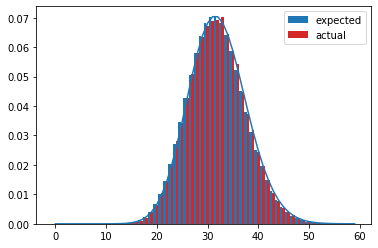

---- Sample data ----
MWU: MannwhitneyuResult(statistic=713.5, pvalue=2.147014794168859e-10)
Levene: LeveneResult(statistic=0.0006357617269238529, pvalue=0.9799266091420507)


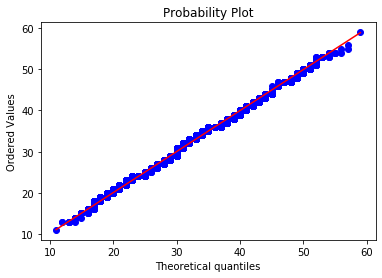

4194304
---- Normalized data ----
Mean: 31.9998779296875; expected: 32; difference: 0.0001220703125
Std: 31.850326523184776; expected: 32; difference: 0.1496734768152237
difference between std and mean :0.1495514065027237
MWU: MannwhitneyuResult(statistic=1809.0, pvalue=0.39696132030239184)
Levene: LeveneResult(statistic=1.01280008205296e-05, pvalue=0.9974660594781415)


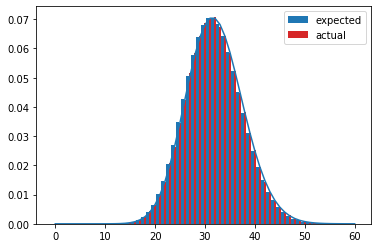

---- Sample data ----
MWU: MannwhitneyuResult(statistic=623.0, pvalue=4.51636996214342e-12)
Levene: LeveneResult(statistic=0.0004969336534231829, pvalue=0.9822520486900048)


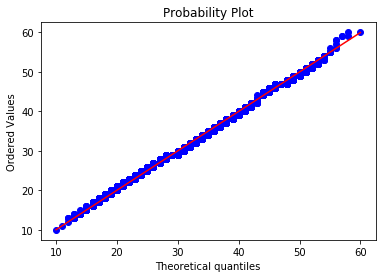

8388608
---- Normalized data ----
Mean: 31.999935150146484; expected: 32; difference: 6.4849853515625e-05
Std: 32.00738143500348; expected: 32; difference: 0.007381435003480874
difference between std and mean :0.007446284856996499
MWU: MannwhitneyuResult(statistic=1789.0, pvalue=0.3580316293164489)
Levene: LeveneResult(statistic=3.344808974090373e-06, pvalue=0.9985438010696989)


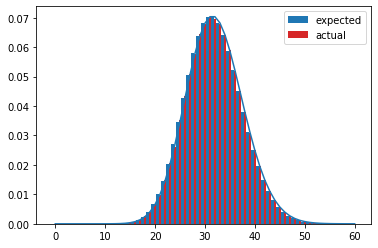

---- Sample data ----
MWU: MannwhitneyuResult(statistic=687.5, pvalue=5.0540965482061844e-11)
Levene: LeveneResult(statistic=0.0005240733365238766, pvalue=0.9817739282495166)


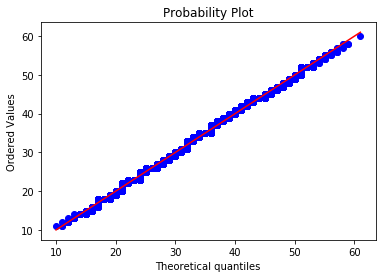

16777216
---- Normalized data ----
Mean: 31.99996566772461; expected: 32; difference: 3.4332275390625e-05
Std: 31.948577879680663; expected: 32; difference: 0.05142212031933724
difference between std and mean :0.051387788043946614
MWU: MannwhitneyuResult(statistic=2016.0, pvalue=0.440325449602017)
Levene: LeveneResult(statistic=1.2089102235994794e-06, pvalue=0.9991244613701284)


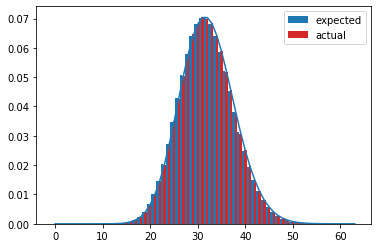

---- Sample data ----
MWU: MannwhitneyuResult(statistic=652.0, pvalue=6.887064182406179e-13)
Levene: LeveneResult(statistic=0.00023061200740108291, pvalue=0.9879078783190122)


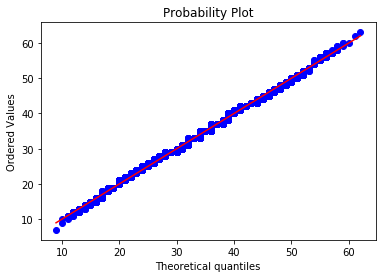

33554432
---- Normalized data ----
Mean: 31.99998188018799; expected: 32; difference: 1.811981201171875e-05
Std: 31.93394184079716; expected: 32; difference: 0.0660581592028393
difference between std and mean :0.06604003939082759
MWU: MannwhitneyuResult(statistic=1950.0, pvalue=0.43411200294930163)
Levene: LeveneResult(statistic=3.2848225574355587e-07, pvalue=0.9995436265100804)


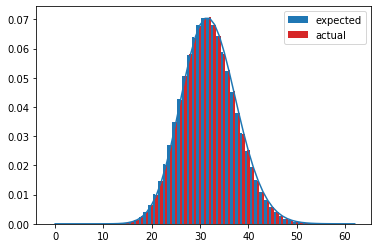

---- Sample data ----
MWU: MannwhitneyuResult(statistic=613.0, pvalue=6.034620681612968e-13)
Levene: LeveneResult(statistic=0.0003180379303222143, pvalue=0.9858002489284723)


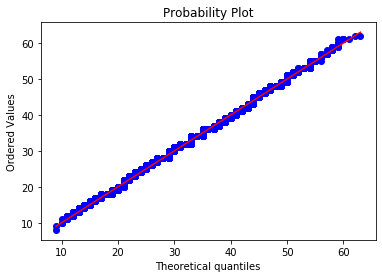

In [361]:
perform_test(seq='rule30',lamb=32)

### Levin Theorem 1 with lambda = 1 from N=2ˆ10 up to 2ˆ26

1024
---- Normalized data ----
Mean: 0.9912109375; expected: 1; difference: 0.0087890625
Std: 0.9833211898803711; expected: 1; difference: 0.016678810119628906
difference between std and mean :0.007889747619628906
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=8.776637914375136e-05, pvalue=0.9926791778724976)


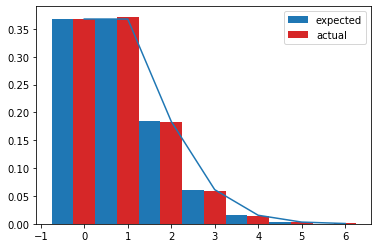

---- Sample data ----
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=0.0005721990722957498, pvalue=0.9813090508970307)


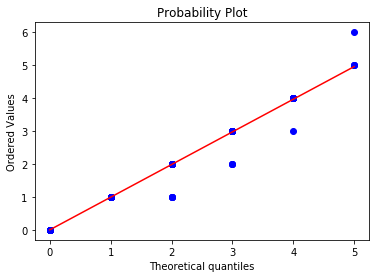

2048
---- Normalized data ----
Mean: 0.9951171875; expected: 1; difference: 0.0048828125
Std: 1.0839605331420898; expected: 1; difference: 0.08396053314208984
difference between std and mean :0.08884334564208984
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=0.0011071510246211417, pvalue=0.9740032371569219)


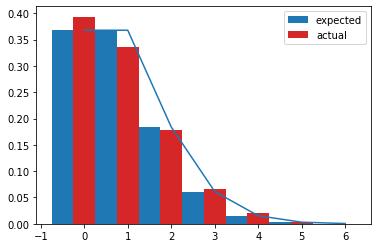

---- Sample data ----
MWU: MannwhitneyuResult(statistic=24.5, pvalue=0.47450184322152916)
Levene: LeveneResult(statistic=0.0009884305964354173, pvalue=0.9754360481837067)


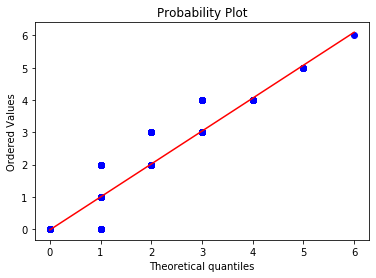

4096
---- Normalized data ----
Mean: 0.997314453125; expected: 1; difference: 0.002685546875
Std: 0.8005298972129822; expected: 1; difference: 0.19947010278701782
difference between std and mean :0.19678455591201782
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491077413427273)
Levene: LeveneResult(statistic=0.004545800417130917, pvalue=0.9473556788094252)


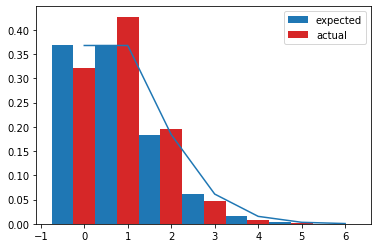

---- Sample data ----
MWU: MannwhitneyuResult(statistic=25.0, pvalue=0.38616872064639024)
Levene: LeveneResult(statistic=0.03317900777519295, pvalue=0.8582738709031997)


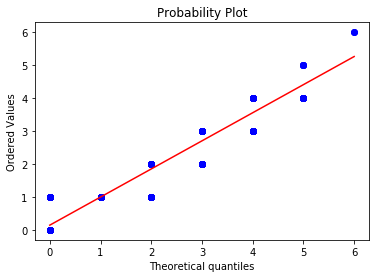

8192
---- Normalized data ----
Mean: 0.99853515625; expected: 1; difference: 0.00146484375
Std: 0.6853005886077881; expected: 1; difference: 0.3146994113922119
difference between std and mean :0.3132345676422119
MWU: MannwhitneyuResult(statistic=17.0, pvalue=0.46803733853330987)
Levene: LeveneResult(statistic=0.060441428929756194, pvalue=0.8107719838912105)


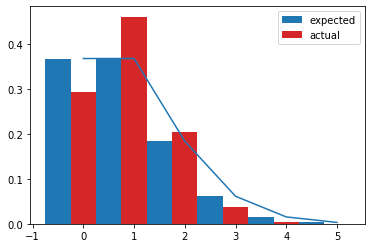

---- Sample data ----
MWU: MannwhitneyuResult(statistic=20.5, pvalue=0.34910990968996375)
Levene: LeveneResult(statistic=0.24477434255152572, pvalue=0.6297127169108255)


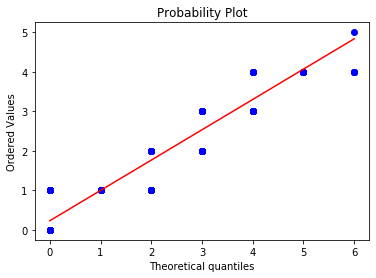

16384
---- Normalized data ----
Mean: 0.99920654296875; expected: 1; difference: 0.00079345703125
Std: 0.7717889212071896; expected: 1; difference: 0.22821107879281044
difference between std and mean :0.22741762176156044
MWU: MannwhitneyuResult(statistic=17.0, pvalue=0.46803733853330987)
Levene: LeveneResult(statistic=0.032099468186346916, pvalue=0.8613875714983327)


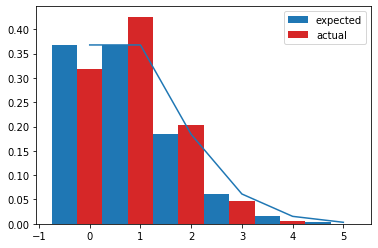

---- Sample data ----
MWU: MannwhitneyuResult(statistic=20.0, pvalue=0.3256892232381963)
Levene: LeveneResult(statistic=0.2010685342595043, pvalue=0.6618488687777441)


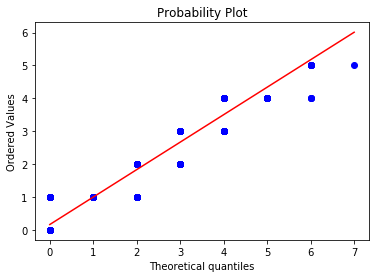

32768
---- Normalized data ----
Mean: 0.99957275390625; expected: 1; difference: 0.00042724609375
Std: 0.8195188604295254; expected: 1; difference: 0.18048113957047462
difference between std and mean :0.18005389347672462
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491077413427273)
Levene: LeveneResult(statistic=0.004025077962252427, pvalue=0.9504579133586402)


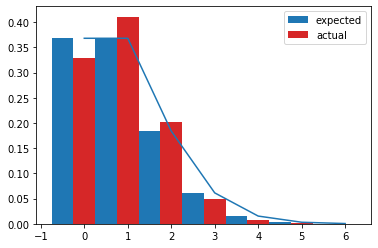

---- Sample data ----
MWU: MannwhitneyuResult(statistic=27.0, pvalue=0.4769285765308018)
Levene: LeveneResult(statistic=0.03336634970929739, pvalue=0.8578790618706043)


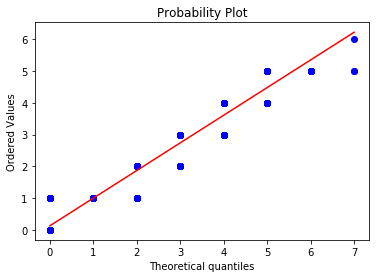

65536
---- Normalized data ----
Mean: 0.9997711181640625; expected: 1; difference: 0.0002288818359375
Std: 0.8770293665584177; expected: 1; difference: 0.12297063344158232
difference between std and mean :0.12274175160564482
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491077413427273)
Levene: LeveneResult(statistic=0.0016277601192007266, pvalue=0.9684811597700714)


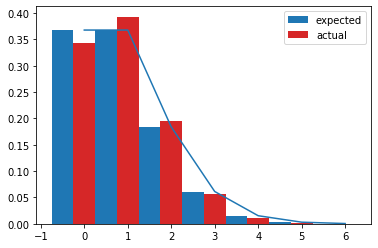

---- Sample data ----
MWU: MannwhitneyuResult(statistic=26.0, pvalue=0.4310933472003812)
Levene: LeveneResult(statistic=0.026070983445414933, pvalue=0.8742094820959011)


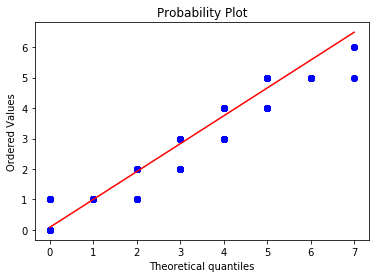

131072
---- Normalized data ----
Mean: 0.9998779296875; expected: 1; difference: 0.0001220703125
Std: 0.9131927341222763; expected: 1; difference: 0.0868072658777237
difference between std and mean :0.0866851955652237
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491077413427273)
Levene: LeveneResult(statistic=0.0008085256167236983, pvalue=0.9777829627355786)


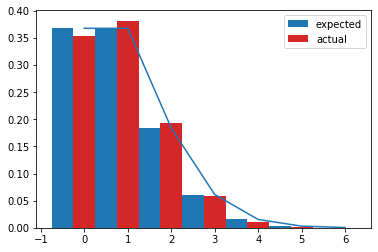

---- Sample data ----
MWU: MannwhitneyuResult(statistic=27.0, pvalue=0.33599993550481)
Levene: LeveneResult(statistic=0.09900466991115267, pvalue=0.7576677844559139)


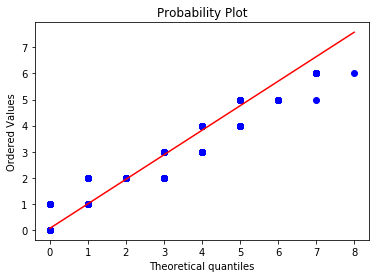

262144
---- Normalized data ----
Mean: 0.9999351501464844; expected: 1; difference: 6.4849853515625e-05
Std: 0.8943519550230121; expected: 1; difference: 0.10564804497698788
difference between std and mean :0.10558319512347225
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491077413427273)
Levene: LeveneResult(statistic=0.0012601616054561799, pvalue=0.9722657155534001)


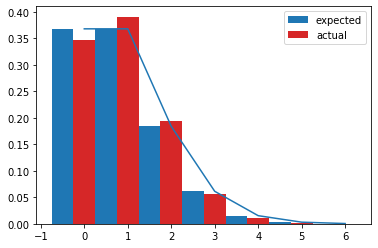

---- Sample data ----
MWU: MannwhitneyuResult(statistic=26.0, pvalue=0.4310933472003812)
Levene: LeveneResult(statistic=0.025387935542004664, pvalue=0.8758531008702899)


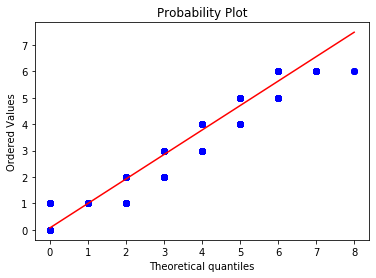

524288
---- Normalized data ----
Mean: 0.9999656677246094; expected: 1; difference: 3.4332275390625e-05
Std: 0.871601103557623; expected: 1; difference: 0.128398896442377
difference between std and mean :0.12836456416698638
MWU: MannwhitneyuResult(statistic=30.0, pvalue=0.4373672980510328)
Levene: LeveneResult(statistic=0.0007158047185684823, pvalue=0.9790331529368603)


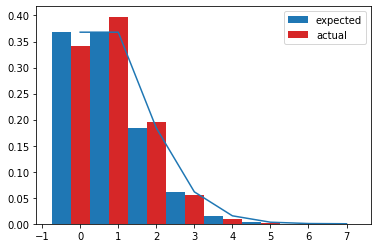

---- Sample data ----
MWU: MannwhitneyuResult(statistic=35.0, pvalue=0.24128581590841808)
Levene: LeveneResult(statistic=0.22358853146137728, pvalue=0.6423332614177036)


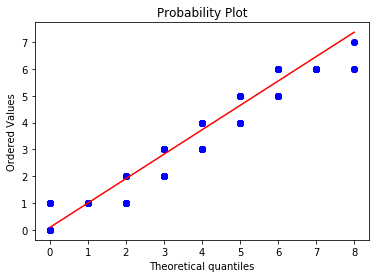

1048576
---- Normalized data ----
Mean: 0.9999818801879883; expected: 1; difference: 1.811981201171875e-05
Std: 0.9391775127942311; expected: 1; difference: 0.06082248720576888
difference between std and mean :0.060804367393757164
MWU: MannwhitneyuResult(statistic=30.0, pvalue=0.4373672980510328)
Levene: LeveneResult(statistic=0.00031309949478888603, pvalue=0.9861321779511801)


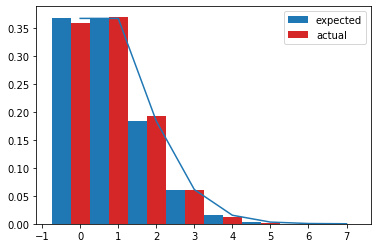

---- Sample data ----
MWU: MannwhitneyuResult(statistic=35.0, pvalue=0.34463884358747554)
Levene: LeveneResult(statistic=0.10894528497296113, pvalue=0.7456303148265173)


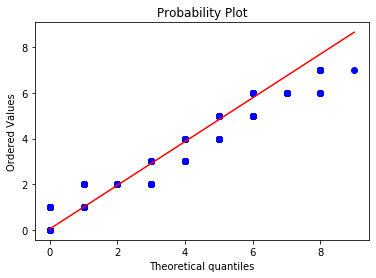

2097152
---- Normalized data ----
Mean: 0.9999904632568359; expected: 1; difference: 9.5367431640625e-06
Std: 0.7987861632391285; expected: 1; difference: 0.20121383676087146
difference between std and mean :0.2012043000177074
MWU: MannwhitneyuResult(statistic=29.0, pvalue=0.396373263496624)
Levene: LeveneResult(statistic=0.0014548241162623736, pvalue=0.9701128988500801)


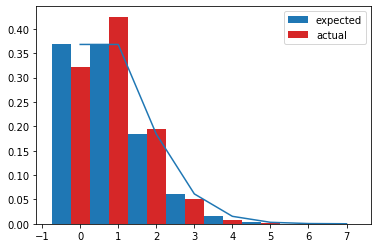

---- Sample data ----
MWU: MannwhitneyuResult(statistic=36.5, pvalue=0.28154441429709653)
Levene: LeveneResult(statistic=0.22724244276600913, pvalue=0.6396459975518354)


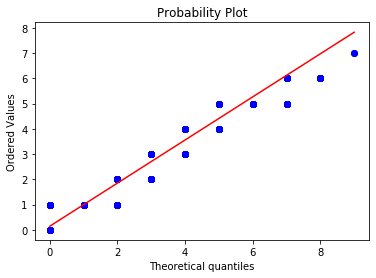

4194304
---- Normalized data ----
Mean: 0.9999949932098389; expected: 1; difference: 5.0067901611328125e-06
Std: 0.7948310374962944; expected: 1; difference: 0.20516896250370564
difference between std and mean :0.2051639557135445
MWU: MannwhitneyuResult(statistic=29.0, pvalue=0.396373263496624)
Levene: LeveneResult(statistic=0.0016550789775887358, pvalue=0.9681233713584687)


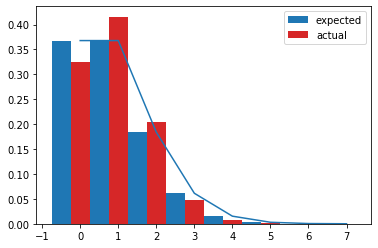

---- Sample data ----
MWU: MannwhitneyuResult(statistic=37.0, pvalue=0.41210601955165976)
Levene: LeveneResult(statistic=0.11765712321422216, pvalue=0.7360548548301121)


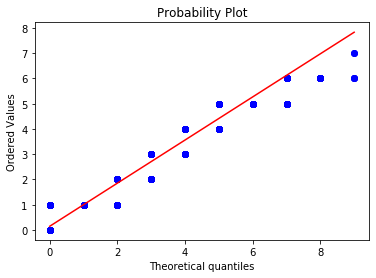

8388608
---- Normalized data ----
Mean: 0.9999973773956299; expected: 1; difference: 2.6226043701171875e-06
Std: 0.9436640739372137; expected: 1; difference: 0.05633592606278626
difference between std and mean :0.05633330345841614
MWU: MannwhitneyuResult(statistic=28.0, pvalue=0.35649474372537043)
Levene: LeveneResult(statistic=0.0005259057121294587, pvalue=0.9820276644542311)


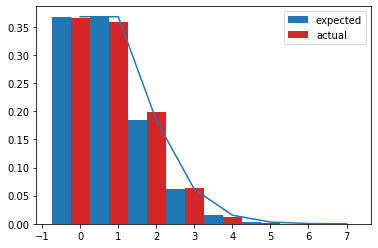

---- Sample data ----
MWU: MannwhitneyuResult(statistic=37.0, pvalue=0.2957305762607999)
Levene: LeveneResult(statistic=0.2290745201478628, pvalue=0.6383086504033825)


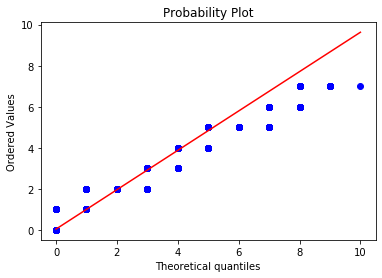

16777216
---- Normalized data ----
Mean: 0.9999986290931702; expected: 1; difference: 1.3709068298339844e-06
Std: 1.1040838360767644; expected: 1; difference: 0.10408383607676441
difference between std and mean :0.10408520698359425
MWU: MannwhitneyuResult(statistic=32.0, pvalue=0.4790455641133508)
Levene: LeveneResult(statistic=0.00010099665715123896, pvalue=0.9921234320314098)


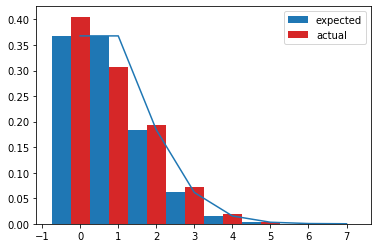

---- Sample data ----
MWU: MannwhitneyuResult(statistic=33.0, pvalue=0.19296854881977765)
Levene: LeveneResult(statistic=0.20422178893555487, pvalue=0.6570471896662387)


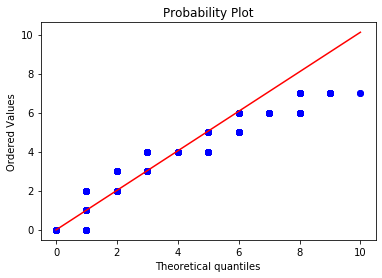

33554432
---- Normalized data ----
Mean: 0.9999992847442627; expected: 1; difference: 7.152557373046875e-07
Std: 1.0317541956896437; expected: 1; difference: 0.03175419568964366
difference between std and mean :0.031754910945380965
MWU: MannwhitneyuResult(statistic=47.0, pvalue=0.42502551244863873)
Levene: LeveneResult(statistic=8.738767050333237e-06, pvalue=0.9976738608074706)


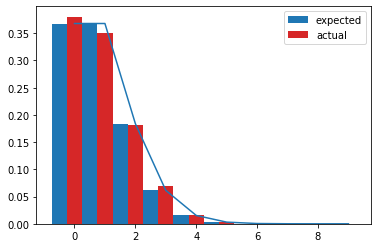

---- Sample data ----
MWU: MannwhitneyuResult(statistic=54.0, pvalue=0.4859565669766532)
Levene: LeveneResult(statistic=0.01983605245765996, pvalue=0.8894784062667762)


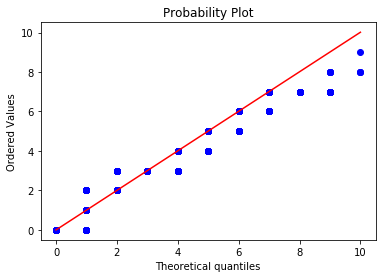

In [56]:
perform_test(seq='levin2',lamb=1)

### Levin Theorem 1 with lambda = 4 from N=2ˆ10 up to 2ˆ26

1024
---- Normalized data ----
Mean: 3.97265625; expected: 4; difference: 0.02734375
Std: 3.2609710693359375; expected: 4; difference: 0.7390289306640625
difference between std and mean :0.7116851806640625
MWU: MannwhitneyuResult(statistic=55.0, pvalue=0.37126281522760934)
Levene: LeveneResult(statistic=0.05297293300895509, pvalue=0.820306368695789)


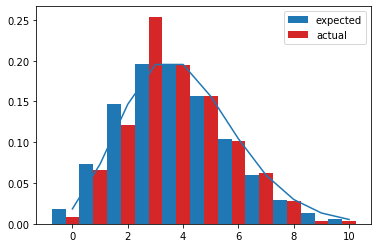

---- Sample data ----
MWU: MannwhitneyuResult(statistic=40.0, pvalue=0.0930357347863382)
Levene: LeveneResult(statistic=0.2946659450357811, pvalue=0.593244415015036)


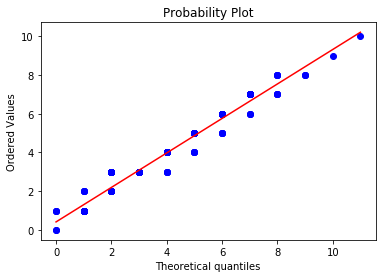

2048
---- Normalized data ----
Mean: 3.984375; expected: 4; difference: 0.015625
Std: 4.019287109375; expected: 4; difference: 0.019287109375
difference between std and mean :0.034912109375
MWU: MannwhitneyuResult(statistic=60.0, pvalue=0.5)
Levene: LeveneResult(statistic=0.058520894669871135, pvalue=0.8113123507489736)


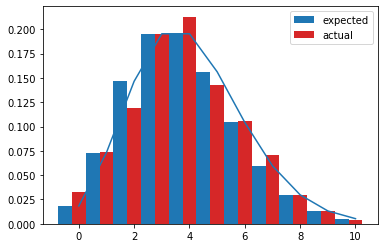

---- Sample data ----
MWU: MannwhitneyuResult(statistic=37.5, pvalue=0.06916048635429917)
Levene: LeveneResult(statistic=0.5273020230351495, pvalue=0.4761563454819817)


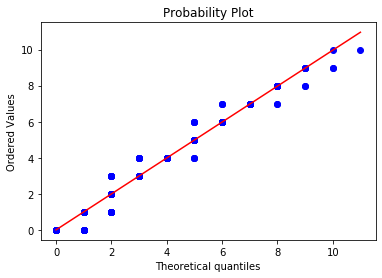

4096
---- Normalized data ----
Mean: 3.9912109375; expected: 4; difference: 0.0087890625
Std: 3.248946189880371; expected: 4; difference: 0.7510538101196289
difference between std and mean :0.7422647476196289
MWU: MannwhitneyuResult(statistic=59.0, pvalue=0.4738074922191277)
Levene: LeveneResult(statistic=0.07204773516818422, pvalue=0.7911274175335694)


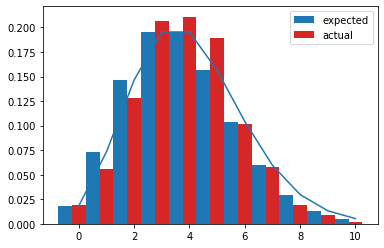

---- Sample data ----
MWU: MannwhitneyuResult(statistic=37.0, pvalue=0.06423049321807675)
Levene: LeveneResult(statistic=0.2527179496917361, pvalue=0.620658462167142)


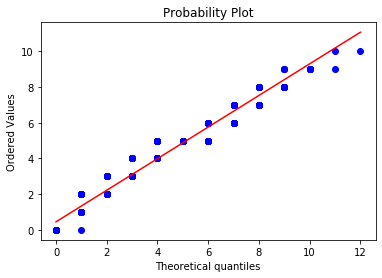

8192
---- Normalized data ----
Mean: 3.9951171875; expected: 4; difference: 0.0048828125
Std: 2.52341365814209; expected: 4; difference: 1.4765863418579102
difference between std and mean :1.4717035293579102
MWU: MannwhitneyuResult(statistic=57.0, pvalue=0.42189394196677416)
Levene: LeveneResult(statistic=0.3698043499864225, pvalue=0.5499551050612077)


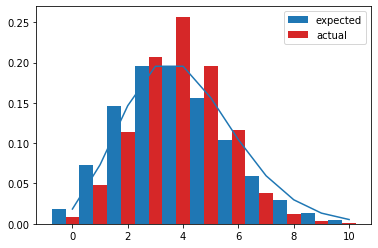

---- Sample data ----
MWU: MannwhitneyuResult(statistic=41.0, pvalue=0.10472146757954948)
Levene: LeveneResult(statistic=0.10428757939424523, pvalue=0.7500957256257623)


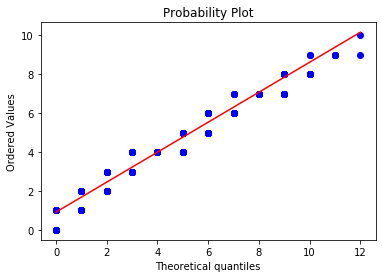

16384
---- Normalized data ----
Mean: 3.997314453125; expected: 4; difference: 0.002685546875
Std: 2.224358022212982; expected: 4; difference: 1.7756419777870178
difference between std and mean :1.7729564309120178
MWU: MannwhitneyuResult(statistic=56.0, pvalue=0.3963777156795885)
Levene: LeveneResult(statistic=0.4141925195616572, pvalue=0.5271607487342762)


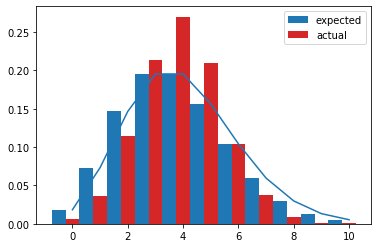

---- Sample data ----
MWU: MannwhitneyuResult(statistic=42.0, pvalue=0.11827735569770359)
Levene: LeveneResult(statistic=0.06142363076003695, pvalue=0.8067865475845408)


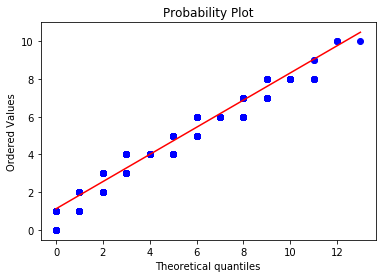

32768
---- Normalized data ----
Mean: 3.99853515625; expected: 4; difference: 0.00146484375
Std: 2.354245901107788; expected: 4; difference: 1.645754098892212
difference between std and mean :1.644289255142212
MWU: MannwhitneyuResult(statistic=57.0, pvalue=0.42189394196677416)
Levene: LeveneResult(statistic=0.3696393628758553, pvalue=0.5500433048437323)


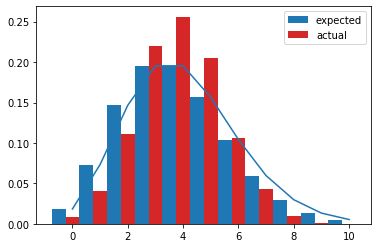

---- Sample data ----
MWU: MannwhitneyuResult(statistic=43.0, pvalue=0.13187577699515363)
Levene: LeveneResult(statistic=0.08353493752633472, pvalue=0.7755375203046911)


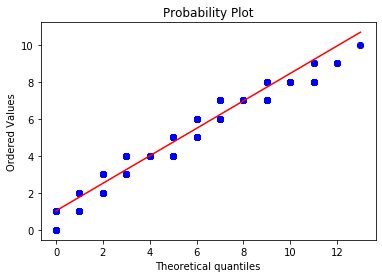

65536
---- Normalized data ----
Mean: 3.99920654296875; expected: 4; difference: 0.00079345703125
Std: 2.6782830618321896; expected: 4; difference: 1.3217169381678104
difference between std and mean :1.3209234811365604
MWU: MannwhitneyuResult(statistic=66.0, pvalue=0.37538974842591205)
Levene: LeveneResult(statistic=0.17636830972122988, pvalue=0.6785861473375163)


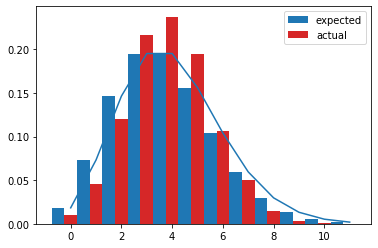

---- Sample data ----
MWU: MannwhitneyuResult(statistic=49.0, pvalue=0.09599355912356294)
Levene: LeveneResult(statistic=0.07698380318531044, pvalue=0.7840178280328999)


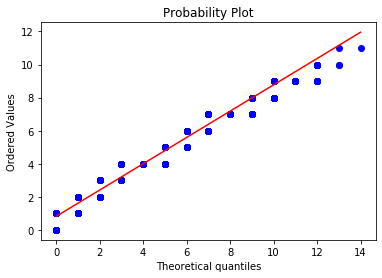

131072
---- Normalized data ----
Mean: 3.99957275390625; expected: 4; difference: 0.00042724609375
Std: 2.9346311651170254; expected: 4; difference: 1.0653688348829746
difference between std and mean :1.0649415887892246
MWU: MannwhitneyuResult(statistic=78.0, pvalue=0.3791382187772106)
Levene: LeveneResult(statistic=0.09852261480100469, pvalue=0.7563218433615082)


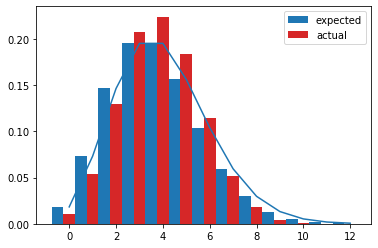

---- Sample data ----
MWU: MannwhitneyuResult(statistic=56.0, pvalue=0.0748161027584394)
Levene: LeveneResult(statistic=0.050149063055115795, pvalue=0.8246994765705947)


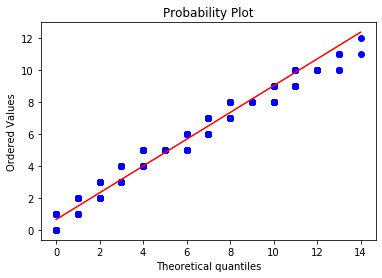

262144
---- Normalized data ----
Mean: 3.9997711181640625; expected: 4; difference: 0.0002288818359375
Std: 3.2844390345271677; expected: 4; difference: 0.7155609654728323
difference between std and mean :0.7153320836368948
MWU: MannwhitneyuResult(statistic=80.0, pvalue=0.418722279223758)
Levene: LeveneResult(statistic=0.03683381806314323, pvalue=0.8494183710794351)


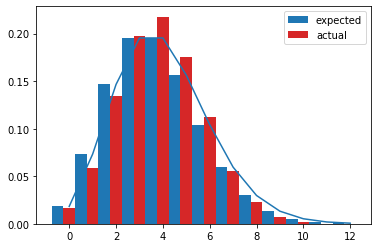

---- Sample data ----
MWU: MannwhitneyuResult(statistic=54.5, pvalue=0.06480100615142126)
Levene: LeveneResult(statistic=0.0828609345331421, pvalue=0.775928300099625)


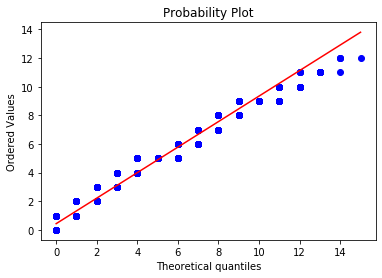

524288
---- Normalized data ----
Mean: 3.9998779296875; expected: 4; difference: 0.0001220703125
Std: 3.1990508884191513; expected: 4; difference: 0.8009491115808487
difference between std and mean :0.8008270412683487
MWU: MannwhitneyuResult(statistic=104.0, pvalue=0.36999693699731134)
Levene: LeveneResult(statistic=0.012055782494367479, pvalue=0.9133521015454348)


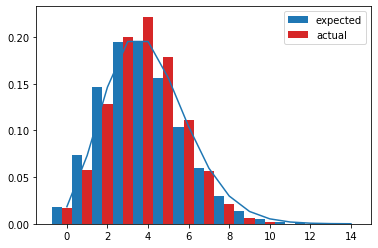

---- Sample data ----
MWU: MannwhitneyuResult(statistic=76.0, pvalue=0.06647115239225199)
Levene: LeveneResult(statistic=0.015562793789069197, pvalue=0.9016120798576093)


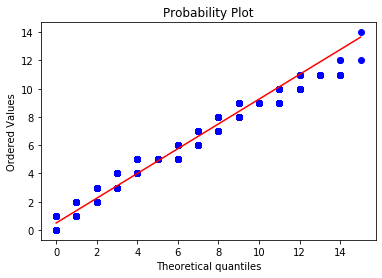

1048576
---- Normalized data ----
Mean: 3.9999351501464844; expected: 4; difference: 6.4849853515625e-05
Std: 2.9696083026792612; expected: 4; difference: 1.0303916973207388
difference between std and mean :1.0303268474672231
MWU: MannwhitneyuResult(statistic=90.0, pvalue=0.36517696447175224)
Levene: LeveneResult(statistic=0.03893393576841664, pvalue=0.8451140604387092)


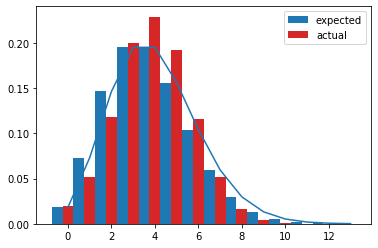

---- Sample data ----
MWU: MannwhitneyuResult(statistic=63.0, pvalue=0.055968013677305806)
Levene: LeveneResult(statistic=0.021405993880261116, pvalue=0.8848068519319019)


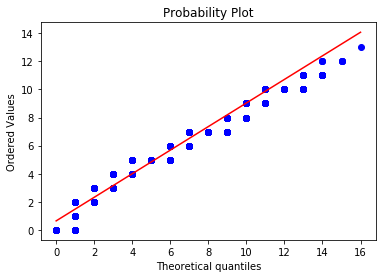

2097152
---- Normalized data ----
Mean: 3.9999656677246094; expected: 4; difference: 3.4332275390625e-05
Std: 3.00680541874317; expected: 4; difference: 0.9931945812568301
difference between std and mean :0.9931602489814395
MWU: MannwhitneyuResult(statistic=79.0, pvalue=0.39880010979147085)
Levene: LeveneResult(statistic=0.07073548894570014, pvalue=0.7925403752051813)


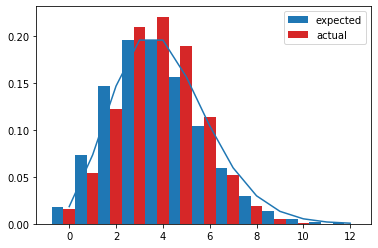

---- Sample data ----
MWU: MannwhitneyuResult(statistic=54.0, pvalue=0.06164645006380576)
Levene: LeveneResult(statistic=0.060342402964386796, pvalue=0.8080441006284473)


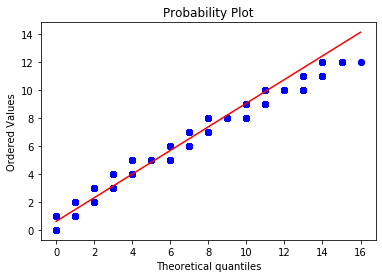

4194304
---- Normalized data ----
Mean: 3.9999818801879883; expected: 4; difference: 1.811981201171875e-05
Std: 2.4587392803723565; expected: 4; difference: 1.5412607196276435
difference between std and mean :1.5412425998156318
MWU: MannwhitneyuResult(statistic=77.0, pvalue=0.35978417715640904)
Levene: LeveneResult(statistic=0.13605217162852284, pvalue=0.7154716721987625)


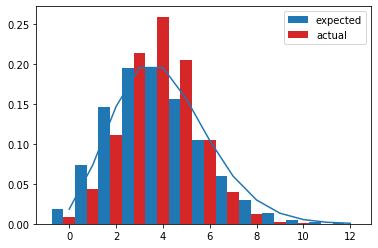

---- Sample data ----
MWU: MannwhitneyuResult(statistic=59.0, pvalue=0.09975851117793055)
Levene: LeveneResult(statistic=0.025508895563993814, pvalue=0.8744421182328175)


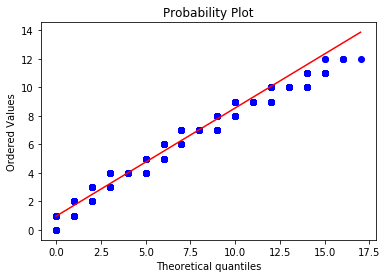

8388608
---- Normalized data ----
Mean: 3.999990463256836; expected: 4; difference: 9.5367431640625e-06
Std: 2.9907741545721374; expected: 4; difference: 1.0092258454278626
difference between std and mean :1.0092163086846986
MWU: MannwhitneyuResult(statistic=76.0, pvalue=0.3407832064733861)
Levene: LeveneResult(statistic=0.08813862109280496, pvalue=0.7691112222953111)


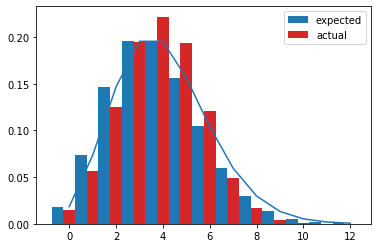

---- Sample data ----
MWU: MannwhitneyuResult(statistic=57.0, pvalue=0.08294017578300017)
Levene: LeveneResult(statistic=0.05348829888967688, pvalue=0.8190612651579521)


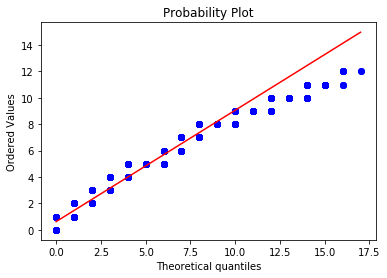

16777216
---- Normalized data ----
Mean: 3.999994993209839; expected: 4; difference: 5.0067901611328125e-06
Std: 3.3550117015587935; expected: 4; difference: 0.6449882984412065
difference between std and mean :0.6449832916510454
MWU: MannwhitneyuResult(statistic=91.0, pvalue=0.3825841746929821)
Levene: LeveneResult(statistic=0.020328513139532663, pvalue=0.8877225672501315)


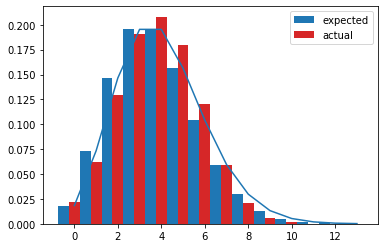

---- Sample data ----
MWU: MannwhitneyuResult(statistic=65.0, pvalue=0.06741192865159165)
Levene: LeveneResult(statistic=0.03466431054233247, pvalue=0.8537458646920364)


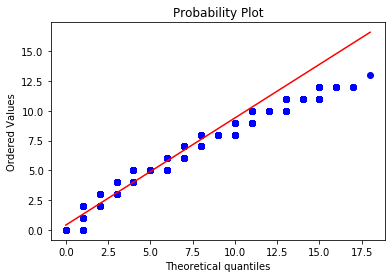

33554432
---- Normalized data ----
Mean: 3.99999737739563; expected: 4; difference: 2.6226043701171875e-06
Std: 3.3793430328300356; expected: 4; difference: 0.6206569671699644
difference between std and mean :0.6206543445655943
MWU: MannwhitneyuResult(statistic=91.0, pvalue=0.3825841746929821)
Levene: LeveneResult(statistic=0.014010223781879588, pvalue=0.9066883626455488)


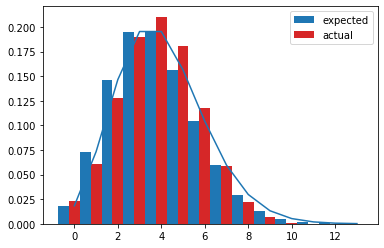

---- Sample data ----
MWU: MannwhitneyuResult(statistic=65.0, pvalue=0.06757243910762788)
Levene: LeveneResult(statistic=0.039164236958636765, pvalue=0.8446627997646882)


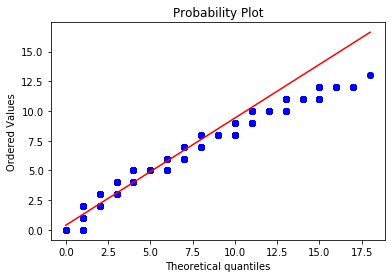

In [57]:
perform_test(seq='levin2',lamb=4)

### Levin Theorem 1 with lambda = 32 from N=2ˆ10 up to 2ˆ26

1024
---- Normalized data ----
Mean: 31.875; expected: 32; difference: 0.125
Std: 2.296875; expected: 32; difference: 29.703125
difference between std and mean :29.578125
MWU: MannwhitneyuResult(statistic=210.0, pvalue=4.810617659024067e-07)
Levene: LeveneResult(statistic=0.534875169551088, pvalue=0.4670772404259296)


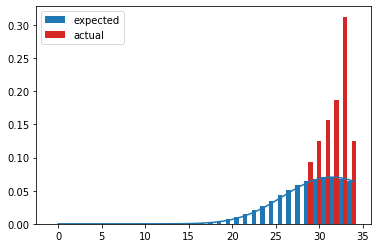

---- Sample data ----
MWU: MannwhitneyuResult(statistic=582.5, pvalue=0.28453070703275285)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


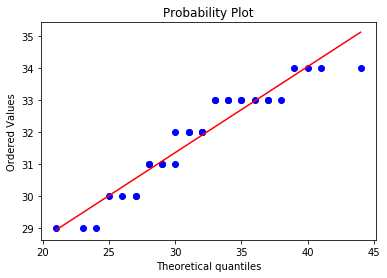

2048
---- Normalized data ----
Mean: 31.921875; expected: 32; difference: 0.078125
Std: 5.447021484375; expected: 32; difference: 26.552978515625
difference between std and mean :26.474853515625
MWU: MannwhitneyuResult(statistic=357.0, pvalue=5.339326162581746e-05)
Levene: LeveneResult(statistic=0.22892683164125993, pvalue=0.6337313314129159)


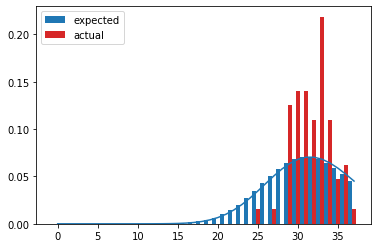

---- Sample data ----
MWU: MannwhitneyuResult(statistic=632.5, pvalue=0.10246389411290491)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


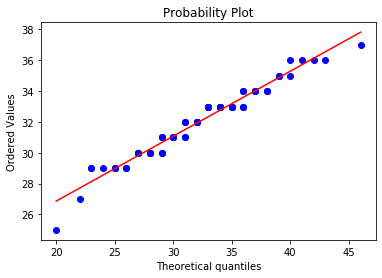

4096
---- Normalized data ----
Mean: 31.953125; expected: 32; difference: 0.046875
Std: 4.716552734375; expected: 32; difference: 27.283447265625
difference between std and mean :27.236572265625
MWU: MannwhitneyuResult(statistic=374.0, pvalue=4.0741521343437166e-05)
Levene: LeveneResult(statistic=0.14393362238276383, pvalue=0.7054593434299483)


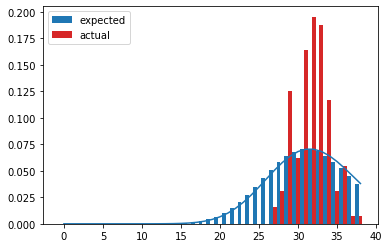

---- Sample data ----
MWU: MannwhitneyuResult(statistic=638.0, pvalue=0.04570854396001866)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


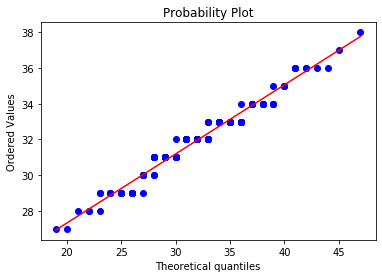

8192
---- Normalized data ----
Mean: 31.97265625; expected: 32; difference: 0.02734375
Std: 4.8703460693359375; expected: 32; difference: 27.129653930664062
difference between std and mean :27.102310180664062
MWU: MannwhitneyuResult(statistic=404.0, pvalue=0.00014427373600980396)
Levene: LeveneResult(statistic=0.15130896376476252, pvalue=0.6983753066585288)


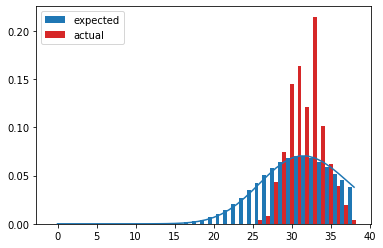

---- Sample data ----
MWU: MannwhitneyuResult(statistic=621.0, pvalue=0.029926790907093676)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


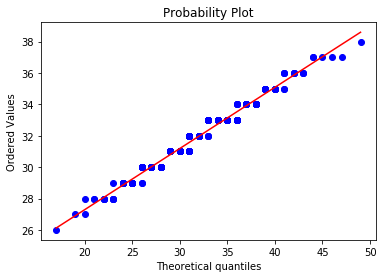

16384
---- Normalized data ----
Mean: 31.984375; expected: 32; difference: 0.015625
Std: 6.480224609375; expected: 32; difference: 25.519775390625
difference between std and mean :25.504150390625
MWU: MannwhitneyuResult(statistic=471.0, pvalue=0.0006629264645507547)
Levene: LeveneResult(statistic=0.11972472279222318, pvalue=0.7302648100146587)


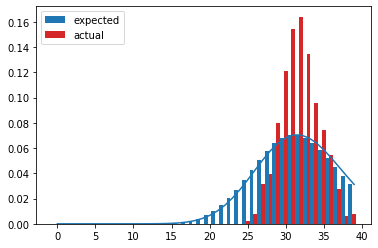

---- Sample data ----
MWU: MannwhitneyuResult(statistic=617.0, pvalue=0.010456202506025672)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


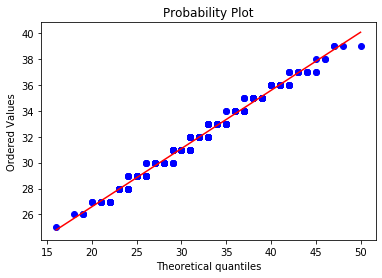

32768
---- Normalized data ----
Mean: 31.9912109375; expected: 32; difference: 0.0087890625
Std: 9.288008689880371; expected: 32; difference: 22.71199131011963
difference between std and mean :22.70320224761963
MWU: MannwhitneyuResult(statistic=585.0, pvalue=0.003679444003965013)
Levene: LeveneResult(statistic=0.0790167513623027, pvalue=0.7793424074767945)


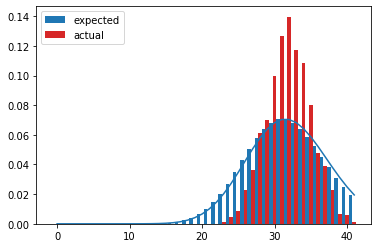

---- Sample data ----
MWU: MannwhitneyuResult(statistic=629.0, pvalue=0.00260105760285195)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


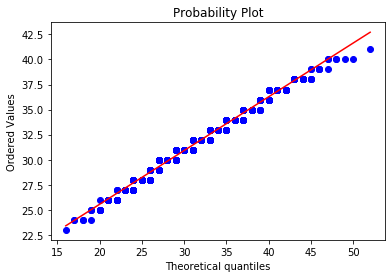

65536
---- Normalized data ----
Mean: 31.9951171875; expected: 32; difference: 0.0048828125
Std: 8.26560115814209; expected: 32; difference: 23.73439884185791
difference between std and mean :23.72951602935791
MWU: MannwhitneyuResult(statistic=591.0, pvalue=0.004364681628224923)
Levene: LeveneResult(statistic=0.07289699369229133, pvalue=0.7878428653399749)


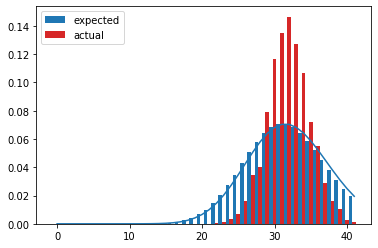

---- Sample data ----
MWU: MannwhitneyuResult(statistic=613.0, pvalue=0.001680312660964845)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


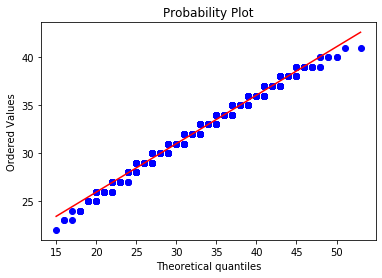

131072
---- Normalized data ----
Mean: 31.997314453125; expected: 32; difference: 0.002685546875
Std: 9.926994740962982; expected: 32; difference: 22.073005259037018
difference between std and mean :22.070319712162018
MWU: MannwhitneyuResult(statistic=655.0, pvalue=0.009630869389238936)
Levene: LeveneResult(statistic=0.07387503441110047, pvalue=0.7864430082941606)


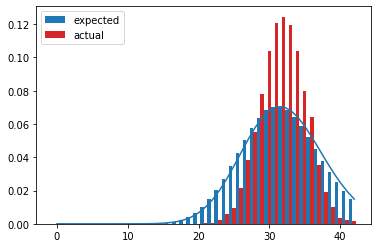

---- Sample data ----
MWU: MannwhitneyuResult(statistic=618.0, pvalue=0.0008474512988293726)
Levene: LeveneResult(statistic=6.662725981522303e-07, pvalue=0.999350658028791)


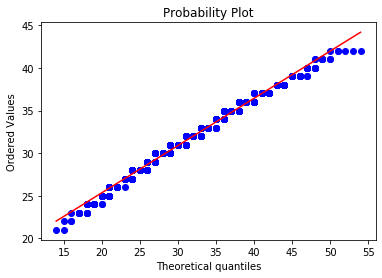

262144
---- Normalized data ----
Mean: 31.99853515625; expected: 32; difference: 0.00146484375
Std: 9.168210744857788; expected: 32; difference: 22.831789255142212
difference between std and mean :22.830324411392212
MWU: MannwhitneyuResult(statistic=697.0, pvalue=0.005260123228343288)
Levene: LeveneResult(statistic=0.06328187602370172, pvalue=0.8019685642591586)


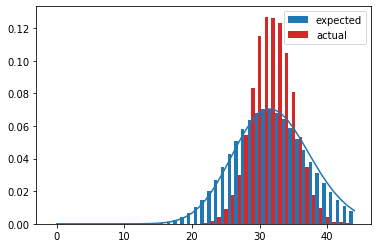

---- Sample data ----
MWU: MannwhitneyuResult(statistic=667.5, pvalue=0.0005801001316607111)
Levene: LeveneResult(statistic=3.67483661105672e-07, pvalue=0.9995176910864167)


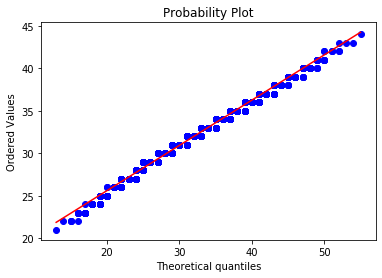

524288
---- Normalized data ----
Mean: 31.99920654296875; expected: 32; difference: 0.00079345703125
Std: 9.99932798370719; expected: 32; difference: 22.00067201629281
difference between std and mean :21.99987855926156
MWU: MannwhitneyuResult(statistic=711.0, pvalue=0.007251982720971885)
Levene: LeveneResult(statistic=0.06705944672669102, pvalue=0.7962721262470096)


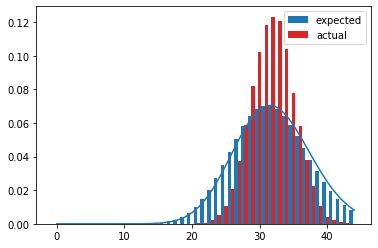

---- Sample data ----
MWU: MannwhitneyuResult(statistic=666.5, pvalue=0.0005613094631968873)
Levene: LeveneResult(statistic=5.056696793830434e-07, pvalue=0.9994342302619993)


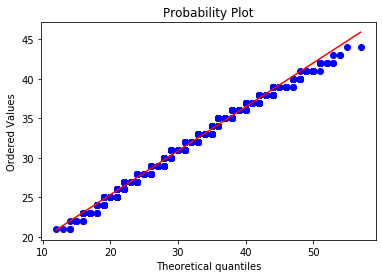

1048576
---- Normalized data ----
Mean: 31.99957275390625; expected: 32; difference: 0.00042724609375
Std: 10.769042786210775; expected: 32; difference: 21.230957213789225
difference between std and mean :21.230529967695475
MWU: MannwhitneyuResult(statistic=793.0, pvalue=0.004110147881360831)
Levene: LeveneResult(statistic=0.04383066625910103, pvalue=0.8346220284642942)


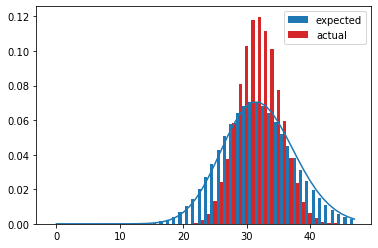

---- Sample data ----
MWU: MannwhitneyuResult(statistic=740.5, pvalue=0.00021311032370707408)
Levene: LeveneResult(statistic=9.311559882309536e-08, pvalue=0.999757173397767)


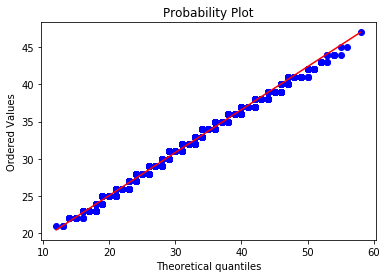

2097152
---- Normalized data ----
Mean: 31.999771118164062; expected: 32; difference: 0.0002288818359375
Std: 10.025833077495918; expected: 32; difference: 21.974166922504082
difference between std and mean :21.973938040668145
MWU: MannwhitneyuResult(statistic=737.0, pvalue=0.005905273204572814)
Levene: LeveneResult(statistic=0.05805009564866976, pvalue=0.8101528439085759)


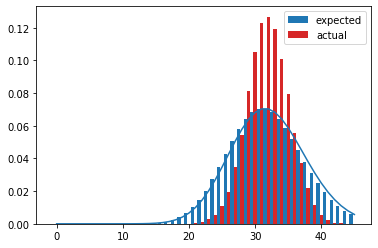

---- Sample data ----
MWU: MannwhitneyuResult(statistic=685.5, pvalue=0.0003553654995925519)
Levene: LeveneResult(statistic=9.260283905747633e-08, pvalue=0.9997578715351849)


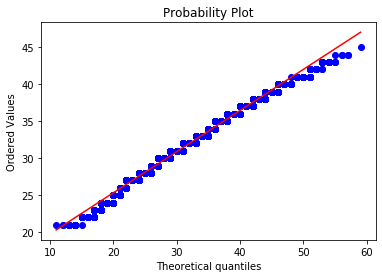

4194304
---- Normalized data ----
Mean: 31.9998779296875; expected: 32; difference: 0.0001220703125
Std: 8.780822739005089; expected: 32; difference: 23.21917726099491
difference between std and mean :23.21905519068241
MWU: MannwhitneyuResult(statistic=671.0, pvalue=0.0027851472716743397)
Levene: LeveneResult(statistic=0.06047219236416985, pvalue=0.8063238217443638)


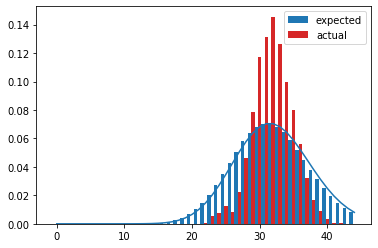

---- Sample data ----
MWU: MannwhitneyuResult(statistic=690.0, pvalue=0.0010851669854849047)
Levene: LeveneResult(statistic=1.5737586854138658e-10, pvalue=0.999990019011428)


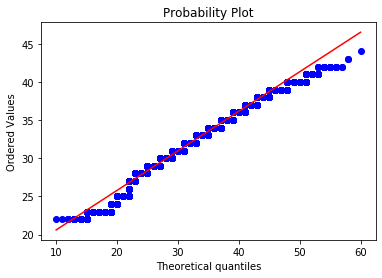

8388608
---- Normalized data ----
Mean: 31.999935150146484; expected: 32; difference: 6.4849853515625e-05
Std: 10.366687770452698; expected: 32; difference: 21.6333122295473
difference between std and mean :21.633247379693785
MWU: MannwhitneyuResult(statistic=826.0, pvalue=0.017496136559909302)
Levene: LeveneResult(statistic=0.04882857962391604, pvalue=0.825603993131496)


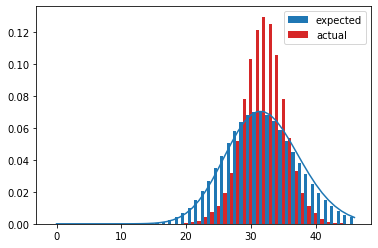

---- Sample data ----
MWU: MannwhitneyuResult(statistic=630.0, pvalue=3.0597214477918693e-05)
Levene: LeveneResult(statistic=2.9374560775984856e-06, pvalue=0.9986362165617643)


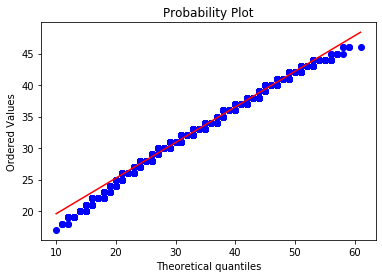

16777216
---- Normalized data ----
Mean: 31.99996566772461; expected: 32; difference: 3.4332275390625e-05
Std: 12.015731810344732; expected: 32; difference: 19.984268189655268
difference between std and mean :19.984233857379877
MWU: MannwhitneyuResult(statistic=883.0, pvalue=0.024301665891425683)
Levene: LeveneResult(statistic=0.04577382404473851, pvalue=0.8310508651501454)


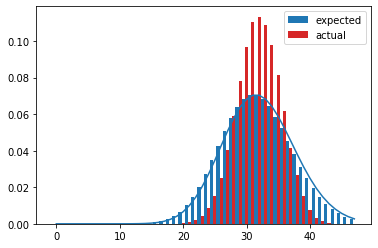

---- Sample data ----
MWU: MannwhitneyuResult(statistic=637.0, pvalue=1.6031117324671482e-05)
Levene: LeveneResult(statistic=1.1154662230611049e-06, pvalue=0.9991595474979151)


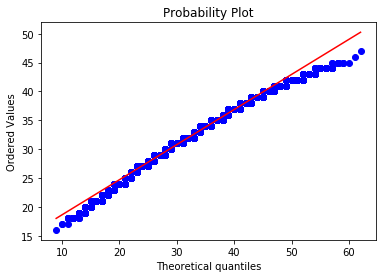

33554432
---- Normalized data ----
Mean: 31.99998188018799; expected: 32; difference: 1.811981201171875e-05
Std: 12.509766578345989; expected: 32; difference: 19.49023342165401
difference between std and mean :19.490215301842
MWU: MannwhitneyuResult(statistic=925.0, pvalue=0.04827981700929291)
Levene: LeveneResult(statistic=0.04339899183812873, pvalue=0.8354265288799188)


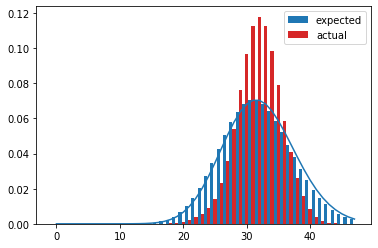

---- Sample data ----
MWU: MannwhitneyuResult(statistic=561.5, pvalue=1.2146162539363536e-06)
Levene: LeveneResult(statistic=1.4395592420425233e-05, pvalue=0.9969807521716243)


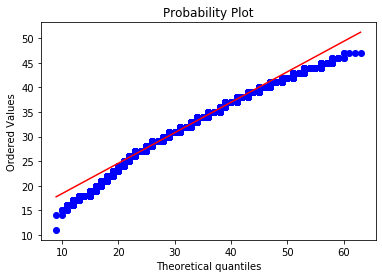

In [58]:
perform_test(seq='levin2',lamb=32)

### Stoneham 2,3 with lambda = 1 from N=2ˆ10 up to 2ˆ26

1024
---- Normalized data ----
Mean: 0.9912109375; expected: 1; difference: 0.0087890625
Std: 1.403243064880371; expected: 1; difference: 0.4032430648803711
difference between std and mean :0.4120321273803711
MWU: MannwhitneyuResult(statistic=12.0, pvalue=0.5)
Levene: LeveneResult(statistic=0.06015640774557049, pvalue=0.8124235166465675)


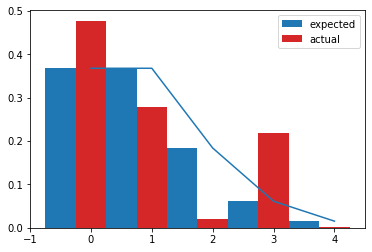

---- Sample data ----
MWU: MannwhitneyuResult(statistic=13.5, pvalue=0.2845440962426829)
Levene: LeveneResult(statistic=0.052096414794206417, pvalue=0.8240542558700078)


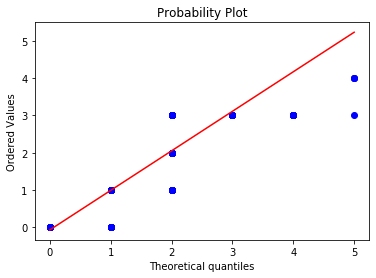

2048
---- Normalized data ----
Mean: 0.9951171875; expected: 1; difference: 0.0048828125
Std: 1.8232183456420898; expected: 1; difference: 0.8232183456420898
difference between std and mean :0.8281011581420898
MWU: MannwhitneyuResult(statistic=10.0, pvalue=0.33758680746356223)
Levene: LeveneResult(statistic=0.20457552448874486, pvalue=0.6630652221010223)


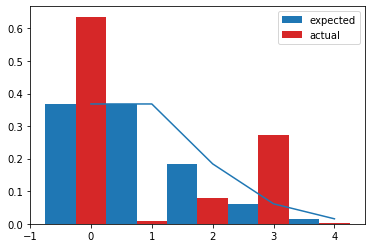

---- Sample data ----
MWU: MannwhitneyuResult(statistic=16.0, pvalue=0.43549559739873167)
Levene: LeveneResult(statistic=0.27190828058732713, pvalue=0.6134065310387375)


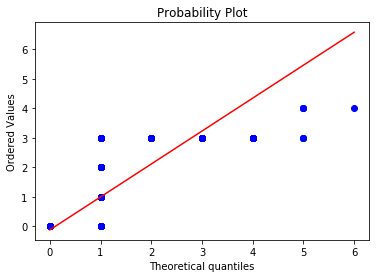

4096
---- Normalized data ----
Mean: 0.997314453125; expected: 1; difference: 0.002685546875
Std: 1.2697681784629822; expected: 1; difference: 0.2697681784629822
difference between std and mean :0.2724537253379822
MWU: MannwhitneyuResult(statistic=12.0, pvalue=0.5)
Levene: LeveneResult(statistic=0.036053240061822804, pvalue=0.8541349471430955)


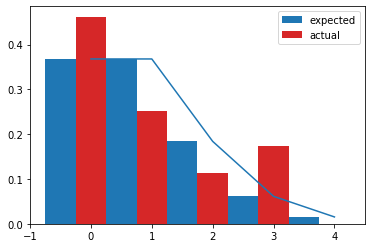

---- Sample data ----
MWU: MannwhitneyuResult(statistic=15.0, pvalue=0.37266653366540137)
Levene: LeveneResult(statistic=0.011603693500936268, pvalue=0.9163480784663971)


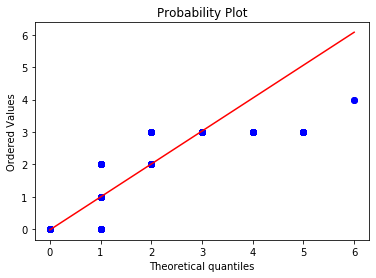

8192
---- Normalized data ----
Mean: 0.99853515625; expected: 1; difference: 0.00146484375
Std: 1.591306447982788; expected: 1; difference: 0.5913064479827881
difference between std and mean :0.5927712917327881
MWU: MannwhitneyuResult(statistic=11.0, pvalue=0.417017614895496)
Levene: LeveneResult(statistic=0.15448641665796564, pvalue=0.7045505623274593)


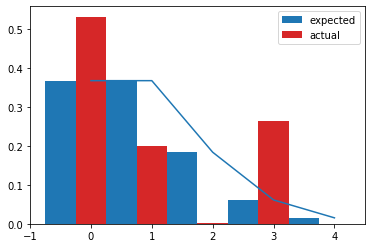

---- Sample data ----
MWU: MannwhitneyuResult(statistic=16.5, pvalue=0.3300556468021374)
Levene: LeveneResult(statistic=0.25207492674727805, pvalue=0.6255156691182484)


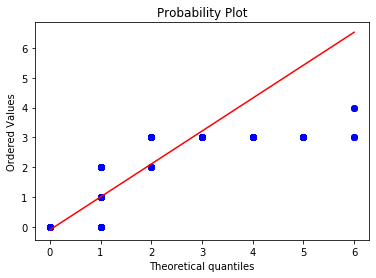

16384
---- Normalized data ----
Mean: 0.99920654296875; expected: 1; difference: 0.00079345703125
Std: 1.5892938040196896; expected: 1; difference: 0.5892938040196896
difference between std and mean :0.5900872610509396
MWU: MannwhitneyuResult(statistic=11.0, pvalue=0.417017614895496)
Levene: LeveneResult(statistic=0.11662251196168326, pvalue=0.7415237691224916)


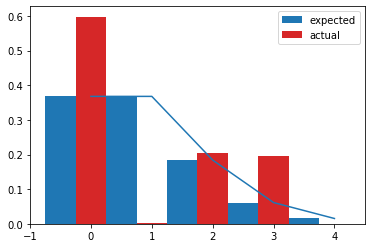

---- Sample data ----
MWU: MannwhitneyuResult(statistic=17.5, pvalue=0.38469495689560607)
Levene: LeveneResult(statistic=0.22277303588443556, pvalue=0.6461594489969658)


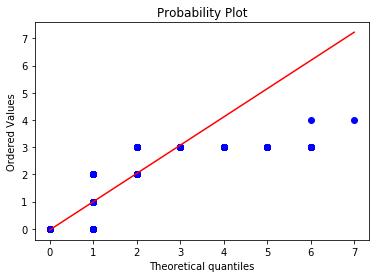

32768
---- Normalized data ----
Mean: 0.99957275390625; expected: 1; difference: 0.00042724609375
Std: 1.1984251104295254; expected: 1; difference: 0.19842511042952538
difference between std and mean :0.19885235652327538
MWU: MannwhitneyuResult(statistic=12.0, pvalue=0.5)
Levene: LeveneResult(statistic=0.2748745387764234, pvalue=0.6142924547143068)


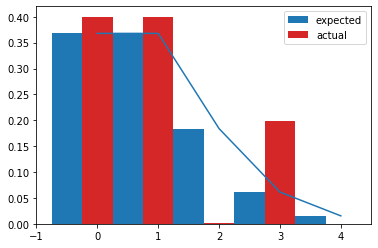

---- Sample data ----
MWU: MannwhitneyuResult(statistic=15.0, pvalue=0.2550337637787672)
Levene: LeveneResult(statistic=0.32969798433742514, pvalue=0.5773897513790959)


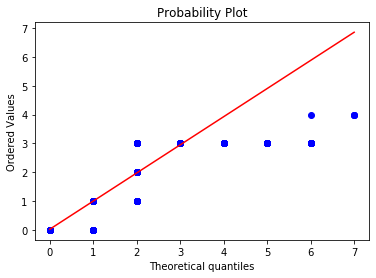

65536
---- Normalized data ----
Mean: 0.9997711181640625; expected: 1; difference: 0.0002288818359375
Std: 1.8002776575740427; expected: 1; difference: 0.8002776575740427
difference between std and mean :0.8005065394099802
MWU: MannwhitneyuResult(statistic=10.0, pvalue=0.33758680746356223)
Levene: LeveneResult(statistic=0.26572334654865293, pvalue=0.6201539340634721)


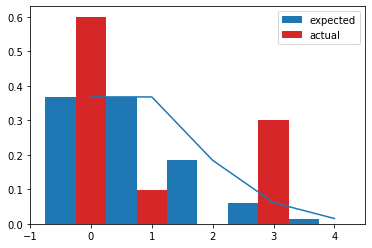

---- Sample data ----
MWU: MannwhitneyuResult(statistic=19.0, pvalue=0.47082646508051795)
Levene: LeveneResult(statistic=0.43894646984001073, pvalue=0.5212711697858585)


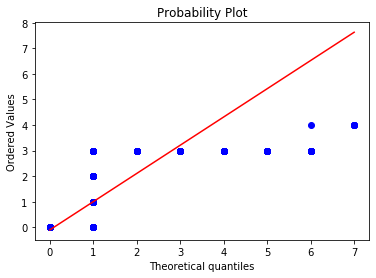

131072
---- Normalized data ----
Mean: 0.9998779296875; expected: 1; difference: 0.0001220703125
Std: 1.3980560153722763; expected: 1; difference: 0.3980560153722763
difference between std and mean :0.3981780856847763
MWU: MannwhitneyuResult(statistic=7.0, pvalue=0.44227471942648117)
Levene: LeveneResult(statistic=0.11913828700272676, pvalue=0.7417494897889526)


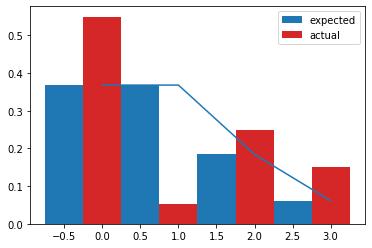

---- Sample data ----
MWU: MannwhitneyuResult(statistic=9.0, pvalue=0.09483119988207284)
Levene: LeveneResult(statistic=0.21588218616791058, pvalue=0.6512568668589935)


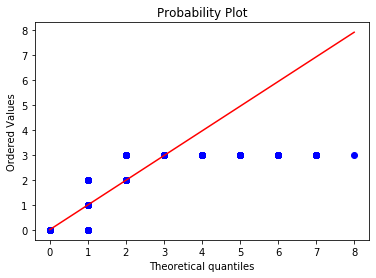

262144
---- Normalized data ----
Mean: 0.9999351501464844; expected: 1; difference: 6.4849853515625e-05
Std: 1.3510246234800434; expected: 1; difference: 0.3510246234800434
difference between std and mean :0.351089473333559
MWU: MannwhitneyuResult(statistic=11.0, pvalue=0.417017614895496)
Levene: LeveneResult(statistic=0.16061020412034407, pvalue=0.6990854896817265)


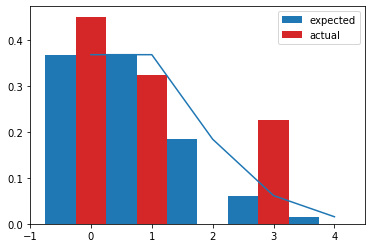

---- Sample data ----
MWU: MannwhitneyuResult(statistic=19.0, pvalue=0.2502797489090697)
Levene: LeveneResult(statistic=0.5705837817976013, pvalue=0.4634940036819789)


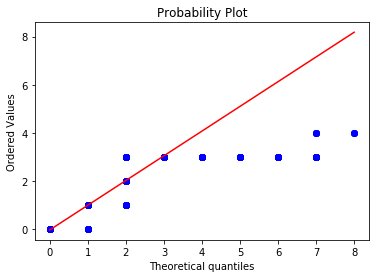

524288
---- Normalized data ----
Mean: 0.9999656677246094; expected: 1; difference: 3.4332275390625e-05
Std: 1.9722709643974667; expected: 1; difference: 0.9722709643974667
difference between std and mean :0.9723052966728574
MWU: MannwhitneyuResult(statistic=8.0, pvalue=0.2009826791783677)
Levene: LeveneResult(statistic=0.24640676668165262, pvalue=0.6329668569375546)


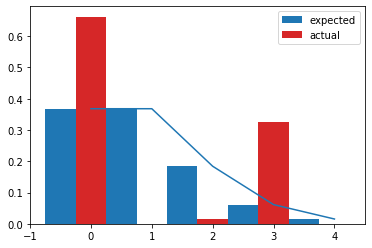

---- Sample data ----
MWU: MannwhitneyuResult(statistic=22.0, pvalue=0.5)
Levene: LeveneResult(statistic=0.6091634878851138, pvalue=0.45022508965869634)


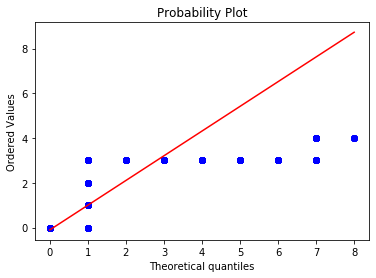

1048576
---- Normalized data ----
Mean: 0.9999818801879883; expected: 1; difference: 1.811981201171875e-05
Std: 1.3240308758313404; expected: 1; difference: 0.3240308758313404
difference between std and mean :0.3240489956433521
MWU: MannwhitneyuResult(statistic=11.0, pvalue=0.417017614895496)
Levene: LeveneResult(statistic=0.14783576091490452, pvalue=0.7106314129085844)


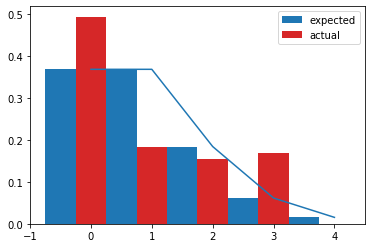

---- Sample data ----
MWU: MannwhitneyuResult(statistic=18.0, pvalue=0.2129915582724594)
Levene: LeveneResult(statistic=0.0036929346054592315, pvalue=0.9524670829151434)


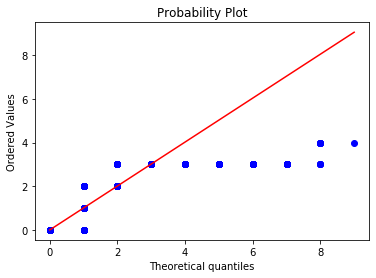

2097152
---- Normalized data ----
Mean: 0.9999904632568359; expected: 1; difference: 9.5367431640625e-06
Std: 1.5203695296331716; expected: 1; difference: 0.5203695296331716
difference between std and mean :0.5203790663763357
MWU: MannwhitneyuResult(statistic=11.0, pvalue=0.417017614895496)
Levene: LeveneResult(statistic=0.08577026449168089, pvalue=0.7770775100924856)


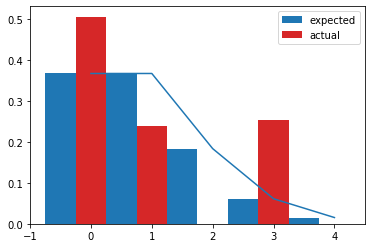

---- Sample data ----
MWU: MannwhitneyuResult(statistic=21.0, pvalue=0.3340850805532036)
Levene: LeveneResult(statistic=0.45748807334028246, pvalue=0.5106556206483114)


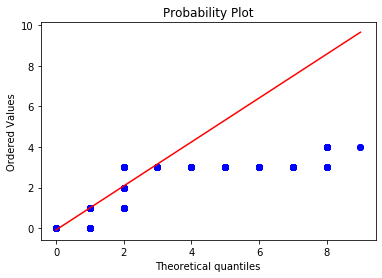

4194304
---- Normalized data ----
Mean: 0.9999949932098389; expected: 1; difference: 5.0067901611328125e-06
Std: 1.719228982900347; expected: 1; difference: 0.7192289829003471
difference between std and mean :0.7192339896905082
MWU: MannwhitneyuResult(statistic=10.0, pvalue=0.33758680746356223)
Levene: LeveneResult(statistic=0.2065291700830465, pvalue=0.6615786745018093)


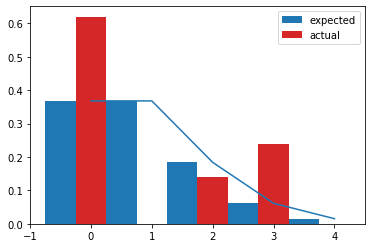

---- Sample data ----
MWU: MannwhitneyuResult(statistic=22.0, pvalue=0.3797314326899668)
Levene: LeveneResult(statistic=0.7067463769063241, pvalue=0.41572138932817887)


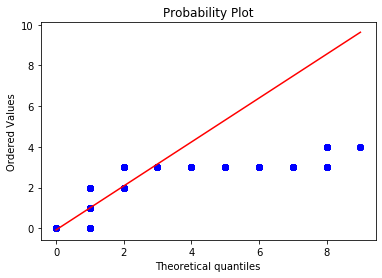

8388608
---- Normalized data ----
Mean: 0.9999973773956299; expected: 1; difference: 2.6226043701171875e-06
Std: 1.239729642861164; expected: 1; difference: 0.23972964286116394
difference between std and mean :0.23973226546553406
MWU: MannwhitneyuResult(statistic=12.0, pvalue=0.5)
Levene: LeveneResult(statistic=0.03753693554172913, pvalue=0.8512048802958511)


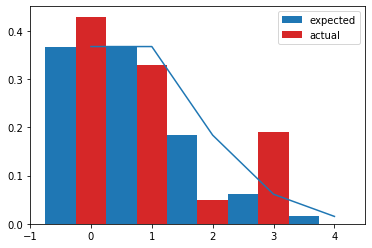

---- Sample data ----
MWU: MannwhitneyuResult(statistic=18.0, pvalue=0.2129915582724594)
Levene: LeveneResult(statistic=0.3546135309726974, pvalue=0.56173727854137)


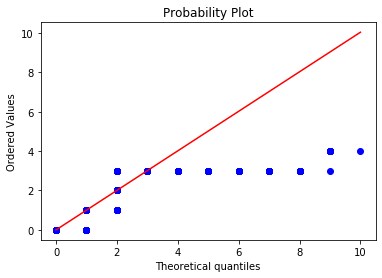

16777216
---- Normalized data ----
Mean: 0.9999986290931702; expected: 1; difference: 1.3709068298339844e-06
Std: 1.7105054259281438; expected: 1; difference: 0.7105054259281438
difference between std and mean :0.7105067968349736
MWU: MannwhitneyuResult(statistic=10.0, pvalue=0.33758680746356223)
Levene: LeveneResult(statistic=0.25527478377967394, pvalue=0.6270077096847233)


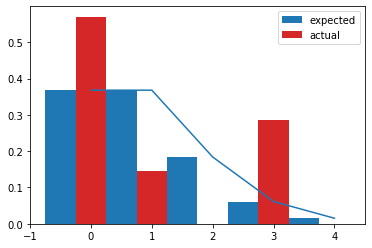

---- Sample data ----
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.3252193057063988)
Levene: LeveneResult(statistic=1.0110750174777994, pvalue=0.33170927616525364)


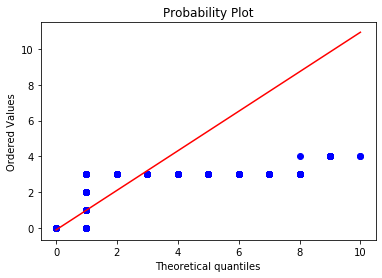

33554432
---- Normalized data ----
Mean: 0.9999992847442627; expected: 1; difference: 7.152557373046875e-07
Std: 1.4342039823526989; expected: 1; difference: 0.43420398235269886
difference between std and mean :0.43420469760843616
MWU: MannwhitneyuResult(statistic=10.0, pvalue=0.33758680746356223)
Levene: LeveneResult(statistic=0.2526722541892321, pvalue=0.6287427013154272)


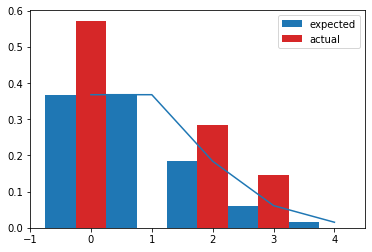

---- Sample data ----
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.36697920668909667)
Levene: LeveneResult(statistic=1.0068926409937038, pvalue=0.33267748369883743)


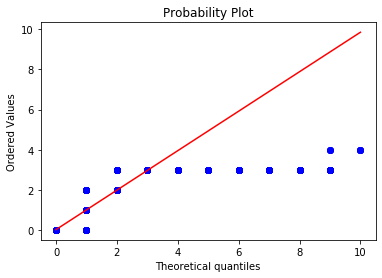

In [191]:
perform_test(seq='stoneham',lamb=1)

### Stoneham 2,3 with lambda = 4 from N=2ˆ10 up to 2ˆ26

1024
---- Normalized data ----
Mean: 3.97265625; expected: 4; difference: 0.02734375
Std: 1.1828460693359375; expected: 4; difference: 2.8171539306640625
difference between std and mean :2.7898101806640625
MWU: MannwhitneyuResult(statistic=22.0, pvalue=0.3989313542143315)
Levene: LeveneResult(statistic=1.5007605417369894, pvalue=0.24405729211831603)


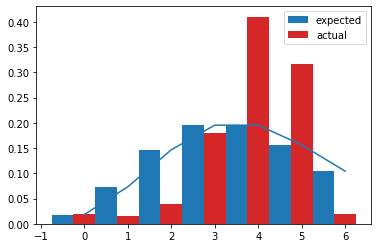

---- Sample data ----
MWU: MannwhitneyuResult(statistic=20.0, pvalue=0.30444315251160114)
Levene: LeveneResult(statistic=0.007692633720437415, pvalue=0.9315556801876242)


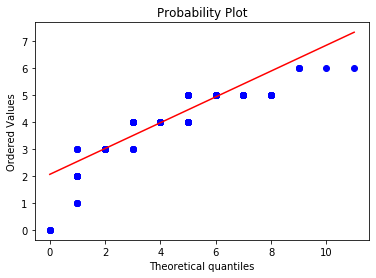

2048
---- Normalized data ----
Mean: 3.984375; expected: 4; difference: 0.015625
Std: 2.265380859375; expected: 4; difference: 1.734619140625
difference between std and mean :1.718994140625
MWU: MannwhitneyuResult(statistic=25.0, pvalue=0.24725949611378562)
Levene: LeveneResult(statistic=2.2211733924807704, pvalue=0.15831256273733688)


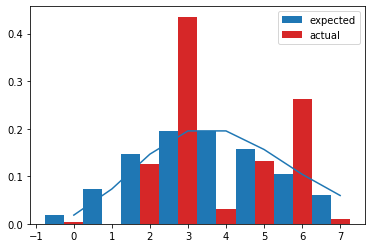

---- Sample data ----
MWU: MannwhitneyuResult(statistic=29.0, pvalue=0.39614883124810624)
Levene: LeveneResult(statistic=0.013765425905488111, pvalue=0.9082681815330587)


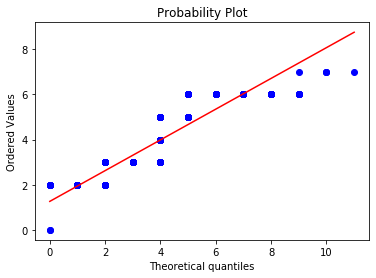

4096
---- Normalized data ----
Mean: 3.9912109375; expected: 4; difference: 0.0087890625
Std: 1.356368064880371; expected: 4; difference: 2.643631935119629
difference between std and mean :2.634842872619629
MWU: MannwhitneyuResult(statistic=27.0, pvalue=0.3181271340831978)
Levene: LeveneResult(statistic=2.0180753453034446, pvalue=0.1773236876078997)


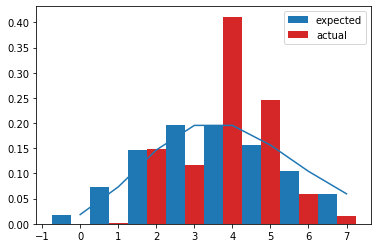

---- Sample data ----
MWU: MannwhitneyuResult(statistic=28.0, pvalue=0.35619080210493304)
Levene: LeveneResult(statistic=0.06344586019842208, pvalue=0.8047902741466111)


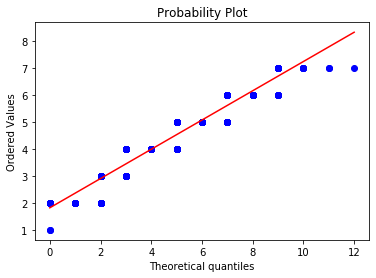

8192
---- Normalized data ----
Mean: 3.9951171875; expected: 4; difference: 0.0048828125
Std: 1.1171636581420898; expected: 4; difference: 2.88283634185791
difference between std and mean :2.87795352935791
MWU: MannwhitneyuResult(statistic=27.0, pvalue=0.1253768099647634)
Levene: LeveneResult(statistic=0.8926029023146931, pvalue=0.3588226934392911)


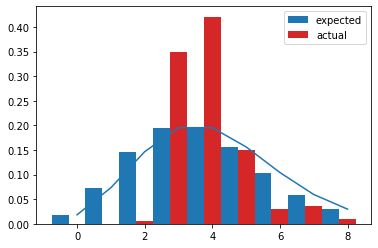

---- Sample data ----
MWU: MannwhitneyuResult(statistic=37.5, pvalue=0.41241885541559825)
Levene: LeveneResult(statistic=0.00360743786881891, pvalue=0.9528501090674187)


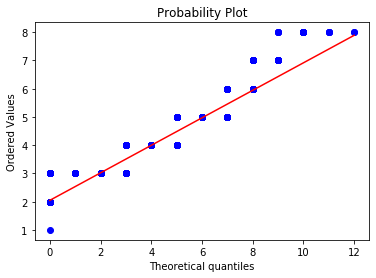

16384
---- Normalized data ----
Mean: 3.997314453125; expected: 4; difference: 0.002685546875
Std: 1.8288502097129822; expected: 4; difference: 2.171149790287018
difference between std and mean :2.168464243412018
MWU: MannwhitneyuResult(statistic=30.0, pvalue=0.43732150741769493)
Levene: LeveneResult(statistic=1.9410517593500045, pvalue=0.18528155315016212)


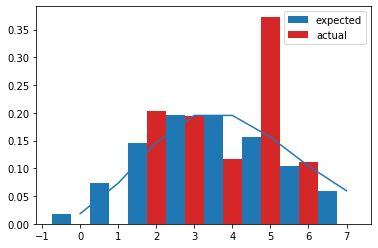

---- Sample data ----
MWU: MannwhitneyuResult(statistic=29.5, pvalue=0.41669663997287104)
Levene: LeveneResult(statistic=0.17283042681436975, pvalue=0.6839104528117217)


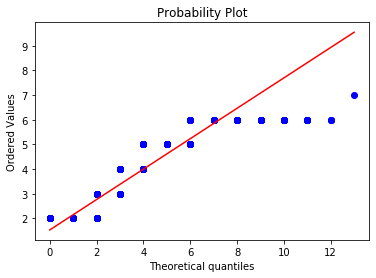

32768
---- Normalized data ----
Mean: 3.99853515625; expected: 4; difference: 0.00146484375
Std: 1.209714651107788; expected: 4; difference: 2.790285348892212
difference between std and mean :2.788820505142212
MWU: MannwhitneyuResult(statistic=21.0, pvalue=0.3505826637090777)
Levene: LeveneResult(statistic=1.602340243734755, pvalue=0.2295958420406551)


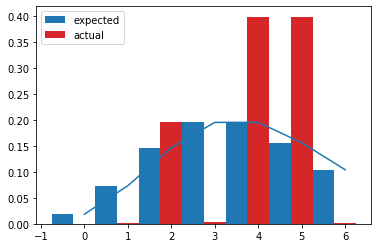

---- Sample data ----
MWU: MannwhitneyuResult(statistic=27.0, pvalue=0.4769285765308018)
Levene: LeveneResult(statistic=0.06436040827372594, pvalue=0.8037004187566993)


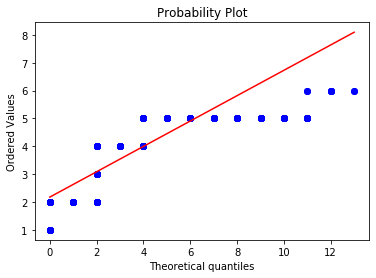

65536
---- Normalized data ----
Mean: 3.99920654296875; expected: 4; difference: 0.00079345703125
Std: 1.7024529837071896; expected: 4; difference: 2.2975470162928104
difference between std and mean :2.2967535592615604
MWU: MannwhitneyuResult(statistic=32.0, pvalue=0.09277287538948842)
Levene: LeveneResult(statistic=0.6106253119457639, pvalue=0.4447096706300885)


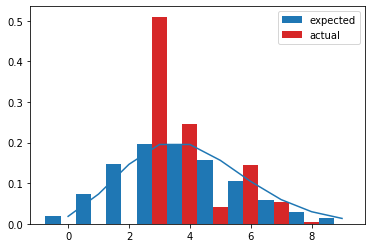

---- Sample data ----
MWU: MannwhitneyuResult(statistic=49.0, pvalue=0.48491364651063584)
Levene: LeveneResult(statistic=2.468676261830551e-05, pvalue=0.9960903176882264)


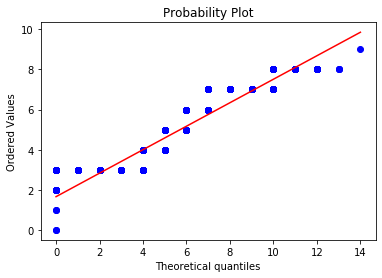

131072
---- Normalized data ----
Mean: 3.99957275390625; expected: 4; difference: 0.00042724609375
Std: 1.2562254033982754; expected: 4; difference: 2.7437745966017246
difference between std and mean :2.7433473505079746
MWU: MannwhitneyuResult(statistic=21.0, pvalue=0.3505826637090777)
Levene: LeveneResult(statistic=2.56878523890868, pvalue=0.13497179518549868)


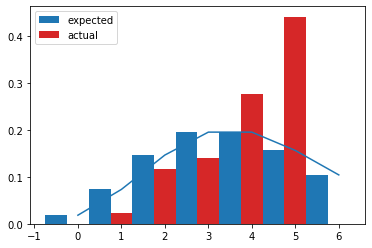

---- Sample data ----
MWU: MannwhitneyuResult(statistic=27.0, pvalue=0.3358862645935033)
Levene: LeveneResult(statistic=0.028090584830381814, pvalue=0.8692929778945699)


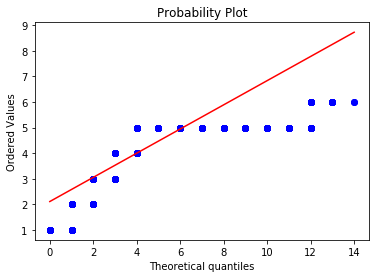

262144
---- Normalized data ----
Mean: 3.9997711181640625; expected: 4; difference: 0.0002288818359375
Std: 1.1616363001521677; expected: 4; difference: 2.8383636998478323
difference between std and mean :2.838134818011895
MWU: MannwhitneyuResult(statistic=19.0, pvalue=0.2612229136008081)
Levene: LeveneResult(statistic=1.4014057212211237, pvalue=0.25940850390609244)


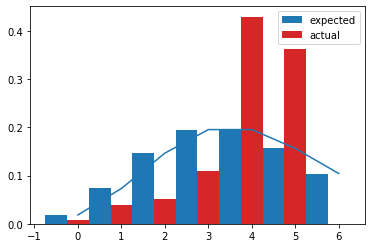

---- Sample data ----
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.34272174133876104)
Levene: LeveneResult(statistic=0.0003311774916180954, pvalue=0.9857570150560597)


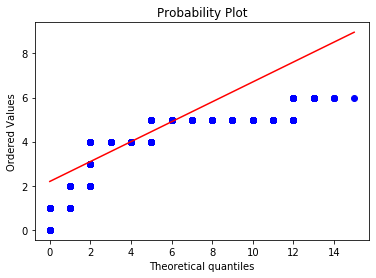

524288
---- Normalized data ----
Mean: 3.9998779296875; expected: 4; difference: 0.0001220703125
Std: 2.048797592520714; expected: 4; difference: 1.9512024074792862
difference between std and mean :1.9510803371667862
MWU: MannwhitneyuResult(statistic=18.0, pvalue=0.07782230387630909)
Levene: LeveneResult(statistic=0.7868646213934778, pvalue=0.39003429114828075)


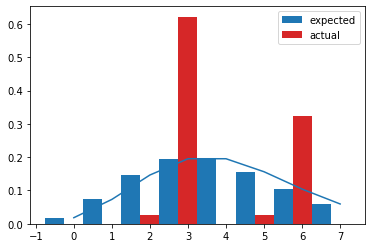

---- Sample data ----
MWU: MannwhitneyuResult(statistic=32.0, pvalue=0.36782622973320983)
Levene: LeveneResult(statistic=0.03210478460244592, pvalue=0.8601957020353133)


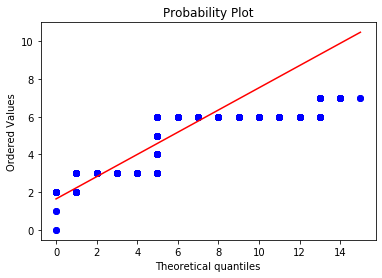

1048576
---- Normalized data ----
Mean: 3.9999351501464844; expected: 4; difference: 6.4849853515625e-05
Std: 0.9535789447691059; expected: 4; difference: 3.046421055230894
difference between std and mean :3.0463562053773785
MWU: MannwhitneyuResult(statistic=29.0, pvalue=0.16544377854825604)
Levene: LeveneResult(statistic=1.0499850609538666, pvalue=0.3207541860911559)


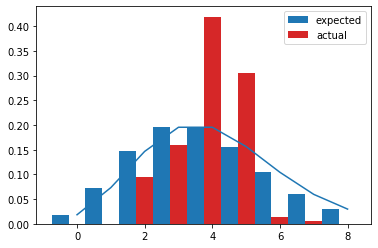

---- Sample data ----
MWU: MannwhitneyuResult(statistic=36.0, pvalue=0.36189765707468813)
Levene: LeveneResult(statistic=1.1849232115230261e-05, pvalue=0.9972960242037692)


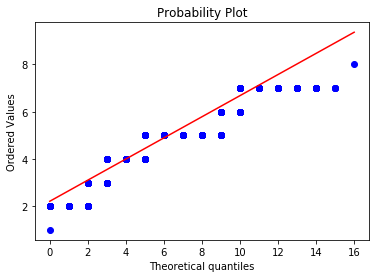

2097152
---- Normalized data ----
Mean: 3.9999656677246094; expected: 4; difference: 3.4332275390625e-05
Std: 0.6322936999931699; expected: 4; difference: 3.36770630000683
difference between std and mean :3.3676719677314395
MWU: MannwhitneyuResult(statistic=30.0, pvalue=0.07008328621623115)
Levene: LeveneResult(statistic=0.5184844166228033, pvalue=0.4807353918437257)


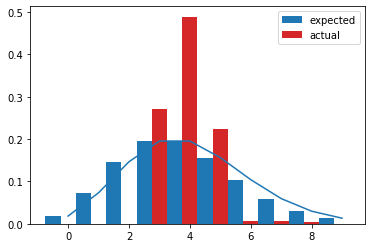

---- Sample data ----
MWU: MannwhitneyuResult(statistic=46.5, pvalue=0.4101317169549247)
Levene: LeveneResult(statistic=1.3312565462896952e-06, pvalue=0.9990920915430623)


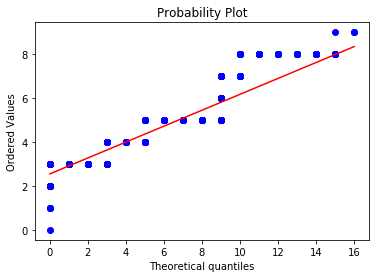

4194304
---- Normalized data ----
Mean: 3.9999818801879883; expected: 4; difference: 1.811981201171875e-05
Std: 2.045855521827434; expected: 4; difference: 1.9541444781725659
difference between std and mean :1.9541263583605541
MWU: MannwhitneyuResult(statistic=29.0, pvalue=0.3962986144627732)
Levene: LeveneResult(statistic=8.678966226942993, pvalue=0.010629533168763533)


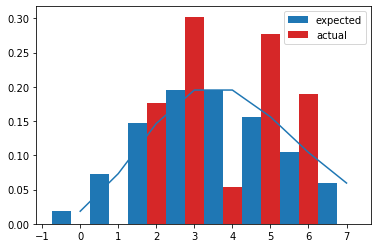

---- Sample data ----
MWU: MannwhitneyuResult(statistic=41.0, pvalue=0.4178713470492127)
Levene: LeveneResult(statistic=0.1551708268492277, pvalue=0.6985392624174609)


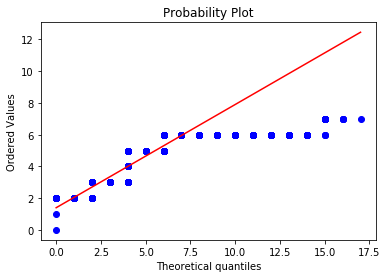

8388608
---- Normalized data ----
Mean: 3.999990463256836; expected: 4; difference: 9.5367431640625e-06
Std: 1.3505029677435232; expected: 4; difference: 2.649497032256477
difference between std and mean :2.6494874955133128
MWU: MannwhitneyuResult(statistic=25.0, pvalue=0.24725949611378562)
Levene: LeveneResult(statistic=1.5397260918440985, pvalue=0.23505012479531365)


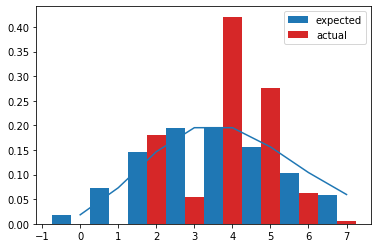

---- Sample data ----
MWU: MannwhitneyuResult(statistic=36.0, pvalue=0.3779067115433005)
Levene: LeveneResult(statistic=0.02819790586104649, pvalue=0.868748611901039)


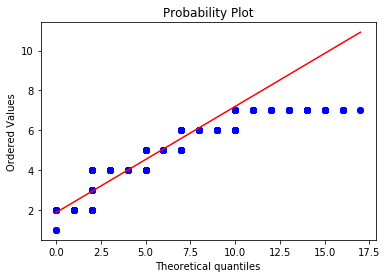

16777216
---- Normalized data ----
Mean: 3.999994993209839; expected: 4; difference: 5.0067901611328125e-06
Std: 1.4700939655053278; expected: 4; difference: 2.5299060344946724
difference between std and mean :2.5299010277045113
MWU: MannwhitneyuResult(statistic=28.0, pvalue=0.1445329346986155)
Levene: LeveneResult(statistic=1.001075572545343, pvalue=0.3319427882729701)


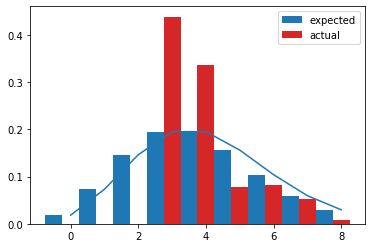

---- Sample data ----
MWU: MannwhitneyuResult(statistic=37.0, pvalue=0.39554075646039083)
Levene: LeveneResult(statistic=0.006507209206395526, pvalue=0.9367069770680342)


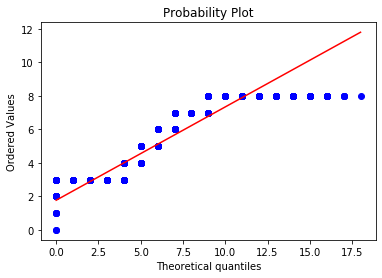

33554432
---- Normalized data ----
Mean: 3.99999737739563; expected: 4; difference: 2.6226043701171875e-06
Std: 1.3522167205741766; expected: 4; difference: 2.6477832794258234
difference between std and mean :2.6477806568214532
MWU: MannwhitneyuResult(statistic=21.0, pvalue=0.3505826637090777)
Levene: LeveneResult(statistic=2.729744229935417, pvalue=0.12440032028377061)


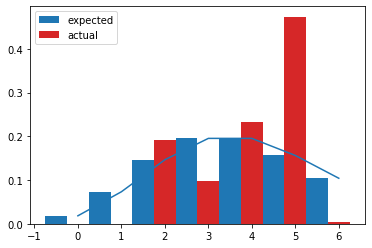

---- Sample data ----
MWU: MannwhitneyuResult(statistic=34.0, pvalue=0.3585763587335273)
Levene: LeveneResult(statistic=0.3237383141901835, pvalue=0.5772701599812036)


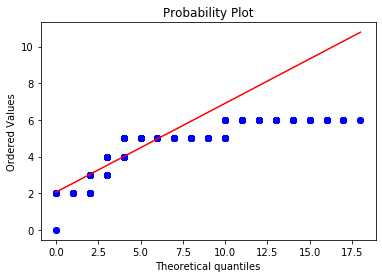

In [192]:
perform_test(seq='stoneham',lamb=4)

### Stoneham 2,3 with lambda = 32 from N=2ˆ10 up to 2ˆ26

1024
---- Normalized data ----
Mean: 31.875; expected: 32; difference: 0.125
Std: 7.671875; expected: 32; difference: 24.328125
difference between std and mean :24.203125
MWU: MannwhitneyuResult(statistic=397.0, pvalue=0.00010864567214792445)
Levene: LeveneResult(statistic=0.14001564460494179, pvalue=0.7093074189290756)


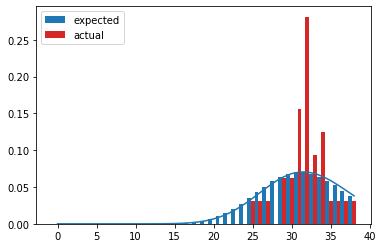

---- Sample data ----
MWU: MannwhitneyuResult(statistic=623.5, pvalue=0.03220017448297134)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


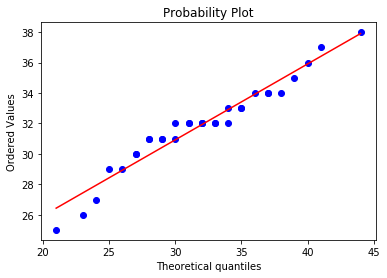

2048
---- Normalized data ----
Mean: 31.921875; expected: 32; difference: 0.078125
Std: 3.634521484375; expected: 32; difference: 28.365478515625
difference between std and mean :28.287353515625
MWU: MannwhitneyuResult(statistic=301.0, pvalue=1.033944492931008e-05)
Levene: LeveneResult(statistic=0.33131967757071207, pvalue=0.566677753892229)


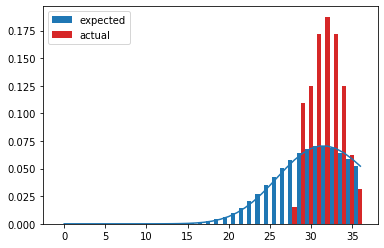

---- Sample data ----
MWU: MannwhitneyuResult(statistic=601.0, pvalue=0.08804239541273162)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


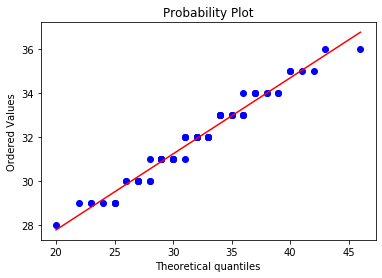

4096
---- Normalized data ----
Mean: 31.953125; expected: 32; difference: 0.046875
Std: 3.950927734375; expected: 32; difference: 28.049072265625
difference between std and mean :28.002197265625
MWU: MannwhitneyuResult(statistic=356.0, pvalue=5.11393285548913e-05)
Levene: LeveneResult(statistic=0.21773146484180794, pvalue=0.6421447351330943)


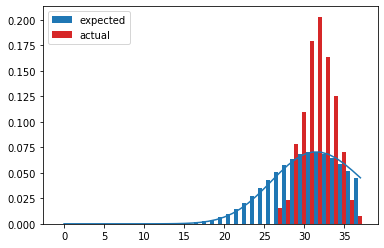

---- Sample data ----
MWU: MannwhitneyuResult(statistic=619.5, pvalue=0.06853028637724146)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


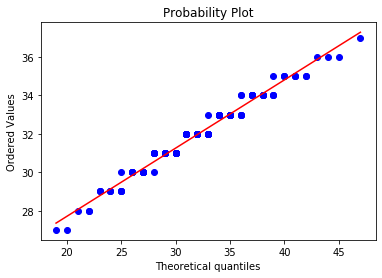

8192
---- Normalized data ----
Mean: 31.97265625; expected: 32; difference: 0.02734375
Std: 6.5578460693359375; expected: 32; difference: 25.442153930664062
difference between std and mean :25.414810180664062
MWU: MannwhitneyuResult(statistic=443.0, pvalue=0.00024074781483502782)
Levene: LeveneResult(statistic=0.11136173391162583, pvalue=0.7394945965367967)


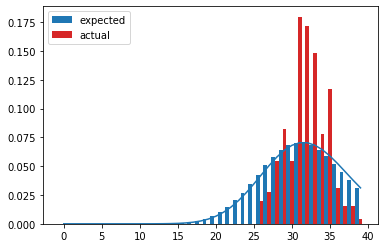

---- Sample data ----
MWU: MannwhitneyuResult(statistic=651.0, pvalue=0.030098718353611355)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


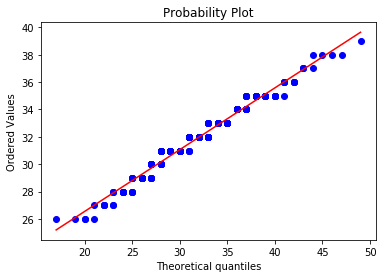

16384
---- Normalized data ----
Mean: 31.984375; expected: 32; difference: 0.015625
Std: 2.890380859375; expected: 32; difference: 29.109619140625
difference between std and mean :29.093994140625
MWU: MannwhitneyuResult(statistic=287.0, pvalue=5.097714579573488e-06)
Levene: LeveneResult(statistic=0.2797318717000555, pvalue=0.5985037757094653)


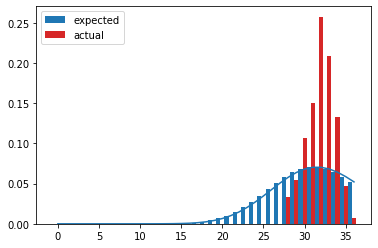

---- Sample data ----
MWU: MannwhitneyuResult(statistic=632.5, pvalue=0.21395464975468464)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


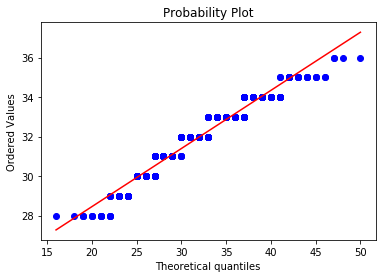

32768
---- Normalized data ----
Mean: 31.9912109375; expected: 32; difference: 0.0087890625
Std: 1.438399314880371; expected: 32; difference: 30.56160068511963
difference between std and mean :30.55281162261963
MWU: MannwhitneyuResult(statistic=188.0, pvalue=3.874873767277815e-08)
Levene: LeveneResult(statistic=0.21184748576404616, pvalue=0.6467497945451429)


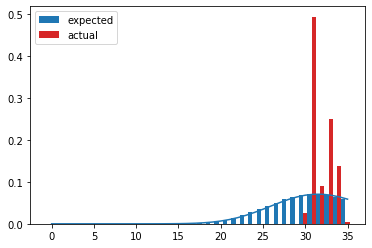

---- Sample data ----
MWU: MannwhitneyuResult(statistic=648.0, pvalue=0.4965391548007444)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


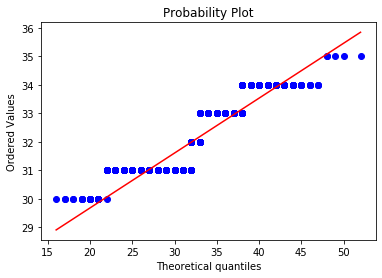

65536
---- Normalized data ----
Mean: 31.9951171875; expected: 32; difference: 0.0048828125
Std: 4.71579647064209; expected: 32; difference: 27.28420352935791
difference between std and mean :27.27932071685791
MWU: MannwhitneyuResult(statistic=437.0, pvalue=7.063463521768233e-05)
Levene: LeveneResult(statistic=0.07295133508828786, pvalue=0.7877826649705537)


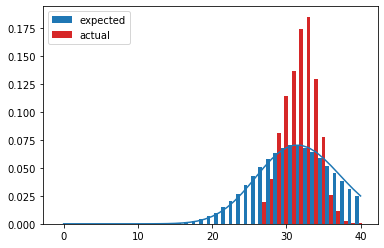

---- Sample data ----
MWU: MannwhitneyuResult(statistic=718.5, pvalue=0.07424907330168048)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


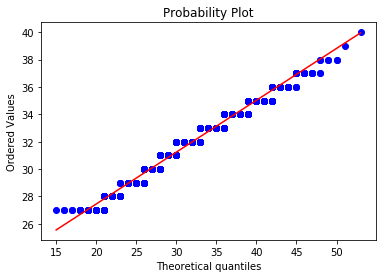

131072
---- Normalized data ----
Mean: 31.997314453125; expected: 32; difference: 0.002685546875
Std: 2.816643178462982; expected: 32; difference: 29.183356821537018
difference between std and mean :29.180671274662018
MWU: MannwhitneyuResult(statistic=300.0, pvalue=3.047723636723776e-05)
Levene: LeveneResult(statistic=0.43314438901711916, pvalue=0.5126087866878695)


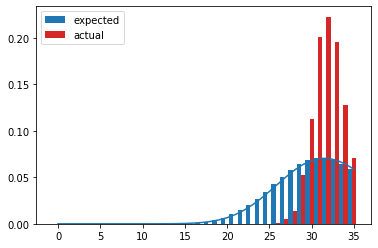

---- Sample data ----
MWU: MannwhitneyuResult(statistic=595.0, pvalue=0.21355073166471533)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


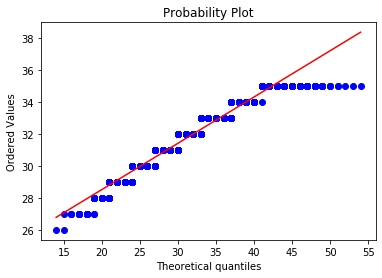

262144
---- Normalized data ----
Mean: 31.99853515625; expected: 32; difference: 0.00146484375
Std: 4.075925588607788; expected: 32; difference: 27.924074411392212
difference between std and mean :27.922609567642212
MWU: MannwhitneyuResult(statistic=408.0, pvalue=0.00017377266279118263)
Levene: LeveneResult(statistic=0.1427821656828216, pvalue=0.7065839732985114)


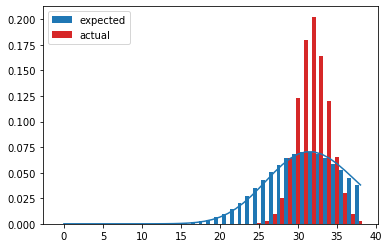

---- Sample data ----
MWU: MannwhitneyuResult(statistic=644.5, pvalue=0.07294183419547685)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


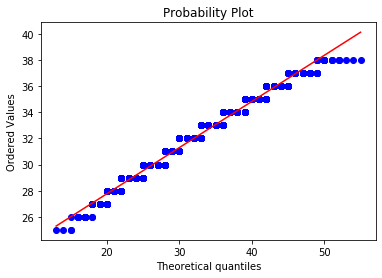

524288
---- Normalized data ----
Mean: 31.99920654296875; expected: 32; difference: 0.00079345703125
Std: 1.7551873587071896; expected: 32; difference: 30.24481264129281
difference between std and mean :30.24401918426156
MWU: MannwhitneyuResult(statistic=231.0, pvalue=2.1698826050566725e-06)
Levene: LeveneResult(statistic=0.30454558076475524, pvalue=0.5828558356453712)


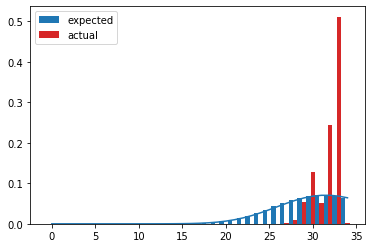

---- Sample data ----
MWU: MannwhitneyuResult(statistic=596.5, pvalue=0.40439014453578653)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


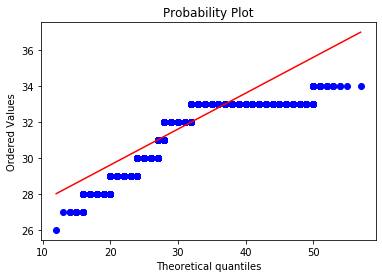

1048576
---- Normalized data ----
Mean: 31.99957275390625; expected: 32; difference: 0.00042724609375
Std: 3.9474485479295254; expected: 32; difference: 28.052551452070475
difference between std and mean :28.052124205976725
MWU: MannwhitneyuResult(statistic=435.0, pvalue=6.747415324316955e-05)
Levene: LeveneResult(statistic=0.06634558107573235, pvalue=0.7973952755304116)


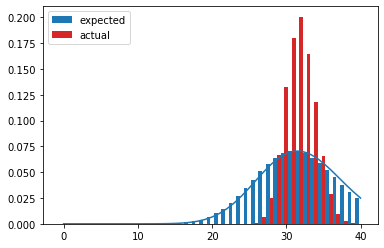

---- Sample data ----
MWU: MannwhitneyuResult(statistic=700.0, pvalue=0.050611120262684016)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


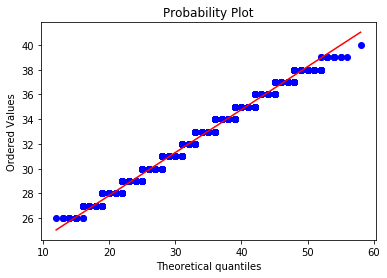

2097152
---- Normalized data ----
Mean: 31.999771118164062; expected: 32; difference: 0.0002288818359375
Std: 4.882797188824043; expected: 32; difference: 27.117202811175957
difference between std and mean :27.11697392934002
MWU: MannwhitneyuResult(statistic=510.0, pvalue=0.00038569153731779596)
Levene: LeveneResult(statistic=0.05560386206875341, pvalue=0.8141721688184357)


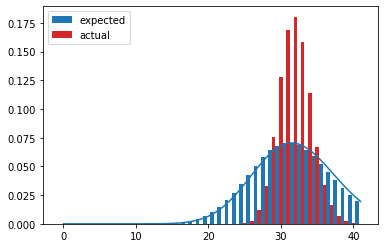

---- Sample data ----
MWU: MannwhitneyuResult(statistic=682.5, pvalue=0.01486907424435942)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


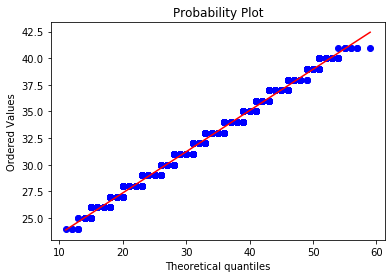

4194304
---- Normalized data ----
Mean: 31.9998779296875; expected: 32; difference: 0.0001220703125
Std: 2.9573821872472763; expected: 32; difference: 29.042617812752724
difference between std and mean :29.042495742440224
MWU: MannwhitneyuResult(statistic=370.0, pvalue=1.2511286699746366e-05)
Levene: LeveneResult(statistic=0.0783887644606488, pvalue=0.7802340654511767)


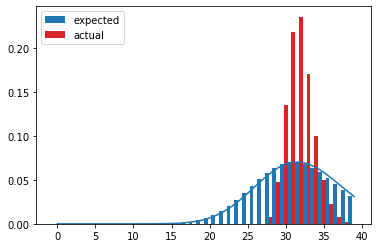

---- Sample data ----
MWU: MannwhitneyuResult(statistic=718.0, pvalue=0.1594279903506463)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


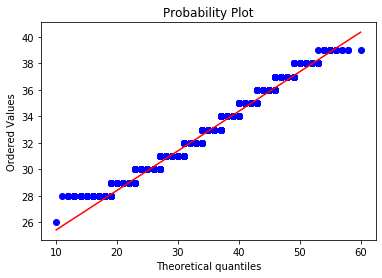

8388608
---- Normalized data ----
Mean: 31.999935150146484; expected: 32; difference: 6.4849853515625e-05
Std: 2.1476325946714496; expected: 32; difference: 29.85236740532855
difference between std and mean :29.852302555475035
MWU: MannwhitneyuResult(statistic=333.0, pvalue=7.568814242890133e-07)
Levene: LeveneResult(statistic=0.04527513583863672, pvalue=0.8320401787662484)


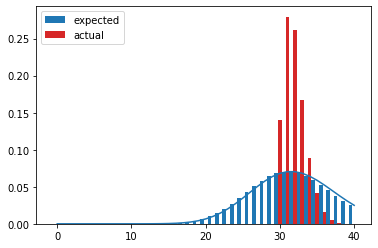

---- Sample data ----
MWU: MannwhitneyuResult(statistic=795.0, pvalue=0.29629415262754877)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


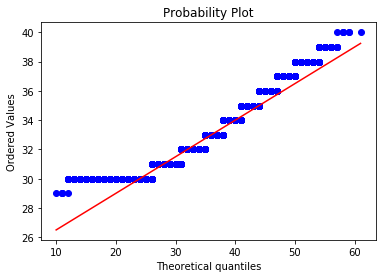

16777216
---- Normalized data ----
Mean: 31.99996566772461; expected: 32; difference: 3.4332275390625e-05
Std: 4.406448363079107; expected: 32; difference: 27.593551636920893
difference between std and mean :27.593517304645502
MWU: MannwhitneyuResult(statistic=515.0, pvalue=2.392852534584597e-05)
Levene: LeveneResult(statistic=0.042903244865098666, pvalue=0.8363861117847513)


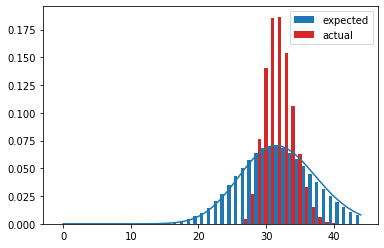

---- Sample data ----
MWU: MannwhitneyuResult(statistic=829.0, pvalue=0.035932818725379616)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


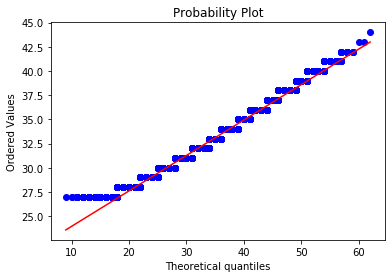

33554432
---- Normalized data ----
Mean: 31.99998188018799; expected: 32; difference: 1.811981201171875e-05
Std: 1.470023154884075; expected: 32; difference: 30.529976845115925
difference between std and mean :30.529958725303914
MWU: MannwhitneyuResult(statistic=214.0, pvalue=7.979931805727268e-08)
Levene: LeveneResult(statistic=0.1582647925997174, pvalue=0.6919362221386288)


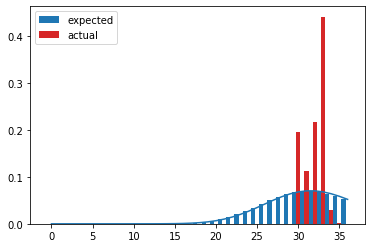

---- Sample data ----
MWU: MannwhitneyuResult(statistic=654.5, pvalue=0.335908937906061)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


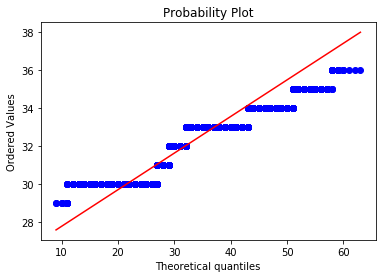

In [193]:
perform_test(seq='stoneham',lamb=32)

In [314]:
print(max_w)
print(maximo)

0000000000000000011111
15


---- Normalized data ----
Mean: 0.9999998994171619; expected: 1; difference: 1.0058283805847168e-07
Std: 8.023705665022122; expected: 1; difference: 7.023705665022122
difference between std and mean :7.02370576560496
MWU: MannwhitneyuResult(statistic=778.0, pvalue=1.5292828788246256e-21)
Levene: LeveneResult(statistic=2.6305564873700367e-09, pvalue=0.9999591342959928)


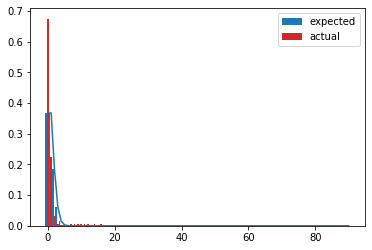

---- Sample data ----
MWU: MannwhitneyuResult(statistic=778.0, pvalue=2.7252759848877215e-23)
Levene: LeveneResult(statistic=2.6305968599757835e-09, pvalue=0.9999591338303142)


KeyboardInterrupt: 

In [338]:
analize_result(occs3[N],N,plot=True,l=lamb)
analize_result_2(occs3[N],plot=True,l=lamb)

In [139]:
for k,v in amounts[N].items():
    if v+10 >= max_v:
        print("key: " + str(k) + " appears: " + str(v))

key: 0000000000 appears: 822


---- Normalized data ----
Mean: 0.9999351501464844; expected: 1; difference: 6.4849853515625e-05
Std: 3.2263755756284818; expected: 1; difference: 2.2263755756284818
difference between std and mean :2.2264404254819974
MWU: MannwhitneyuResult(statistic=203.0, pvalue=4.806501554569991e-05)
Levene: LeveneResult(statistic=1.095010218297123e-06, pvalue=0.9991685433884085)


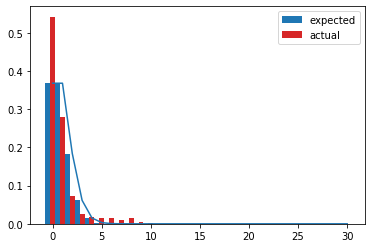

---- Sample data ----
MWU: MannwhitneyuResult(statistic=201.0, pvalue=2.921268966690139e-05)
Levene: LeveneResult(statistic=1.0955487777117433e-06, pvalue=0.999168338947102)


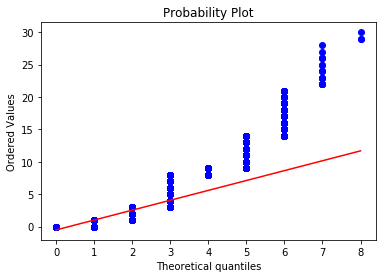

In [375]:
N = 2**18
Ns = [N]
(occs,amounts) = get_amounts_for_ns(Ns,lamb=1,use_seq='champernowne')
# print(amounts)
for N in Ns:
#     print(N)
#     print(occs)
#     print(len(occs[N]))
    analize_result(occs[N],N,plot=True,l=lamb)
    analize_result_2(occs[N],plot=True,l=lamb)

In [376]:
max_v = 0
max_k = None
for k,v in amounts[N].items():
    if v >= max_v:
        max_k = k
        max_v = v
print(max_k)
print(max_v)

000000000000000000
30


In [377]:
for k,v in amounts[N].items():
    if v+10 >= max_v:
        print("key: " + str(k) + " appears: " + str(v))

key: 000000000000100000 appears: 23
key: 000000000001000000 appears: 27
key: 000000000010000000 appears: 29
key: 000000000000000000 appears: 30
key: 000000000100000000 appears: 29
key: 000000001000000000 appears: 28
key: 000000000110000000 appears: 26
key: 000000000101000000 appears: 23
key: 000000001010000000 appears: 26
key: 000000001001000000 appears: 24
key: 000000001101000000 appears: 22
key: 000000010000000000 appears: 26
key: 000000000011000000 appears: 22
key: 000000001100000000 appears: 25
key: 000000010100000000 appears: 24
key: 000000011000000000 appears: 23
key: 000000000111000000 appears: 21
key: 000000001110000000 appears: 24
key: 000000010010000000 appears: 25
key: 000000001011000000 appears: 20
key: 000000010110000000 appears: 22
key: 000000011010000000 appears: 22
key: 000000011100000000 appears: 21
key: 000000001111000000 appears: 20
key: 000000010001000000 appears: 23
key: 000000010011000000 appears: 20
key: 000000010101000000 appears: 20
key: 000000011001000000 appe

In [ ]:
words = itertools.product(['0', '1'], repeat=25)
maximo = 0
max_w = None
aux = 0
w = None
for k,v in amounts[N].items():
    w = ''.join(next(words))
    if w not in amounts[N]:
        aux += 1
        if aux > maximo:
            maximo = aux
            max_w = w
    else:
        aux = 0
            
print(max_w)
print(maximo)

In [246]:
power = 4
N = 2**power
M = power
apps = N - M + 1
print(apps)
print(N)
x= np.arange(0,N,1)
p = poisson.pmf(x,1)
print(p)
print(list(map(lambda x: N*x,p)))

13
16
[3.67879441e-01 3.67879441e-01 1.83939721e-01 6.13132402e-02
 1.53283100e-02 3.06566201e-03 5.10943668e-04 7.29919526e-05
 9.12399408e-06 1.01377712e-06 1.01377712e-07 9.21615563e-09
 7.68012969e-10 5.90779207e-11 4.21985148e-12 2.81323432e-13]
[5.886071058743077, 5.886071058743077, 2.9430355293715382, 0.9810118431238463, 0.24525296078096162, 0.04905059215619232, 0.008175098692698717, 0.0011678712418141022, 0.00014598390522676274, 1.6220433914084768e-05, 1.6220433914084779e-06, 1.4745849012804316e-07, 1.228820751067029e-08, 9.452467315900226e-10, 6.751762368500137e-11, 4.501174912333422e-12]


In [ ]:
def generate_supernormal_sequence(M):
    lamb = 1
    if M == 1:
        return '01'
    
    prev = generate_supernormal_sequence(M-1)
    
    #iterate through previous sequence to check which ones i've got
    blocks = {}
    for i in range(len(prev)-M+1):
        block = prev[i:i+M]
        if block not in blocks:
            blocks[block] = 0
        blocks[block] +=1
    
    current_amounts = get_occurrencies(blocks,M)
    x= np.arange(0,N,1)
    p = poisson.pmf(x,1)
    expected_amounts(list(map(lambda x: math.rount(N*x),p)))
    
        
    

In [278]:
prev='0111'
M = 3
N = 2*len(prev)

apps = N - M + 1
blocks = {}
#iterate through previous sequence to check which ones i've got
blocks = {}
for i in range(len(prev)-M+1):
    block = prev[i:i+M]
    if block not in blocks:
        blocks[block] = 0
    blocks[block] +=1
print(blocks)
#por ahora voy a asumir que las frecuencias anteriores llegan mas o menos bien
#es decir que ninguno tiene mas apareiciones de las esperadas
current_amounts = get_occurrences(blocks,M)
x= np.arange(0,apps,1)
p = poisson.pmf(x,1)
amounts = list(map(lambda x: (apps*x),p))
expected_amounts = list(map(lambda x: int(round(apps*x)),p))
print(amounts)
print(current_amounts)
print(expected_amounts)
print(apps)

#to do
#correct the amounts expected to get N - M + 1
# if sum(expected_amounts) > apps:
#assuming correct amounts for now

word = prev[len(prev)-M+1:]
#check how possible words would affect and pick one greedily
w0 = word + '0'
w1 = word + '1'
coin = False
for i in range(len(prev)):
    if w0 not in blocks and w1 not in blocks:
        #ninguna de las dos estan, da igual
        if coin:
            word = w0[1:]
        else:
            word = w1[1:]
        coin = not coin
    elif w0 not in blocks and sum(expected_amounts[1:]) < sum(amounts[1:]):
        word = w0[1:]
    elif w1 not in blocks and sum(expected_amounts[1:]) < sum(amounts[1:]):
        word = w1[1:]
    elif :
        #aca al menos una de las dos esta, y la que no esta no conviene ponerla
        ct = 
            
    


SyntaxError: invalid syntax (<ipython-input-278-e52a7b530e30>, line 48)